<a href="https://colab.research.google.com/github/sufian-utm/deep_learning-evaluation/blob/main/CWRU_All_Data/DL_PyTorch_Multi_IO_CWRU_All_Data_Base_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -----------------------------------------------------------------------------
#           CWRU Bearing Fault Diagnosis - Google Colab & Kaggle
# -----------------------------------------------------------------------------
import kagglehub
import os
import shutil
import sys

# -----------------------------
# Check the environment
# -----------------------------
def check_environment():
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return "Kaggle"
    elif any(key.startswith('COLAB_') for key in os.environ):
        return "Colab"
    else:
        return "Local"

environment = check_environment()
print(f"Running in: {environment}")

if environment == 'Colab':
    # Copy Kaggle data to Colab
    kaggle_data = kagglehub.dataset_download('sufian79/cwru-mat-full-dataset')
    data_dir = '/content/cwru'

    try:
        new_dir_path = shutil.copytree(kaggle_data, data_dir, dirs_exist_ok=True)
        print(f"Directory copied successfully to: {new_dir_path}")
    except shutil.Error as e:
        print(f"Error copying directory: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    # Copy Kaggle .py to Colab
    kaggle_py = kagglehub.dataset_download('mohdsufianbinothman/pytorch-models')

    try:
        main_dir_path = shutil.copytree(kaggle_py, '/content', dirs_exist_ok=True)
    except shutil.Error as e:
        print(f"Error copying directory: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    # Create output folder
    try:
        save_dir = '/content/output'
        os.makedirs(save_dir, exist_ok=True)
        print(f"Directory '{save_dir}' created successfully.")
    except OSError as e:
        print(f"Error creating directory: {e}")

elif environment == 'Kaggle':
    data_dir = "/kaggle/input"
    save_dir = '/kaggle/working/cwru'
    os.makedirs(save_dir, exist_ok=True)
    print(f"Directory save_dir '{save_dir}' created successfully.")

    if os.path.exists(os.path.join(data_dir, '100.mat')):
        print(f"data_dir={data_dir}")
    elif os.path.exists(os.path.join(data_dir, 'cwru-mat-full-dataset', '100.mat')):
        data_dir += '/cwru-mat-full-dataset'
        print(f"data_dir = '{data_dir}'")
    else:
        print("""
            ❌ Dataset not found!

            Please attach the dataset manually via the sidebar in the notebook editor:

            1. Click “Add Input” and select "Datasets"
            2. Search keyword: Pytorch Models Sufian
            3. Click “+” to add CWRU .mat Full Dataset by Mohd Sufian (246 MB)
            """)

    if os.path.exists(os.path.join('/kaggle/input', 'base_models.py')):
        shutil.copy('/kaggle/input/base_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/ext_base_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/ext_hybrid_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/hybrid_models.py', '/kaggle/working/')
    elif os.path.exists(os.path.join('/kaggle/input', 'pytorch-models', 'base_models.py')):
        shutil.copy('/kaggle/input/pytorch-models/base_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/pytorch-models/ext_base_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/pytorch-models/ext_hybrid_models.py', '/kaggle/working/')
        shutil.copy('/kaggle/input/pytorch-models/hybrid_models.py', '/kaggle/working/')
    else:
        print("""
            ❌ Dataset not found!

            Please attach the dataset manually via the sidebar in the notebook editor:

            1. Click “Add Input” and select "Datasets"
            2. Search keyword: CWRU .mat
            3. Click “+” to add Pytorch Models by Mohd Sufian
            """)

else:
    print("Error: Unknown environment")
    sys.exit(1)


Running in: Colab
Directory copied successfully to: /content/cwru
Directory '/content/output' created successfully.


In [3]:
import importlib.util
import subprocess
import sys

packages = ['fvcore']  # add more as needed

for package_name in packages:
    if importlib.util.find_spec(package_name) is None:
        print(f"{package_name} not found. Installing silently...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package_name],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL
        )
    else:
        print(f"{package_name} is already installed.")


fvcore not found. Installing silently...


## **Part 1: Define Required Codes**

### **Libraries and Functions**

**Imports Libraries:**

Imports necessary Python libraries for specific task.

**Defines Functions:**

Creates functions for all related task.

In [4]:
# ============================================================
# 📚 Import Libraries
# ============================================================

# Standard libraries
import os
import time
import random
import warnings
import re

# Numerical and data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import scipy.io as sio
from scipy.io import loadmat
from scipy.signal import resample, resample_poly

# Machine learning and deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from fvcore.nn import FlopCountAnalysis

# Scikit-learn
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, accuracy_score,
    confusion_matrix, mean_absolute_percentage_error, classification_report,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import StratifiedShuffleSplit

# Progress bar and monitoring tools
import wandb
from tqdm import tqdm

# ==============================================================================
# ⚙️ UNIVERSAL FUNCTIONS SHARED WITH ALL DATASETS
# ==============================================================================

# ---------------------------- Counts for each category ----------------------------
def category_counts_for_set(X, y, col_nums, col_labels):
    """
    Calculates and displays category counts for a given dataset (train, val, or test).

    Args:
        X (array-like): Input features.
        y (array-like): Target variables (fault type and size).
        col_nums (array-like): Columns number start with 0.
        col_labels (array-like): Columns label correspond to col_nums.

    Returns:
        Pandas DataFrame: Category counts with labels.
    """
    # Select only the desired columns using fancy indexing
    selected_cols = y[:, col_nums]
    cols_labels = col_labels

    # Create the DataFrame with the selected columns
    df = pd.DataFrame(selected_cols, columns=cols_labels)

    # Group the DataFrame by labels and count the occurrences
    category_counts = df.groupby(cols_labels).size().reset_index(name='count')

    # Map the columns to their respective labels
    category_counts['check_label'] = category_counts['fault_check'].map(
        {v: k for k, v in fault_check_map.items()}
    )
    category_counts['type_label'] = category_counts['fault_type'].map(
        {v: k for k, v in fault_type_map.items()}
    )
    category_counts['size_label'] = category_counts['fault_size'].map(
        {v: k for k, v in fault_size_cls_map.items()}
    )
    category_counts['type_size_label'] = category_counts['fault_type_size'].map(
        {v: k for k, v in fault_type_size_map.items()}
    )

    # Return the final DataFrame with the relevant labels and counts
    return category_counts[['check_label', 'type_label', 'size_label', 'type_size_label', 'count']]

# Plot first and last segments of groups
def plot_segments(X_padded, y, unique_fault_types, fault_type_sizes, fault_type_map, fault_size_cls_map):
    """
    Plots the first and last segments for each combination of fault type and size.

    Parameters:
    - X_padded: np.ndarray, the segmented vibration data (num_samples, segment_length)
    - y: np.ndarray, labels array where column 1 is fault type and column 2 is fault size
    - unique_fault_types: list of unique fault type values (from y[:, 1])
    - fault_type_sizes: dict mapping each fault type to its associated list of fault sizes
    - fault_type_map: dict mapping fault type labels (str) to numeric codes
    - fault_size_cls_map: dict mapping fault size labels (str) to numeric codes
    """

    # Identify valid subplot positions (only those with available data)
    subplots_to_use = []
    for i, fault_type in enumerate(unique_fault_types):
        for j, fault_size in enumerate(fault_type_sizes[fault_type]):
            indices = np.where((y[:, 1] == fault_type) & (y[:, 2] == fault_size))[0]
            if len(indices) > 0:
                subplots_to_use.append((i, j))

    # Determine subplot grid dimensions
    num_rows = len(unique_fault_types)
    num_cols = max(len(fault_type_sizes[fault_type]) for fault_type in unique_fault_types)

    # Create the figure and subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), squeeze=False)
    fig.suptitle("First and Last Segments for Each Fault Type and Size", fontsize=16)

    # Plot segments for each valid subplot
    for i, j in subplots_to_use:
        fault_type = unique_fault_types[i]
        fault_size = fault_type_sizes[fault_type][j]
        indices = np.where((y[:, 1] == fault_type) & (y[:, 2] == fault_size))[0]
        if len(indices) == 0:
            continue

        first_segment_index = indices[1]
        last_segment_index = indices[-1]

        ax = axes[i, j]
        ax.plot(X_padded[first_segment_index], label="First Segment")
        ax.plot(X_padded[last_segment_index], label="Last Segment")

        # Convert numeric fault codes back to labels
        fault_type_label = next(k for k, v in fault_type_map.items() if v == fault_type)
        fault_size_label = next(k for k, v in fault_size_cls_map.items() if v == fault_size)

        ax.set_title(f"Type: {fault_type_label}, Size: {fault_size_label}")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Amplitude")
        ax.legend()

    # Remove unused subplots
    for i in range(num_rows):
        for j in range(num_cols):
            if (i, j) not in subplots_to_use:
                fig.delaxes(axes[i, j])

    # Final layout adjustment and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot training history
def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(15, 5))

    # Plot for loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()

    # Plot for classification accuracy (Fault Type Accuracy)
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_type_acc'], label='Type Acc')
    plt.plot(epochs, history['val_size_acc'], label='Size Acc')
    plt.plot(epochs, history['val_type_size_acc'], label='Type & Size Acc')
    plt.title("Classification Accuracy")
    plt.legend()

    # Plot for regression R² (Fault Size)
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_size_mse'], label='Size MSE')
    plt.title("Regression MSE (Fault Size)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ==============================================================================
# ⚙️ FUNCTIONS EXCLUSIVE ONLY FOR THIS CWRU ALL DATASETS
# ==============================================================================

# Helper: slicer
def slicer(signal, seq_len, input_channels):
    num_slices = len(signal) // seq_len
    signal = signal[:num_slices * seq_len]
    return signal.reshape(num_slices, input_channels, seq_len)  # Reshape for 3 channels

# 1. Extract vibration signal from file (3 channels)
def extract_vibration(data, seq_len, threshold, sampling_rate_ori, sampling_rate_target):
    # Resample data if the sampling rates are different
    if sampling_rate_ori != sampling_rate_target:
        num_samples_target = int(len(data) * (sampling_rate_target / sampling_rate_ori))
        data_resampled = np.array([resample(data[:, i], num_samples_target) for i in range(data.shape[1])]).T
    else:
        data_resampled = data  # No resampling if the rates are the same

    # Slicing the 3-channel vibration signal into smaller sequences
    data_sliced = slicer(data_resampled, seq_len, data.shape[1])

    # Ensure we have exactly `threshold` slices
    if data_sliced.shape[0] < threshold:
        repeater = threshold - data_sliced.shape[0]
        data_sliced = np.concatenate((data_sliced, np.repeat(data_sliced[-1][None, :, :], repeater, axis=0)))
    elif data_sliced.shape[0] > threshold:
        data_sliced = data_sliced[:threshold]

    return data_sliced

# 2. Process dataset
def process_dataset(file_list, fault_type_map, fault_size_map, fault_size_mm_map, fault_combination_map,
                    channel_num=3, seq_len=1024, threshold=5, sampling_rate_ori=24000, sampling_rate_target=24000):
    X_vibration = []
    y = []

    # For file and data contents checking purpose
    '''
    for file_path in file_list:
        filename = os.path.basename(file_path)
        print(f"processing {filename} file....")

        # Load the .mat file (assuming each file contains 3 channels of sensor data)
        try:
            data = loadmat(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        # Loop through all keys (excluding metadata keys)
        for key in data:
            if not key.startswith('__'):
                value = data[key]
                print(f"Key: {key}")
                print(f"Type: {type(value)}, Shape: {value.shape}")
                print("-" * 50)
    '''

    for file_path in file_list:
        filename = os.path.basename(file_path)

        # Initialize fault values
        fault_check = None
        fault_type = None
        fault_size = None
        fault_size_mm = None
        fault_combination = None

        # Load the .mat file (assuming each file contains 3 channels of sensor data)
        try:
            data = loadmat(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        col_names = []
        sensor_data_dict = {}

        filename = os.path.basename(file_path)
        name_only, _ = os.path.splitext(filename)

        # Manual correction for known mismatch
        if name_only == '174':
            name_only = '173'

        key_code = f"X{name_only.zfill(3)}"  # Usually CWRU keys are like 'X105', 'X118', etc.

        for key in data:
            if not key.startswith('__') and (key == f"{key_code}_DE_time" or key == f"{key_code}_FE_time"):
                value = data[key]

                if isinstance(value, np.ndarray):
                    value = value.flatten()
                    sensor_data_dict[key] = value
                    col_names.append(key)

        # Ensure all selected arrays are the same length
        lengths = [len(arr) for arr in sensor_data_dict.values()]
        if len(set(lengths)) != 1:
            print(f"Skipping {file_path} due to inconsistent array lengths: {lengths}")
            continue

        sensor_data = pd.DataFrame(sensor_data_dict, columns=col_names)

        # Display first few rows
        # print(sensor_data.head())

        # Extract vibration data from the file (for all 3 channels)
        vibration = extract_vibration(sensor_data.to_numpy(), seq_len, threshold, sampling_rate_ori, sampling_rate_target)

        if vibration.shape[0] == 0:
            print(f"Warning: No valid signals in {file_path}. Skipping...")
            continue

        name_only, _ = os.path.splitext(filename)

        # Check if file is "Healthy" or "Faulty"
        if name_only in fault_type_map and fault_type_map[name_only] == 0:
            fault_check = 0  # Healthy
        else:
            fault_check = 1  # Faulty

        # Find fault type
        for key in fault_type_map:
            if key == name_only:
                fault_type = fault_type_map[key]
                fault_size = fault_size_map[key]
                fault_size_mm = fault_size_mm_map[key]
                fault_combination = fault_combination_map[key]
                break

        # Add vibration data and labels to the lists
        for idx in range(vibration.shape[0]):
            X_vibration.append(vibration[idx])  # Store the 3-channel vibration data
            # Add the mapped fault_combination_value instead of the string
            y.append([fault_check, fault_type, fault_size, fault_combination, fault_size_mm])

    X_vibration = np.array(X_vibration)
    y = np.array(y, dtype=object)

    return X_vibration, y

# Modified for all combined datasets
def process_dataset_alldata(file_list, fault_type_map, fault_size_map, fault_size_mm_map, fault_combination_map,
                            channel_num=3, seq_len=1024, threshold=5, sampling_rate_target=24000):

    X_vibration = []
    y = []

    for file_path, file_code, sr_key in file_list:
        filename = os.path.basename(file_path)

        # Manual correction for known mismatch (file 174 should be treated as file 173)
        if file_code == '174':
            file_code = '173'

        # Initialize fault values
        fault_check = None
        fault_type = None
        fault_size = None
        fault_size_mm = None
        fault_combination = None

        try:
            data = loadmat(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        key_code = f"X{file_code.zfill(3)}"
        sensor_data_dict = {}
        col_names = []

        # Correctly determine the sampling rate by checking the integer value
        if '48' in sr_key:
            sampling_rate_ori = 48000
        elif '12' in sr_key:
            sampling_rate_ori = 12000
        else:
            print(f"Warning: Unexpected sampling rate for {file_path}, skipping...")
            continue

        # Load sensor signals
        for key in data:
            if not key.startswith("__"):
                if key == f"{key_code}_DE_time":
                    sensor_data_dict[key] = data[key].flatten()
                    col_names.append(key)
                elif key == f"{key_code}_FE_time":
                    sensor_data_dict[key] = data[key].flatten()
                    col_names.append(key)

        if not sensor_data_dict:
            print(f"No valid keys in {file_path}. Skipping...")
            continue

        lengths = [len(arr) for arr in sensor_data_dict.values()]
        if len(set(lengths)) != 1:
            print(f"Skipping {file_path} due to inconsistent array lengths: {lengths}")
            continue

        sensor_data = pd.DataFrame(sensor_data_dict, columns=col_names)

        # Extract vibration signals
        vibration = extract_vibration(sensor_data.to_numpy(), seq_len, threshold, sampling_rate_ori, sampling_rate_target)
        if vibration.shape[0] == 0:
            print(f"Warning: No valid signals in {file_path}. Skipping...")
            continue

        # Revert back for known mismatch (file 174 should be treated as file 173)
        if file_code == '173':
            file_code = '174'

        fault_type = fault_type_map[sr_key].get(file_code)
        fault_check = 0 if fault_type == 0 else 1
        fault_size = fault_size_map[sr_key].get(file_code)
        fault_combination = fault_combination_map[sr_key].get(file_code)
        fault_size_mm = fault_size_mm_map[sr_key].get(file_code)

        for idx in range(vibration.shape[0]):
            X_vibration.append(vibration[idx])
            y.append([fault_check, fault_type, fault_size, fault_combination, fault_size_mm])

    X_vibration = np.array(X_vibration)
    y = np.array(y, dtype=object)

    print(f"X shape: {X_vibration.shape}")
    print(f"y shape: {y.shape}")

    return X_vibration, y

# 3. Extract first and last segments by fault type and size
def plot_fault_segments(X_vibration, y, seq_len):
    # 1. Create a dictionary to store segments by fault type and size level
    fault_segments = {}

    for idx in range(len(y)):
        fault_check, fault_type, fault_size, fault_size_mm, fault_combination = y[idx]
        vibration_segment = X_vibration[idx]

        # Correct fault combination for normal data (fault_check == 0)
        if fault_check == 0:
            # Ensure only fault size 0 for fault type 0 (normal)
            fault_combination = "0_0"  # Normal data combination (fault type 0 and size 0)

        # Create a key for fault type and size level
        fault_key = f"{fault_type}_{fault_size}"

        # Initialize the list if the key doesn't exist
        if fault_key not in fault_segments:
            fault_segments[fault_key] = {'first': None, 'last': None}

        # Set the first and last segments
        if fault_segments[fault_key]['first'] is None:
            fault_segments[fault_key]['first'] = vibration_segment
        fault_segments[fault_key]['last'] = vibration_segment

    # 2. Plot the first and last segments for each fault type and size
    for fault_key, segments in fault_segments.items():
        first_segment = segments['first']
        last_segment = segments['last']

        # Create a plot
        plt.figure(figsize=(12, 6))

        # Plot the first segment in blue
        plt.plot(np.arange(seq_len), first_segment[0], label='First Segment DE', color='blue')
        plt.plot(np.arange(seq_len), first_segment[1], label='First Segment FE', color='green')

        # Plot the last segment in orange
        plt.plot(np.arange(seq_len), last_segment[0], label='Last Segment DE', color='orange')
        plt.plot(np.arange(seq_len), last_segment[1], label='Last Segment FE', color='yellow')

        # Title and labels
        plt.title(f"First and Last Segment for {fault_key}")
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.tight_layout()
        plt.show()

# ==============================================================================
# 🧠 PYTORCH DEEP LEARNING FUNCTIONS
# ==============================================================================
# 1. Reshape inputs based on model type
def reshape_input_pt(X, model_name, channel_in=3):
    model_type_map = {
        'mlp': ['MLP1D_pt'],
        'cnn': [
            'CNN1D_pt', 'ResNet1D_pt', 'DenseNet1D_pt', 'TinyVGG1D_pt',
            'Xception1D_pt', 'MobileNet1D_pt', 'EfficientNet1D_pt', 'DeepCNN1D_pt',
            'CNN_BiGRU_pt', 'CNN_BiGRU_Attention_pt', 'ResNet_BiGRU_pt',
            'CNN_Transformer_pt', 'DenseNet_Transformer_pt', 'CNN_LSTM_Attention_pt',
            'CNN_BiLSTM_Attention_pt', 'DeepCNN_BiGRU_pt', 'DenseCNN_Transformer_pt',
            'CNN_GRU_Attention_pt', 'DenseResNet1D_pt', 'HyenaPatchTST1D_pt',
            'Hyena_LSTM1D_pt', 'PatchTST_CNN_BiGRU1D_pt', 'SAMformer_BiGRU1D_pt',
            'Autoformer_ResNet1D_pt', 'TreeDRNet_LSTM1D_pt', 'LITE_CNN1D_pt',
            'SCINet_GRU1D_pt', 'iTransformer_CNN1D_pt', 'FCN1D_pt', 'TCN1D_pt',
            'WaveNet1D_pt', 'ConvNeXt1D_pt', 'SqueezeNet1D_pt', 'ShuffleNet1D_pt',
        ],
        'rnn': [
            'LSTM1D_pt', 'GRU1D_pt', 'BiLSTM1D_pt',
        ],
        'transformer': [
            'Transformer1D_pt', 'TSMixer1D_pt', 'PatchTST1D_pt', 'Hyena1D_pt',
            'SAMformer1D_pt', 'Autoformer1D_pt', 'TreeDRNet1D_pt', 'Informer1D_pt',
            'LITE1D_pt', 'SCINet1D_pt', 'iTransformer1D_pt', 'ViT1D_pt', 'SwinTransformer1D_pt',
        ],
    }

    X = torch.tensor(X, dtype=torch.float32)

    if model_name in model_type_map['cnn']:
        if X.ndim == 2:
            return X.unsqueeze(1).repeat(1, channel_in, 1)  # [N, C, L]
        elif X.ndim == 3:
            return X  # already [N, C, L]
        else:
            raise ValueError(f"Unexpected input shape for CNN: {X.shape}")

    elif model_name in model_type_map['rnn']:
        if X.ndim == 2:
            return X.unsqueeze(-1).repeat(1, 1, channel_in)  # [N, L, C]
        elif X.ndim == 3:
            return X  # already [N, L, C]
        else:
            raise ValueError(f"Unexpected input shape for RNN: {X.shape}")

    elif model_name in model_type_map['transformer']:
        if X.ndim == 2:
            return X.unsqueeze(-1).repeat(1, 1, channel_in)  # [N, L, C]
        elif X.ndim == 3:
            return X  # already [N, L, C]
        else:
            raise ValueError(f"Unexpected input shape for Transformer: {X.shape}")

    elif model_name in model_type_map['mlp']:
        if X.ndim == 3:
            return X.view(X.shape[0], -1)  # flatten [N, C*L]
        elif X.ndim == 2:
            return X  # [N, L]
        else:
            raise ValueError(f"Unexpected input shape for MLP: {X.shape}")

    else:
        raise ValueError(f"Unknown model_name: {model_name}")

# 2. Create a DataLoader from reshaped data
def create_dataloader_pt(X, y, batch_size, model_name, channel_in=3, num_workers=4, pin_memory=None):
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()

    # Reshape inputs
    X_reshaped = reshape_input_pt(X, model_name, channel_in)

    # Convert and check target shape
    y = np.array(y, dtype=np.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    if y_tensor.ndim != 2 or y_tensor.shape[1] < 5:
        raise ValueError(f"Expected y to have shape [N, 5], but got shape {y_tensor.shape}")

    # Split targets
    y1 = y_tensor[:, 0].long()  # fault_check
    y2 = y_tensor[:, 1].long()  # fault_type
    y3 = y_tensor[:, 2].long()  # fault_size_class
    y4 = y_tensor[:, 3].long()  # fault_type_size
    y5 = y_tensor[:, 4]         # fault_size_regression (float)

    dataset = TensorDataset(X_reshaped, y1, y2, y3, y4, y5)

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

# 3. Generate all dataloaders
def generate_dataloaders_pt(model_name, X_train, y_train, X_val, y_val, X_test, y_test,
                            channel_in=3, batch_size=64, num_workers=4, pin_memory=None):
    if pin_memory is None:
        pin_memory = torch.cuda.is_available()

    train_loader = create_dataloader_pt(X_train, y_train, batch_size, model_name,
                                        channel_in=channel_in, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = create_dataloader_pt(X_val, y_val, batch_size, model_name,
                                      channel_in=channel_in, num_workers=num_workers, pin_memory=pin_memory)
    test_loader = create_dataloader_pt(X_test, y_test, batch_size, model_name,
                                       channel_in=channel_in, num_workers=num_workers, pin_memory=pin_memory)
    return train_loader, val_loader, test_loader

# Functions for training and evaluation loop
def get_optimizer(optimizer_choice, model, lr, weight_decay):
    OPTIMIZER_FACTORY = {
        'Adam': lambda params, lr, weight_decay: torch.optim.Adam(params, lr=lr, weight_decay=weight_decay),
        'AdamW': lambda params, lr, weight_decay: torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay),
        'SGD': lambda params, lr, weight_decay: torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay),
        'RMSprop': lambda params, lr, weight_decay: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay),
    }
    if optimizer_choice not in OPTIMIZER_FACTORY:
        raise ValueError(f"Unsupported optimizer '{optimizer_choice}'. Choose from {list(OPTIMIZER_FACTORY.keys())}")
    return OPTIMIZER_FACTORY[optimizer_choice](model.parameters(), lr, weight_decay)

def save_plot(save_dir, title, file_format='png'):
    """
    Saves the current matplotlib plot to the specified directory
    using a cleaned title as filename.

    Parameters:
    - save_dir (str): Directory where the plot will be saved.
    - title (str): Title used to generate the filename.
    - file_format (str): File format, e.g., 'png', 'jpg', 'pdf'. Default is 'png'.
    """
    os.makedirs(save_dir, exist_ok=True)
    safe_title = re.sub(r'[^\w\-_. ]', '', title).replace(' ', '_')
    save_path = os.path.join(save_dir, f"{safe_title}.{file_format}")
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Plot saved to: {save_path}")

def plot_confusion_matrix(conf_matrix, label_names, title, color=plt.cm.Blues,
                          save_dir=None, rotation_angle=0, font_size=10):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=color)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    xtick_labels = list(label_names.keys())

    plt.xticks(tick_marks, xtick_labels, rotation=rotation_angle, fontsize=font_size)
    plt.yticks(tick_marks, xtick_labels, fontsize=font_size)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black",
                 fontsize=font_size)
    plt.ylabel('True label', fontsize=font_size)
    plt.xlabel('Predicted label', fontsize=font_size)
    plt.tight_layout()

    # Save if save_dir is provided
    if save_dir:
        save_plot(save_dir, title)

    plt.show()

def compute_total_loss(loss_type, loss_size_cls, loss_type_size, loss_size_reg):
    """
    Compute the weighted total loss.

    Args:
        loss_type (float or tensor): Loss for fault type classification.
        loss_size_cls (float or tensor): Loss for fault size classification.
        loss_type_size (float or tensor): Combined loss for type and size classification.
        loss_size_reg (float or tensor): Loss for fault size regression.

    Returns:
        total_loss (float or tensor): Weighted sum of the input losses.
    """
    total_loss = (
        0.2 * loss_type +
        0.2 * loss_size_cls +
        0.3 * loss_type_size +
        0.3 * loss_size_reg
    )
    return total_loss

# The main train, eval, and test loop
def train_evaluate_model_pt(model, train_loader, val_loader, test_loader, device,
                            epochs=10, lr=1e-3, optimizer_choice='AdamW', weight_decay=1e-4,
                            scheduler_factor=0.5, scheduler_patience=3, scheduler_mode='min', max_grad_norm=1.0,
                            early_patience=5):

    # Loss functions for each output
    criterion_check = nn.BCEWithLogitsLoss()        # Binary for fault check
    criterion_type = nn.CrossEntropyLoss()          # Cross-entropy for fault type
    criterion_size_cls = nn.CrossEntropyLoss()      # Cross-entropy for size classification (if you use it)
    criterion_type_size = nn.CrossEntropyLoss()     # Cross-entropy for size classification (alternative)
    criterion_size_reg = nn.MSELoss()               # MSE for fault size regression

    # Optimizer initialization
    optimizer = get_optimizer(optimizer_choice, model, lr, weight_decay)

    # Scheduler ReduceLROnPlateau with customizable parameters
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode=scheduler_mode,         # 'min' for loss, 'max' for accuracy
        factor=scheduler_factor,     # Learning rate reduction factor
        patience=scheduler_patience  # Patience for LR adjustment
    )

    train_losses, val_losses = [], []
    train_check_accs, train_type_accs, train_size_accs, train_type_size_accs = [], [], [], []
    train_size_mses, train_size_maes, train_size_r2s, train_size_mapes = [], [], [], []
    train_scores = []
    val_check_accs, val_type_accs, val_size_accs, val_type_size_accs = [], [], [], []
    val_size_mses, val_size_maes, val_size_r2s, val_size_mapes = [], [], [], []
    val_scores = []
    time_elapses = []

    best_val_loss = float('inf')
    best_model_state = None
    patience = early_patience  # You can adjust this; typical values are 5–20
    patience_counter = 0

    start_time = time.time()

    # Dynamically get the class name and save the model
    class_name = model.__class__.__name__

    # wand settings - Shared project and entity
    wandb_entity = WANDB_ENTITY
    wandb_project = WANDB_PROJECT
    wandb_group = WANDB_GROUP    # change for each notebook: Notebook_2, Notebook_3, etc.
    wandb_dataset = WANDB_DATASET

    run = wandb.init(
        entity=wandb_entity,
        project=wandb_project,
        name=class_name,
        group=wandb_group,
        config={
            "architecture": class_name,                # Model architecture name
            "dataset": wandb_dataset,
            "learning_rate": lr,                       # Learning rate for the model
            "batch_size": BATCH_SIZE,                  # Batch size for training
            "num_workers": NUM_WORKERS,
            "epochs": epochs,                          # Number of training epochs
            "optimizer_choice": optimizer_choice,      # Optimizer choice (AdamW)
            "weight_decay": weight_decay,              # Weight decay regularization
            "scheduler_factor": scheduler_factor,      # Learning rate scheduler factor
            "scheduler_patience": scheduler_patience,  # Scheduler patience for adjusting the learning rate
            "scheduler_mode": scheduler_mode,          # Scheduler mode ('min' or 'max')
            "max_grad_norm": max_grad_norm,            # Gradient clipping value
            "early_patience": early_patience,          # Early stopping patience
            "momentum": 0.9,                           # Momentum for optimizer (if applicable)
            "activation_function": "ReLU",             # Activation function used in the model
            "input_size": (INPUT_DIM, BATCH_SIZE),     # Input data dimensions (seq_len, channels)
            "dropout_rate": DROPOUT_RATE,              # Dropout rate for regularization
            "learning_rate_schedule": "step_decay",    # Learning rate schedule method
            "batch_norm": True,                        # Whether batch normalization is used
            "early_stopping": True,                    # Whether early stopping is enabled
            "loss_function": "CrossEntropyLoss",       # Loss function used in training
        },
    )

    for epoch in range(epochs):

        # --- Training loop ---
        epoch_start_time = time.time()
        model.train()
        train_loss = 0
        train_check_preds, train_check_targets = [], []
        train_type_preds, train_type_targets = [], []
        train_size_cls_preds, train_size_cls_targets = [], []
        train_type_size_preds, train_type_size_targets = [], []
        train_size_reg_preds, train_size_reg_targets = [], []

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", leave=False, disable=True)
        for batch_idx, batch in progress_bar:
            inputs, y_check, y_type, y_size_cls, y_type_size, y_size_reg = batch

            inputs = inputs.float().to(device)
            y_check = y_check.float().to(device)
            y_type = y_type.long().to(device)
            y_size_cls = y_size_cls.long().to(device)
            y_type_size = y_type_size.long().to(device)
            y_size_reg = y_size_reg.float().to(device)

            out_check, out_type, out_size_cls, out_type_size, out_size_reg = model(inputs)

            if out_type.ndim == 3:
                out_type = out_type.squeeze(1)
            out_type_size = out_type_size.squeeze(-1)

            loss_check = criterion_check(out_check.squeeze(), y_check)
            loss_type = criterion_type(out_type, y_type)
            loss_size_cls = criterion_size_cls(out_size_cls, y_size_cls)
            loss_type_size = criterion_type_size(out_type_size, y_type_size)
            loss_size_reg = criterion_size_reg(out_size_reg.squeeze(), y_size_reg.float())

            loss = compute_total_loss(loss_type, loss_size_cls, loss_type_size, loss_size_reg)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            train_loss += loss.item()

            pred_check = torch.round(torch.sigmoid(out_check.squeeze())).int().cpu().numpy()
            pred_type = torch.argmax(out_type, dim=1).cpu().numpy()
            pred_size_cls = torch.argmax(out_size_cls, dim=1).cpu().numpy()
            pred_type_size = torch.argmax(out_type_size, dim=1).cpu().numpy()
            pred_size_reg = out_size_reg.squeeze().detach().cpu().numpy()

            train_check_targets.extend(y_check.cpu().numpy())
            train_type_targets.extend(y_type.cpu().numpy())
            train_size_cls_targets.extend(y_size_cls.cpu().numpy())
            train_type_size_targets.extend(y_type_size.cpu().numpy())
            train_size_reg_targets.extend(y_size_reg.cpu().numpy())

            train_check_preds.extend(pred_check)
            train_type_preds.extend(pred_type)
            train_size_cls_preds.extend(pred_size_cls)
            train_type_size_preds.extend(pred_type_size)
            train_size_reg_preds.extend(pred_size_reg)

        train_check_acc = accuracy_score(train_check_targets, train_check_preds)
        train_type_acc = accuracy_score(train_type_targets, train_type_preds)
        train_size_acc = accuracy_score(train_size_cls_targets, train_size_cls_preds)
        train_type_size_acc = accuracy_score(train_type_size_targets, train_type_size_preds)
        train_size_mse = mean_squared_error(train_size_reg_targets, train_size_reg_preds)
        train_size_mae = mean_absolute_error(train_size_reg_targets, train_size_reg_preds)
        train_size_r2 = r2_score(train_size_reg_targets, train_size_reg_preds)
        train_size_mape = mean_absolute_percentage_error(train_size_reg_targets, train_size_reg_preds)
        train_score = compute_total_loss(train_type_acc,train_size_acc, train_type_size_acc, train_size_r2)

        train_check_accs.append(train_check_acc)
        train_type_accs.append(train_type_acc)
        train_size_accs.append(train_size_acc)
        train_type_size_accs.append(train_type_size_acc)
        train_size_mses.append(train_size_mse)
        train_size_maes.append(train_size_mae)
        train_size_r2s.append(train_size_r2)
        train_size_mapes.append(train_size_mape)
        train_scores.append(train_score)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # === Training Metrics ===
        wandb.log({
            "train/epoch": epoch+1,
            "train/avg_loss": avg_train_loss,
            "train/acc_type": train_type_acc,
            "train/acc_size_cls": train_size_acc,
            "train/acc_type_size": train_type_size_acc,
            "train/r2": train_size_r2,
            "train/weighted_score": train_score
        })

        # --- Validation loop ---
        model.eval()
        val_loss = 0
        val_check_preds, val_check_targets = [], []
        val_type_preds, val_type_targets = [], []
        val_size_cls_preds, val_size_cls_targets = [], []
        val_type_size_preds, val_type_size_targets = [], []
        val_size_reg_preds, val_size_reg_targets = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False, disable=True):
                inputs, y_check, y_type, y_size_cls, y_type_size, y_size_reg = batch
                inputs = inputs.to(device).float()
                y_check = y_check.to(device).float()
                y_type = y_type.to(device).long()
                y_size_cls = y_size_cls.to(device).long()
                y_type_size = y_type_size.to(device).long()
                y_size_reg = y_size_reg.to(device).float()

                out_check, out_type, out_size_cls, out_type_size, out_size_reg = model(inputs)
                if out_type.ndim == 3:
                    out_type = out_type.squeeze(1)
                out_type_size = out_type_size.squeeze(-1)

                loss_check = criterion_check(out_check.squeeze(), y_check)
                loss_type = criterion_type(out_type, y_type)
                loss_size_cls = criterion_size_cls(out_size_cls, y_size_cls)
                loss_type_size = criterion_type_size(out_type_size, y_type_size)
                loss_size_reg = criterion_size_reg(out_size_reg.squeeze(), y_size_reg.float())

                loss = compute_total_loss(loss_type, loss_size_cls, loss_type_size, loss_size_reg)
                val_loss += loss.item()

                pred_check = torch.round(torch.sigmoid(out_check.squeeze())).int().cpu().numpy()
                pred_type = torch.argmax(out_type, dim=1).cpu().numpy()
                pred_size_cls = torch.argmax(out_size_cls, dim=1).cpu().numpy()
                pred_type_size = torch.argmax(out_type_size, dim=1).cpu().numpy()
                pred_size_reg = out_size_reg.squeeze().cpu().numpy()

                val_check_targets.extend(y_check.cpu().numpy())
                val_type_targets.extend(y_type.cpu().numpy())
                val_size_cls_targets.extend(y_size_cls.cpu().numpy())
                val_type_size_targets.extend(y_type_size.cpu().numpy())
                val_size_reg_targets.extend(y_size_reg.cpu().numpy())

                val_check_preds.extend(pred_check)
                val_type_preds.extend(pred_type)
                val_size_cls_preds.extend(pred_size_cls)
                val_type_size_preds.extend(pred_type_size)
                val_size_reg_preds.extend(pred_size_reg)

        val_check_acc = accuracy_score(val_check_targets, val_check_preds)
        val_type_acc = accuracy_score(val_type_targets, val_type_preds)
        val_size_acc = accuracy_score(val_size_cls_targets, val_size_cls_preds)
        val_type_size_acc = accuracy_score(val_type_size_targets, val_type_size_preds)
        val_size_mse = mean_squared_error(val_size_reg_targets, val_size_reg_preds)
        val_size_mae = mean_absolute_error(val_size_reg_targets, val_size_reg_preds)
        val_size_r2 = r2_score(val_size_reg_targets, val_size_reg_preds)
        val_size_mape = mean_absolute_percentage_error(val_size_reg_targets, val_size_reg_preds)
        val_score = compute_total_loss(val_type_acc,val_size_acc, val_type_size_acc, val_size_r2)

        val_check_accs.append(val_check_acc)
        val_type_accs.append(val_type_acc)
        val_size_accs.append(val_size_acc)
        val_type_size_accs.append(val_type_size_acc)
        val_size_mses.append(val_size_mse)
        val_size_maes.append(val_size_mae)
        val_size_r2s.append(val_size_r2)
        val_size_mapes.append(val_size_mape)
        val_scores.append(val_score)

        epoch_elapsed_time = time.time() - epoch_start_time
        time_elapses.append(epoch_elapsed_time)

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # === Validation Metrics ===
        wandb.log({
            "val/epoch": epoch+1,
            "val/avg_loss": avg_val_loss,
            "val/acc_type": val_type_acc,
            "val/acc_size_cls": val_size_acc,
            "val/acc_type_size": val_type_size_acc,
            "val/r2": val_size_r2,
            "val/weighted_score": val_score
        })

        scheduler.step(val_loss)

        print(f"\n✅ Epoch {epoch+1}/{epochs} Completed:")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Train - Avg. Score: {train_score:.4f}, Type Acc: {train_type_acc:.4f}, Size Acc: {train_size_acc:.4f}, Type & Size Acc: {train_type_size_acc:.4f}, R2 - Size: {train_size_r2:.4f}")
        print(f"Validation - Avg. Score: {val_score:.4f}, Type Acc: {val_type_acc:.4f}, Size Acc: {val_size_acc:.4f}, Type $ Size Acc: {val_type_size_acc:.4f}, R2 - Size: {val_size_r2:.4f}")

        # --- Early Stopping ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n⏹ Early stopping triggered at epoch {epoch+1}")
                break

    train_time = time.time() - start_time

    # --- Load the best model ---
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("✅ Best model loaded based on validation loss.")

    # --- TESTING ---
    model.eval()
    print("📊 Evaluating on test set...")

    test_start_time = time.time()

    # Initialize lists
    test_loss = 0
    y_check_true, y_check_pred = [], []
    y_type_true, y_type_pred = [], []
    y_size_cls_true, y_size_cls_pred = [], []
    y_size_reg_true, y_size_reg_pred = [], []
    y_type_size_true, y_type_size_pred = [], []

    with torch.no_grad():
        for batch in test_loader:
            inputs, y_check, y_type, y_size_cls, y_type_size, y_size_reg = batch
            inputs = inputs.to(device).float()
            y_check = y_check.to(device).int()
            y_type = y_type.to(device).long()
            y_size_cls = y_size_cls.to(device).long()
            y_type_size = y_type_size.to(device).long()
            y_size_reg = y_size_reg.to(device).float()

            out_check, out_type, out_size_cls, out_type_size, out_size_reg = model(inputs)

            if out_type.ndim == 3:
                out_type = out_type.squeeze(1)
            out_type_size = out_type_size.squeeze(-1)

            # FIX: match dimensions for MSE loss
            loss_check = criterion_check(out_check.squeeze(), y_check.float())
            loss_type = criterion_type(out_type, y_type)
            loss_size_cls = criterion_size_cls(out_size_cls, y_size_cls)
            loss_type_size = criterion_type_size(out_type_size, y_type_size)
            loss_size_reg = criterion_size_reg(out_size_reg.squeeze(), y_size_reg)

            loss = compute_total_loss(loss_type, loss_size_cls, loss_type_size, loss_size_reg)
            test_loss += loss.item()

            pred_check = torch.round(torch.sigmoid(out_check.squeeze())).int()
            pred_type = torch.argmax(out_type, dim=1)
            pred_size_cls = torch.argmax(out_size_cls, dim=1)
            pred_size_reg = out_size_reg.squeeze()
            pred_type_size = torch.argmax(out_type_size, dim=1)

            y_check_true.extend(y_check.cpu().numpy())
            y_type_true.extend(y_type.cpu().numpy())
            y_size_cls_true.extend(y_size_cls.cpu().numpy())
            y_type_size_true.extend(y_type_size.cpu().numpy())
            y_size_reg_true.extend(y_size_reg.cpu().numpy())

            y_check_pred.extend(pred_check.cpu().numpy())
            y_type_pred.extend(pred_type.cpu().numpy())
            y_size_cls_pred.extend(pred_size_cls.cpu().numpy())
            y_type_size_pred.extend(pred_type_size.cpu().numpy())
            y_size_reg_pred.extend(pred_size_reg.cpu().numpy())

    inference_time = (time.time() - test_start_time) / len(test_loader.dataset) * 1000  # ms/sample

    # === Testing Metrics ===
    acc_check = accuracy_score(y_check_true, y_check_pred)
    acc_type = accuracy_score(y_type_true, y_type_pred)
    acc_size_cls = accuracy_score(y_size_cls_true, y_size_cls_pred)
    acc_type_size = accuracy_score(y_type_size_true, y_type_size_pred)

    f1_check = f1_score(y_check_true, y_check_pred)
    f1_type = f1_score(y_type_true, y_type_pred, average='weighted')
    f1_size_cls = f1_score(y_size_cls_true, y_size_cls_pred, average='weighted')
    f1_type_size = f1_score(y_type_size_true, y_type_size_pred, average='weighted')

    mse_size = mean_squared_error(y_size_reg_true, y_size_reg_pred)
    mae_size = mean_absolute_error(y_size_reg_true, y_size_reg_pred)
    r2_size = r2_score(y_size_reg_true, y_size_reg_pred)
    mape_size = mean_absolute_percentage_error(y_size_reg_true, y_size_reg_pred)

    test_score = compute_total_loss(acc_type, acc_size_cls, acc_type_size, r2_size)

    # FLOPs and params
    sample_batch = next(iter(train_loader))
    sample_input = sample_batch[0]
    input_shape = sample_input.shape[1:]
    dummy_input = torch.randn(1, *input_shape).to(device)
    flops = FlopCountAnalysis(model, dummy_input)
    total_flops = flops.total()
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Save models
    save_dict = os.path.join(save_dir, "PyTorch/dict_models", f"{class_name}.pth")
    save_full = os.path.join(save_dir, "PyTorch/full_models", f"{class_name}.pt")

    os.makedirs(os.path.dirname(save_dict), exist_ok=True)
    torch.save(model.state_dict(), save_dict)
    print(f"\n📂 Model saved to {save_dict}")

    os.makedirs(os.path.dirname(save_full), exist_ok=True)
    torch.save(model, save_full)
    print(f"📂 Model saved to {save_full}\n")

    model_size = os.path.getsize(save_full) / (1024 * 1024)  # MB
    actual_epochs = len(train_losses)

    # wandb.ai Logging
    wandb.log({
        "test/loss": test_loss,
        "test/acc_type": acc_type,
        "test/acc_size_cls": acc_size_cls,
        "test/acc_type_size": acc_type_size,
        "test/f1_type": f1_type,
        "test/f1_size_cls": f1_size_cls,
        "test/f1_type_size": f1_type_size,
        "test/r2": r2_size,
        'test/mse': mse_size,
        'test/rmse': np.sqrt(mse_size),
        'test/mae': mae_size,
        'test/mape': mape_size,
        'test/weighted_score': test_score,
        'model_size': model_size,
        'total_flops': total_flops,
        'num_params': num_params,
        'train_time': train_time,
        'inference_time': inference_time,
    })

    run.finish()

    # Save training and validation history to CSV
    history_df = pd.DataFrame({
        'Epoch': list(range(1, actual_epochs + 1)),
        'Train_Loss': train_losses,
        'Val_Loss': val_losses,
        'Val_Acc_Check': val_check_accs,
        'Val_Acc_Type': val_type_accs,
        'Val_Acc_Size': val_size_accs,
        'Val_Acc_Type_Size': val_type_size_accs,
        'Val_MSE_Size': val_size_mse,
        'Val_MAE_Size': val_size_mae,
        'Val_R2_Size': val_size_r2s,
        'Val_MAPE_Size': val_size_mape,
        'Time_Elapsed(s)': time_elapses
    })
    train_val_csv = os.path.join(save_dir, "PyTorch/metrics", f"{class_name}_train_val_history.csv")
    os.makedirs(os.path.dirname(train_val_csv), exist_ok=True)
    history_df.to_csv(train_val_csv, index=False)
    print(f"📄 Training/Validation history saved to {train_val_csv}")

    # Save test results to CSV
    test_results_df = pd.DataFrame([{
        'Model': class_name,
        'Model_Size_MB': model_size,
        'Total_Flops': total_flops,
        'Total_Params': num_params,
        'Train_Time':train_time,
        'Inference_Time': inference_time,
        'Fault_Check_Acc': acc_check,
        'Fault_Type_Acc': acc_type,
        'Fault_Size_Acc': acc_size_cls,
        'Fault_Type_Size_Acc': acc_type_size,
        'Fault_Check_F1': f1_check,
        'Fault_Type_F1': f1_type,
        'Fault_Size_F1': f1_size_cls,
        'Fault_Type_Size_F1': f1_type_size,
        'Fault_Size_R2': r2_size,
        'Fault_Size_MSE': mse_size,
        'Fault_Size_RMSE': np.sqrt(mse_size),
        'Fault_Size_MAE': mae_size,
        'Fault_Size_MAPE': mape_size
    }])
    test_csv = os.path.join(save_dir, "PyTorch/metrics", f"{class_name}_test_results.csv")
    test_results_df.to_csv(test_csv, index=False)
    print(f"📄 Test results saved to {test_csv}")

    cf_dir = os.path.join(save_dir, "PyTorch/cf", class_name)
    os.makedirs(cf_dir, exist_ok=True)

    # --- Confusion Matrix (for Type Classification) ---
    conf_matrix_type = confusion_matrix(y_type_true, y_type_pred)
    plot_confusion_matrix(conf_matrix_type, fault_type_map, 'Confusion Matrix - Fault Type', plt.cm.Blues, save_dir=cf_dir)

    # --- Confusion Matrix (for Size Classification) ---
    conf_matrix_size = confusion_matrix(y_size_cls_true, y_size_cls_pred)
    plot_confusion_matrix(conf_matrix_size, fault_size_cls_map, 'Confusion Matrix - Fault Size', plt.cm.Reds, save_dir=cf_dir)

    # --- Confusion Matrix (for Type Size Classification) ---
    conf_matrix_type_size = confusion_matrix(y_type_size_true, y_type_size_pred)
    plot_confusion_matrix(conf_matrix_type_size, fault_type_size_map, 'Confusion Matrix - Fault Type & Size', plt.cm.Greens, save_dir=cf_dir, rotation_angle=90)

    # Print Metrics
    print("\n📈 Classification Metrics:")
    print(f"  ➤ Fault Check Accuracy: {acc_check:.4f}")
    print(f"  ➤ Fault Type Accuracy: {acc_type:.4f}")
    print(f"  ➤ Fault Size Accuracy: {acc_size_cls:.4f}")
    print(f"  ➤ Fault Type Size Accuracy: {acc_type_size:.4f}")
    print(f"  ➤ F1 Score - Fault Check: {f1_check:.4f}")
    print(f"  ➤ F1 Score - Fault Type: {f1_type:.4f}")
    print(f"  ➤ F1 Score - Fault Size: {f1_size_cls:.4f}")
    print(f"  ➤ F1 Score - Fault Type & Size: {f1_type_size:.4f}")
    print(f"  ➤ FLOPs: {total_flops / 1e6:.2f} MFLOPs")
    print(f"  ➤ Params: {num_params / 1e6:.2f} M")
    print(f"  ➤ Model Size: {model_size:.2f} MB")

    # Ensure inputs are numpy arrays
    y_size_reg_pred = np.array(y_size_reg_pred)
    y_size_reg_true = np.array(y_size_reg_true)

    # 📊 Scatter Plot of Predicted vs. True Fault Size (Original Scale)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_size_reg_true, y_size_reg_pred, alpha=0.5)
    plt.plot(
        [min(y_size_reg_true), max(y_size_reg_true)],
        [min(y_size_reg_true), max(y_size_reg_true)],
        'r--', label='Ideal'
    )
    plt.title('Predicted vs. True Fault Size (in mm)')
    plt.xlabel('True Fault Size (mm)')
    plt.ylabel('Predicted Fault Size (mm)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    save_plot(cf_dir, 'Predicted vs. True Fault Size')
    plt.show()

    # --- Regression Metrics ---
    print("\n📊 Regression Metrics for Fault Size:")
    print(f"Mean Squared Error (MSE): {mse_size:.4f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_size):.4f}")
    print(f"Mean Absolute Error (MAE): {mae_size:.4f}")
    print(f"R2 Score: {r2_size:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape_size:.4f}")

    test_metrics = {
        'model': class_name,
        'train_time': train_time,
        'inference_time': inference_time,
        'model_size': model_size,
        'total_flops': total_flops,
        'total_params': num_params,
        'fault_check_acc': acc_check,
        'fault_type_acc': acc_type,
        'fault_size_acc': acc_size_cls,
        'fault_type_size_acc': acc_type_size,
        'fault_check_f1': f1_check,
        'fault_type_f1': f1_type,
        'fault_size_f1': f1_size_cls,
        'fault_type_size_f1': f1_type_size,
        'fault_size_mse': mse_size,
        'fault_size_rmse': np.sqrt(mse_size),
        'fault_size_mae': mae_size,
        'fault_size_r2': r2_size,
        'fault_size_mape': mape_size
    }

    history_data = {
        'epoch': list(range(1, actual_epochs + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_check_acc': val_check_accs,
        'val_type_acc': val_type_accs,
        'val_size_acc': val_size_accs,
        'val_type_size_acc': val_type_size_accs,
        'val_size_mse': val_size_mses,
        'val_size_mae': val_size_maes,
        'val_size_r2': val_size_r2s,
        'val_size_mape': val_size_mapes,
        'train_time': train_time,
        'time_elapsed': time_elapses
    }

    return history_data, test_metrics

# ==============================================================================
# 🧠 PYTORCH DEEP LEARNING MODEL FUNCTIONS AND CLASSES DEFINITION
# ==============================================================================
# Load PyTorch classes from working directory '/content' or '/kaggle/working'
import base_models as bm
import ext_base_models as ebm
import hybrid_models as hm
import ext_hybrid_models as ehm

## **Part 2: Data Preprocessing**

### **Load all datas and map to desired fault type and size**

**Load datas:**

Run the code to loop in all related directories.


Found 112 matching files.
X shape: (5600, 2, 1024)
y shape: (5600, 5)
X shape: (5600, 2, 1024)
y shape: (5600, 5)


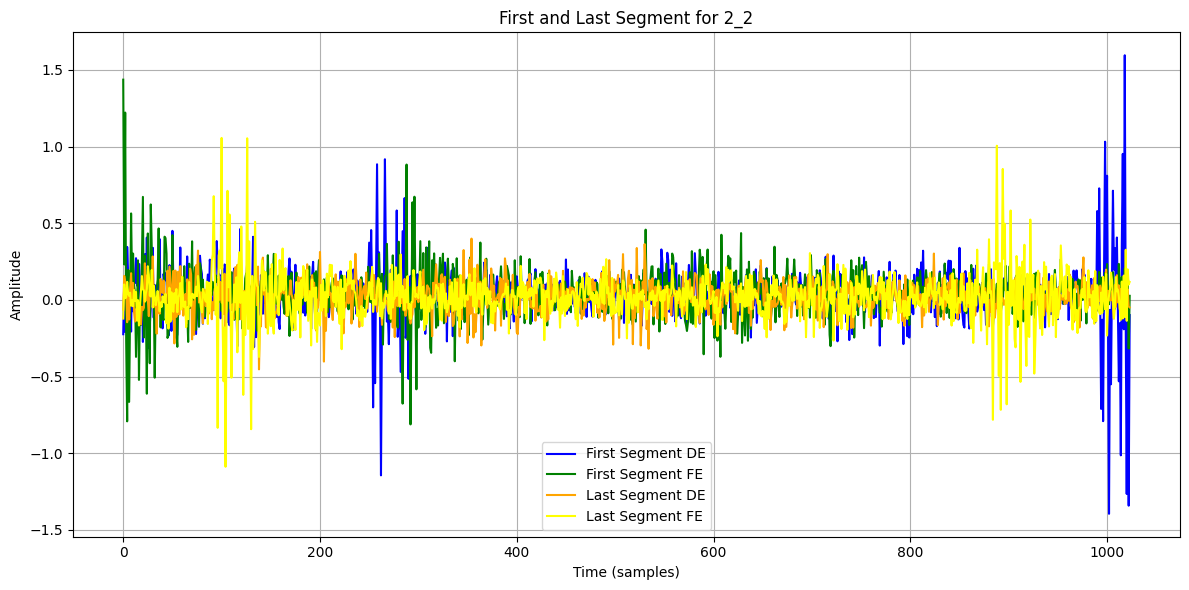

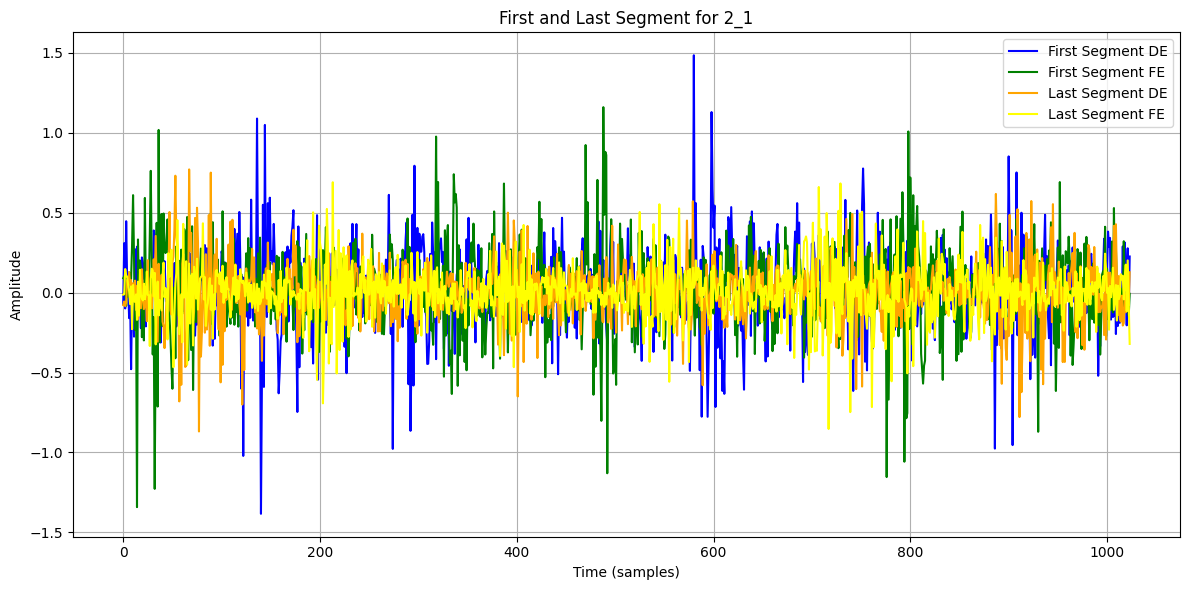

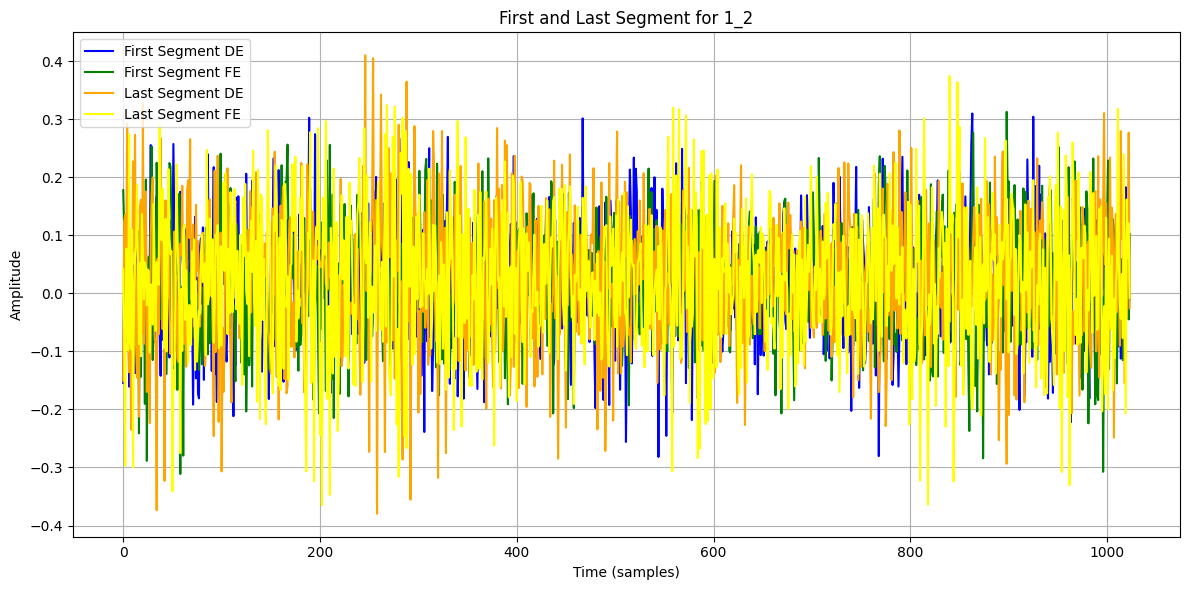

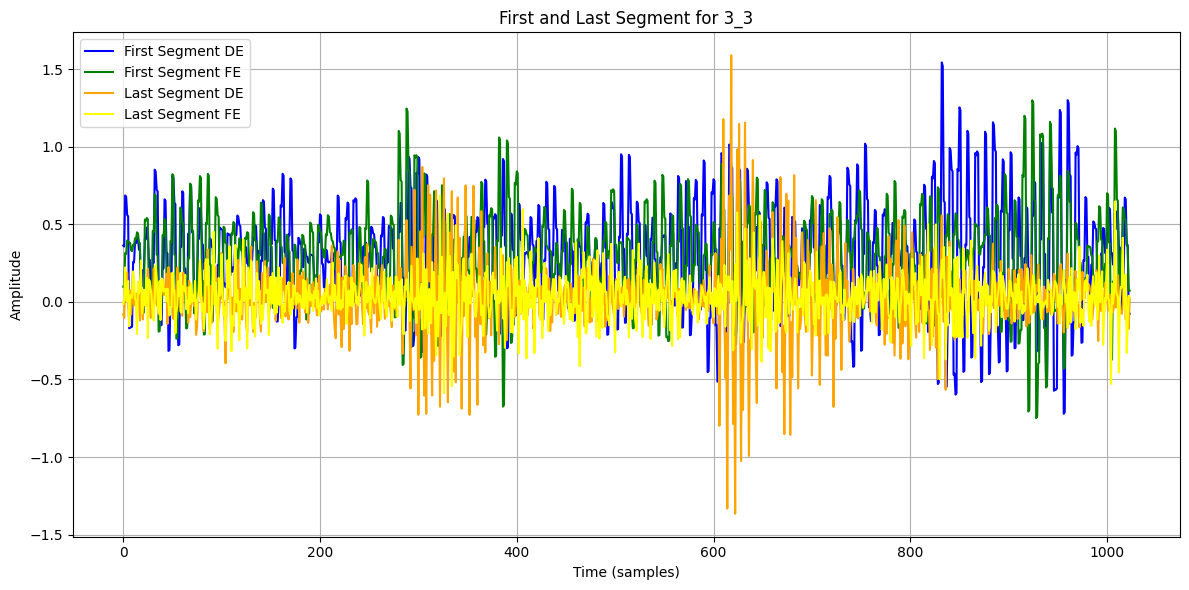

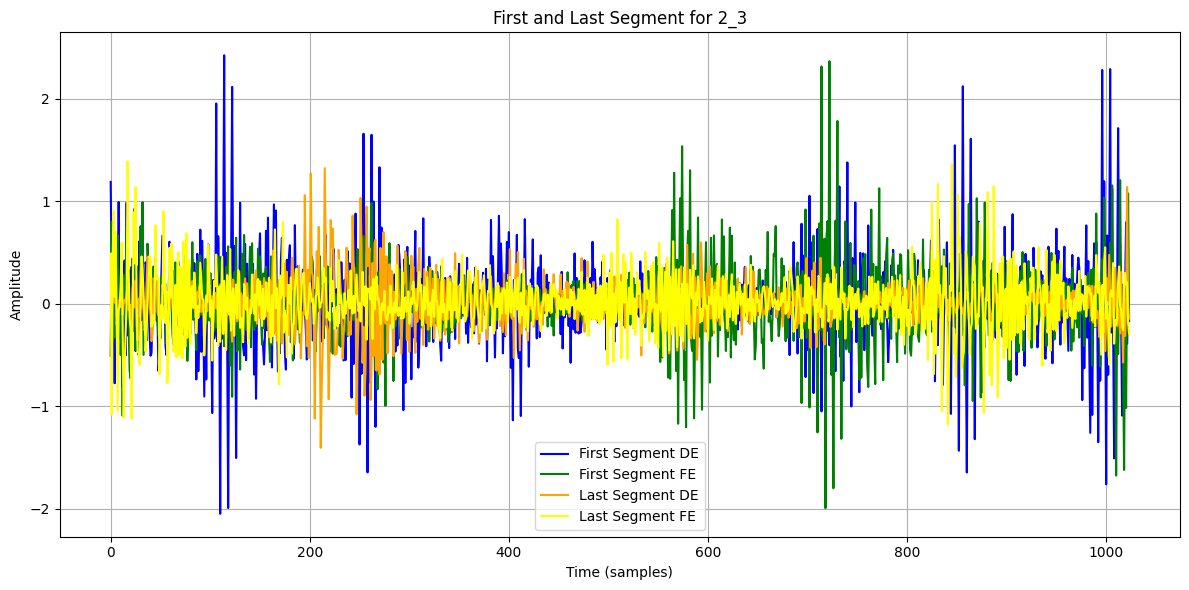

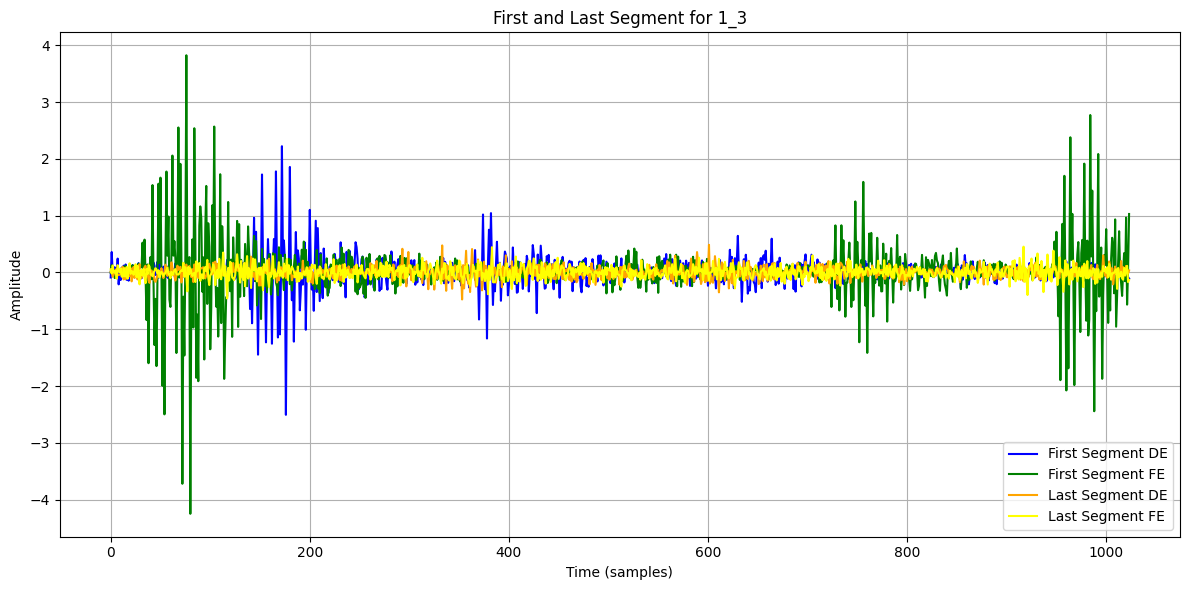

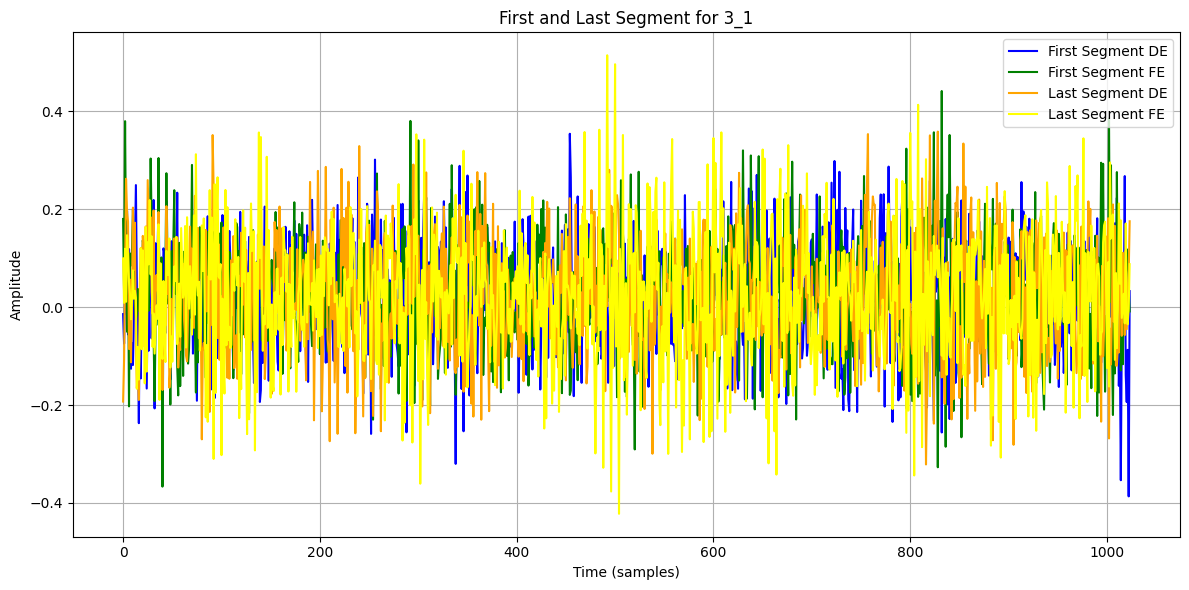

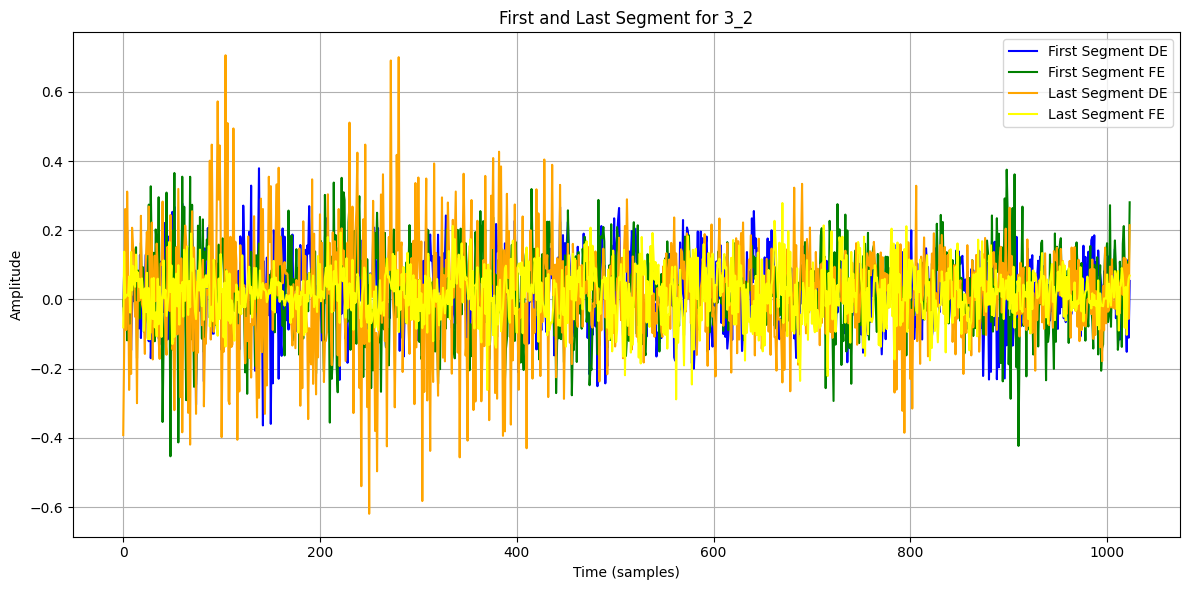

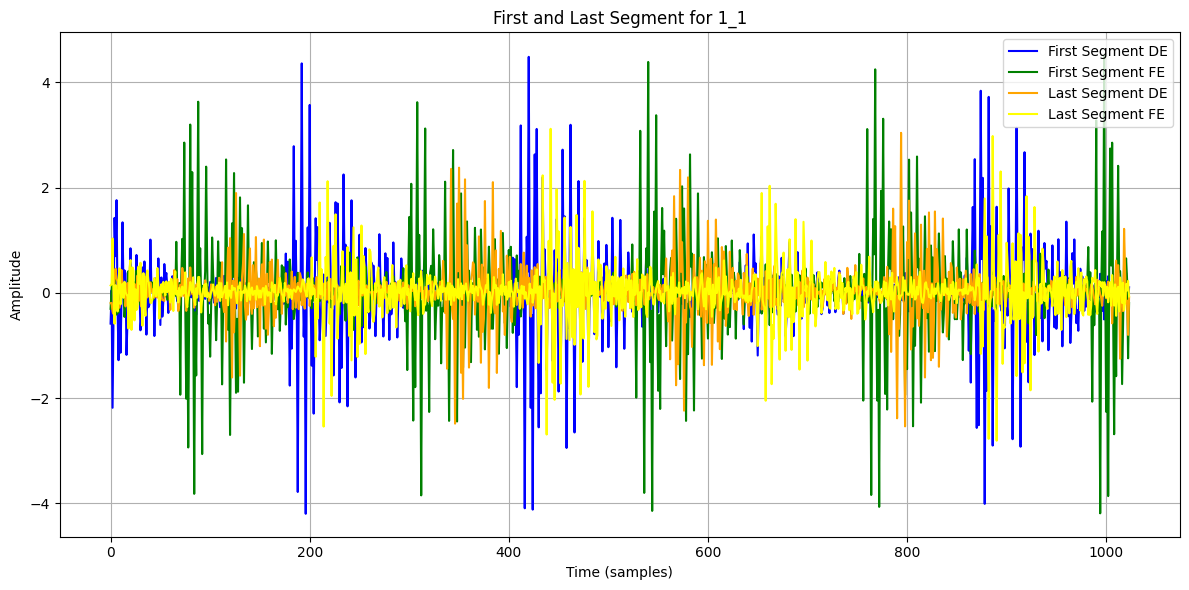

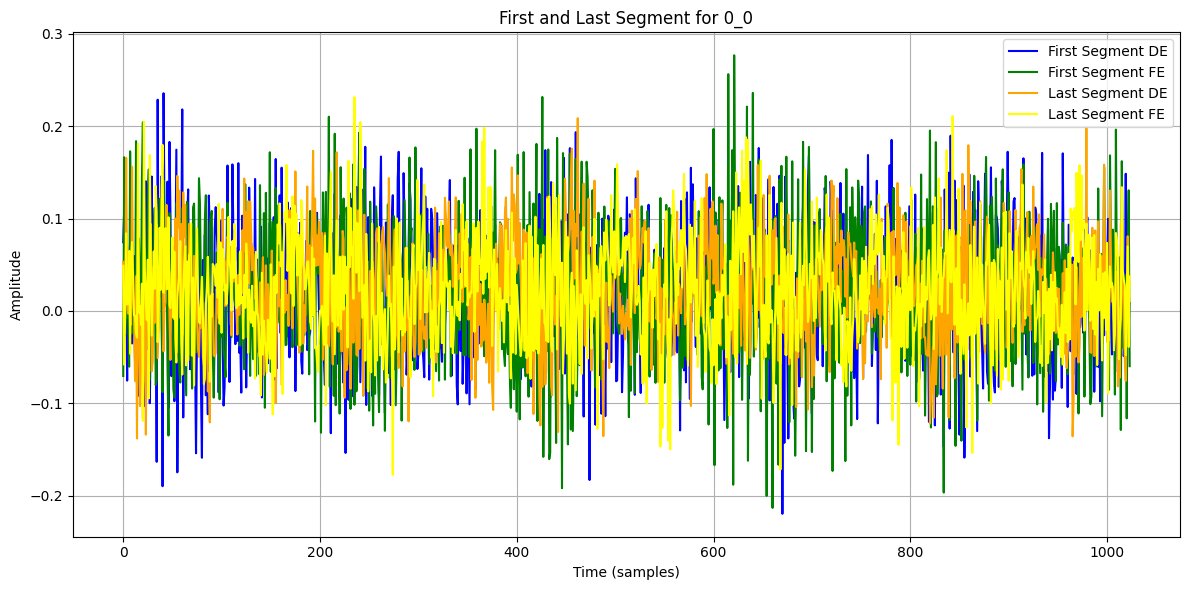

Data shape: X.shape = (5600, 2, 1024), y.shape = (5600, 5)


In [5]:
# 1. Set paths and mappings
# Mapping bearing codes to fault types and fault sizes - Take all data for DE with 48kHz sampling rate
fault_type_map = {
    "DE_48kHz": {
        '97': 0, '98': 0, '99': 0, '100': 0,      # Normal
        '135': 1, '136': 1, '137': 1, '138': 1,   # OR - 007
        '201': 1, '202': 1, '203': 1, '204': 1,   # OR - 014
        '238': 1, '239': 1, '240': 1, '241': 1,   # OR - 021
        '109': 2, '110': 2, '111': 2, '112': 2,   # IR - 007
        '174': 2, '175': 2, '176': 2, '177': 2,   # IR - 014
        '213': 2, '214': 2, '215': 2, '217': 2,   # IR - 021
        '122': 3, '123': 3, '124': 3, '125': 3,   # B - 007
        '189': 3, '190': 3, '191': 3, '192': 3,   # B - 014
        '226': 3, '227': 3, '228': 3, '229': 3,   # B - 021
    },
    "DE_12kHz": {
        '130': 1, '131': 1, '132': 1, '133': 1,   # OR - 007 6 oclock data
        '197': 1, '198': 1, '199': 1, '200': 1,   # OR - 014
        '234': 1, '235': 1, '236': 1, '237': 1,   # OR - 021
        '105': 2, '106': 2, '107': 2, '108': 2,   # IR - 007
        '169': 2, '170': 2, '171': 2, '172': 2,   # IR - 014
        '209': 2, '210': 2, '211': 2, '212': 2,   # IR - 021
        '118': 3, '119': 3, '120': 3, '121': 3,   # B - 007
        '185': 3, '186': 3, '187': 3, '188': 3,   # B - 014
        '222': 3, '223': 3, '224': 3, '225': 3,   # B - 021
    },
    "FE_12kHz": {
        '298': 1, '299': 1, '300': 1, '301': 1,   # FE OR - 007 3 o'clock;
        '309': 1, '310': 1, '311': 1, '312': 1,   # FE OR - 014
        '315': 1, '316': 1, '317': 1, '318': 1,   # FE OR - 021
        '278': 2, '279': 2, '280': 2, '281': 2,   # FE IR - 007
        '274': 2, '275': 2, '276': 2, '277': 2,   # FE IR - 014
        '270': 2, '271': 2, '272': 2, '273': 2,   # FE IR - 021 - 0HP is from @ 6 o'clock
        '282': 3, '283': 3, '284': 3, '285': 3,   # FE B - 007
        '286': 3, '287': 3, '288': 3, '289': 3,   # FE B - 014
        '290': 3, '291': 3, '292': 3, '293': 3    # FE B - 021
    }
}

fault_size_map = {
    "DE_48kHz": {
        '97': 0, '98': 0, '99': 0, '100': 0,      # Normal
        '135': 1, '136': 1, '137': 1, '138': 1,   # OR - 007
        '201': 2, '202': 2, '203': 2, '204': 2,   # OR - 014
        '238': 3, '239': 3, '240': 3, '241': 3,   # OR - 021
        '109': 1, '110': 1, '111': 1, '112': 1,   # IR - 007
        '174': 2, '175': 2, '176': 2, '177': 2,   # IR - 014
        '213': 3, '214': 3, '215': 3, '217': 3,   # IR - 021
        '122': 1, '123': 1, '124': 1, '125': 1,   # B - 007
        '189': 2, '190': 2, '191': 2, '192': 2,   # B - 014
        '226': 3, '227': 3, '228': 3, '229': 3,   # B - 021
    },
    "DE_12kHz": {
        '130': 1, '131': 1, '132': 1, '133': 1,   # OR - 007
        '197': 2, '198': 2, '199': 2, '200': 2,   # OR - 014
        '234': 3, '235': 3, '236': 3, '237': 3,   # OR - 021
        '105': 1, '106': 1, '107': 1, '108': 1,   # IR - 007
        '169': 2, '170': 2, '171': 2, '172': 2,   # IR - 014
        '209': 3, '210': 3, '211': 3, '212': 3,   # IR - 021
        '118': 1, '119': 1, '120': 1, '121': 1,   # B - 007
        '185': 2, '186': 2, '187': 2, '188': 2,   # B - 014
        '222': 3, '223': 3, '224': 3, '225': 3,   # B - 021
    },
    "FE_12kHz": {
        '298': 1, '299': 1, '300': 1, '301': 1,   # FE OR - 007
        '309': 2, '310': 2, '311': 2, '312': 2,   # FE OR - 014
        '315': 3, '316': 3, '317': 3, '318': 3,   # FE OR - 021
        '278': 1, '279': 1, '280': 1, '281': 1,   # FE IR - 007
        '274': 2, '275': 2, '276': 2, '277': 2,   # FE IR - 014
        '270': 3, '271': 3, '272': 3, '273': 3,   # FE IR - 021
        '282': 1, '283': 1, '284': 1, '285': 1,   # FE B - 007
        '286': 2, '287': 2, '288': 2, '289': 2,   # FE B - 014
        '290': 3, '291': 3, '292': 3, '293': 3    # FE B - 021
    }
}

fault_combination_map = {
    "DE_48kHz": {
        '97': 0, '98': 0, '99': 0, '100': 0,      # Normal
        '135': 1, '136': 1, '137': 1, '138': 1,   # OR - 007
        '201': 2, '202': 2, '203': 2, '204': 2,   # OR - 014
        '238': 3, '239': 3, '240': 3, '241': 3,   # OR - 021
        '109': 4, '110': 4, '111': 4, '112': 4,   # IR - 007
        '174': 5, '175': 5, '176': 5, '177': 5,   # IR - 014
        '213': 6, '214': 6, '215': 6, '217': 6,   # IR - 021
        '122': 7, '123': 7, '124': 7, '125': 7,   # B - 007
        '189': 8, '190': 8, '191': 8, '192': 8,   # B - 014
        '226': 9, '227': 9, '228': 9, '229': 9,   # B - 021
    },
    "DE_12kHz": {
        '130': 1, '131': 1, '132': 1, '133': 1,   # OR - 007
        '197': 2, '198': 2, '199': 2, '200': 2,   # OR - 014
        '234': 3, '235': 3, '236': 3, '237': 3,   # OR - 021
        '105': 4, '106': 4, '107': 4, '108': 4,   # IR - 007
        '169': 5, '170': 5, '171': 5, '172': 5,   # IR - 014
        '209': 6, '210': 6, '211': 6, '212': 6,   # IR - 021
        '118': 7, '119': 7, '120': 7, '121': 7,   # B - 007
        '185': 8, '186': 8, '187': 8, '188': 8,   # B - 014
        '222': 9, '223': 9, '224': 9, '225': 9,   # B - 021
    },
    "FE_12kHz": {
        '298': 1, '299': 1, '300': 1, '301': 1,   # FE OR - 007
        '309': 2, '310': 2, '311': 2, '312': 2,   # FE OR - 014
        '315': 3, '316': 3, '317': 3, '318': 3,   # FE OR - 021
        '278': 4, '279': 4, '280': 4, '281': 4,   # FE IR - 007
        '274': 5, '275': 5, '276': 5, '277': 5,   # FE IR - 014
        '270': 6, '271': 6, '272': 6, '273': 6,   # FE IR - 021
        '282': 7, '283': 7, '284': 7, '285': 7,   # FE B - 007
        '286': 8, '287': 8, '288': 8, '289': 8,   # FE B - 014
        '290': 9, '291': 9, '292': 9, '293': 9    # FE B - 021
    }
}
fault_size_mm_map = {
    "DE_48kHz": {
        '97': 0, '98': 0, '99': 0, '100': 0,      # Normal
        '135': 0.1778, '136': 0.1778, '137': 0.1778, '138': 0.1778,   # OR - 007
        '201': 0.3556, '202': 0.3556, '203': 0.3556, '204': 0.3556,   # OR - 014
        '238': 0.7112, '239': 0.7112, '240': 0.7112, '241': 0.7112,   # OR - 021
        '109': 0.1778, '110': 0.1778, '111': 0.1778, '112': 0.1778,   # IR - 007
        '174': 0.3556, '175': 0.3556, '176': 0.3556, '177': 0.3556,   # IR - 014
        '213': 0.7112, '214': 0.7112, '215': 0.7112, '217': 0.7112,   # IR - 021
        '122': 0.1778, '123': 0.1778, '124': 0.1778, '125': 0.1778,   # B - 007
        '189': 0.3556, '190': 0.3556, '191': 0.3556, '192': 0.3556,   # B - 014
        '226': 0.7112, '227': 0.7112, '228': 0.7112, '229': 0.7112,   # B - 021
    },
    "DE_12kHz": {
        '130': 0.1778, '131': 0.1778, '132': 0.1778, '133': 0.1778,   # OR - 007
        '197': 0.3556, '198': 0.3556, '199': 0.3556, '200': 0.3556,   # OR - 014
        '234': 0.7112, '235': 0.7112, '236': 0.7112, '237': 0.7112,   # OR - 021
        '105': 0.1778, '106': 0.1778, '107': 0.1778, '108': 0.1778,   # IR - 007
        '169': 0.3556, '170': 0.3556, '171': 0.3556, '172': 0.3556,   # IR - 014
        '209': 0.7112, '210': 0.7112, '211': 0.7112, '212': 0.7112,   # IR - 021
        '118': 0.1778, '119': 0.1778, '120': 0.1778, '121': 0.1778,   # B - 007
        '185': 0.3556, '186': 0.3556, '187': 0.3556, '188': 0.3556,   # B - 014
        '222': 0.7112, '223': 0.7112, '224': 0.7112, '225': 0.7112,   # B - 021
    },
    "FE_12kHz": {
        '298': 0.1778, '299': 0.1778, '300': 0.1778, '301': 0.1778,   # FE OR - 007
        '309': 0.3556, '310': 0.3556, '311': 0.3556, '312': 0.3556,   # FE OR - 014
        '315': 0.7112, '316': 0.7112, '317': 0.7112, '318': 0.7112,   # FE OR - 021
        '278': 0.1778, '279': 0.1778, '280': 0.1778, '281': 0.1778,   # FE IR - 007
        '274': 0.3556, '275': 0.3556, '276': 0.3556, '277': 0.3556,   # FE IR - 014
        '270': 0.7112, '271': 0.7112, '272': 0.7112, '273': 0.7112,   # FE IR - 021
        '282': 0.1778, '283': 0.1778, '284': 0.1778, '285': 0.1778,   # FE B - 007
        '286': 0.3556, '287': 0.3556, '288': 0.3556, '289': 0.3556,   # FE B - 014
        '290': 0.7112, '291': 0.7112, '292': 0.7112, '293': 0.7112    # FE B - 021
    }
}

# Collect all .mat files matching file codes with sampling rate info
file_list = []

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.mat'):
            file_code = os.path.splitext(file)[0]  # Extract file code, e.g., '130'
            for group_key, group in fault_type_map.items():
                if file_code in group:
                    full_path = os.path.join(root, file)
                    file_list.append((full_path, file_code, group_key))
                    break  # Stop searching once matched

print(f"Found {len(file_list)} matching files.")

# Process the dataset
seq_len = 1024     # maintain 1024 for DL training - must be set later for INPUT_DIM also
threshold = 50    # 234 max for 24kHz dataset of 5s / 58 max downsampled to 12kHz
sampling_rate_target = 12000  # Target sampling rate (12000)

# -----------------------------
# Load and Balance Signals
# -----------------------------
X, y = process_dataset_alldata(file_list, fault_type_map, fault_size_map, fault_size_mm_map, fault_combination_map,
                        channel_num=3, seq_len=seq_len, threshold=threshold, sampling_rate_target=sampling_rate_target)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# You can now plot the first and last segments for visualization as well
plot_fault_segments(X, y, seq_len)

# count_val(y)
print(f"Data shape: X.shape = {X.shape}, y.shape = {y.shape}")

In [6]:
import numpy as np
from collections import Counter

# Convert y rows (lists) to tuples for hashing
y_tuples = [tuple(row) for row in y]

# Count occurrences of each unique combination
label_counts = Counter(y_tuples)

# Print results
print("Unique labels and their counts:\n")
for label, count in label_counts.items():
    print(f"{label}: {count}")


Unique labels and their counts:

(1, 2, 2, 5, 0.3556): 600
(1, 2, 1, 4, 0.1778): 600
(1, 1, 2, 2, 0.3556): 600
(1, 3, 3, 9, 0.7112): 600
(1, 2, 3, 6, 0.7112): 600
(1, 1, 3, 3, 0.7112): 600
(1, 3, 1, 7, 0.1778): 600
(1, 3, 2, 8, 0.3556): 600
(1, 1, 1, 1, 0.1778): 600
(0, 0, 0, 0, 0): 200


### **Split datasets to train and test tensors**

**Split and convert to tensor:**

Prepare dataset for next step.

Original X shape: (5600, 2, 1024)
Scaled X shape: (5600, 2, 1024)
Train: torch.Size([3584, 2, 1024]) torch.Size([3584, 5])
Val  : torch.Size([896, 2, 1024]) torch.Size([896, 5])
Test : torch.Size([1120, 2, 1024]) torch.Size([1120, 5])

Train Category Counts:
   check_label type_label size_label type_size_label  count
0      Normal     Normal          0        Normal_0    128
1      Faulty         OR        007          OR_007    384
2      Faulty         OR        014          OR_014    384
3      Faulty         OR        021          OR_021    384
4      Faulty         IR        007          IR_007    384
5      Faulty         IR        014          IR_014    384
6      Faulty         IR        021          IR_021    384
7      Faulty          B        007           B_007    384
8      Faulty          B        014           B_014    384
9      Faulty          B        021           B_021    384
Val Category Counts:
   check_label type_label size_label type_size_label  count
0      Nor

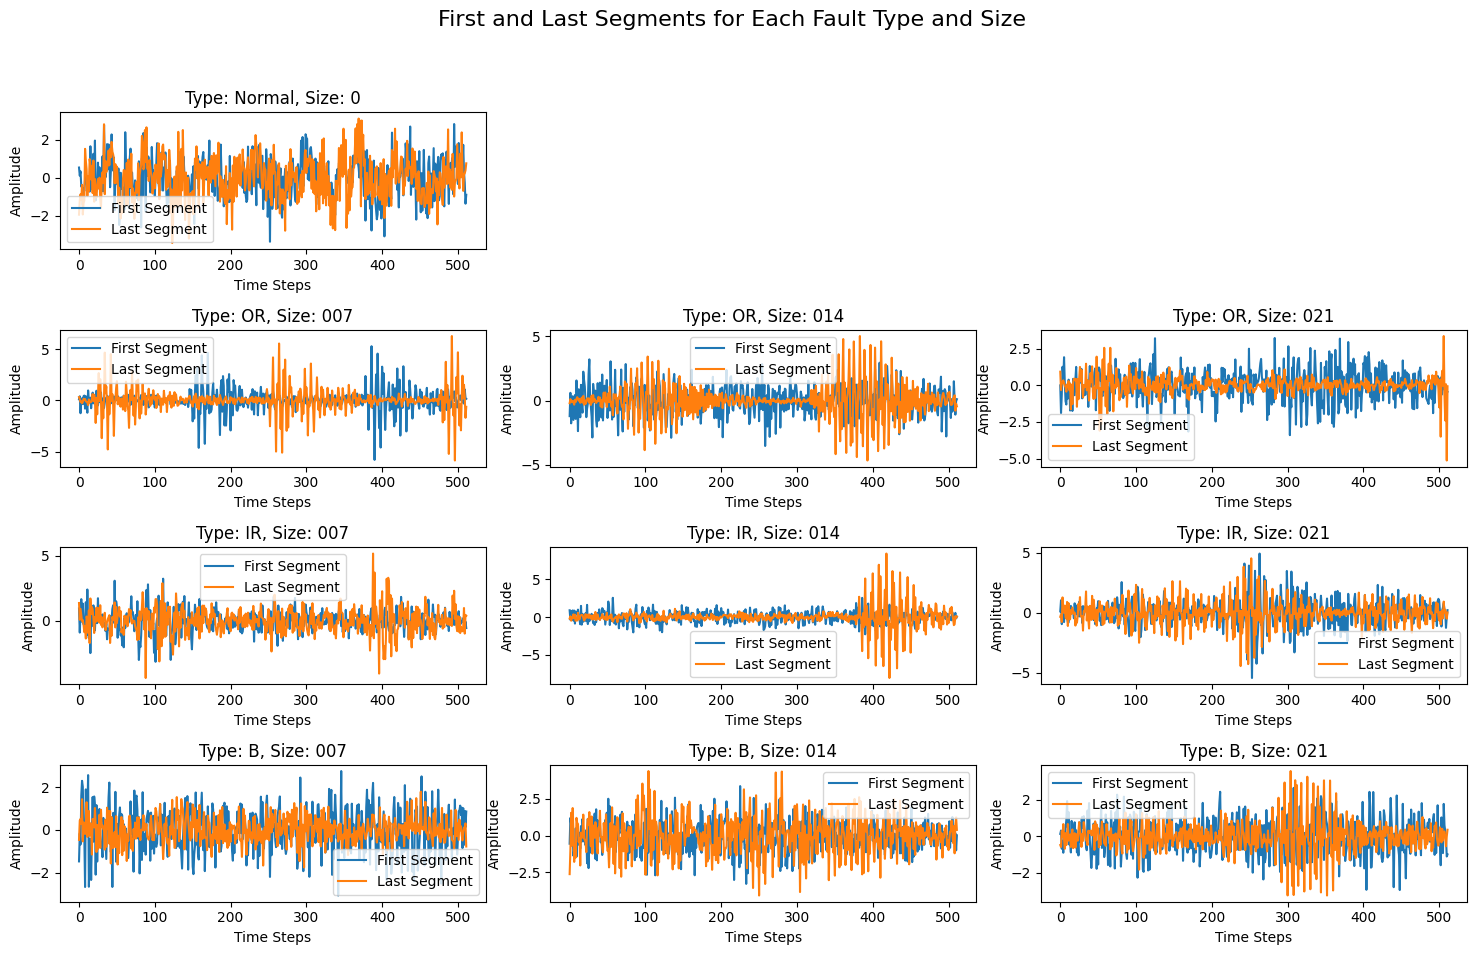


=== Plotting Channel: 1 ===


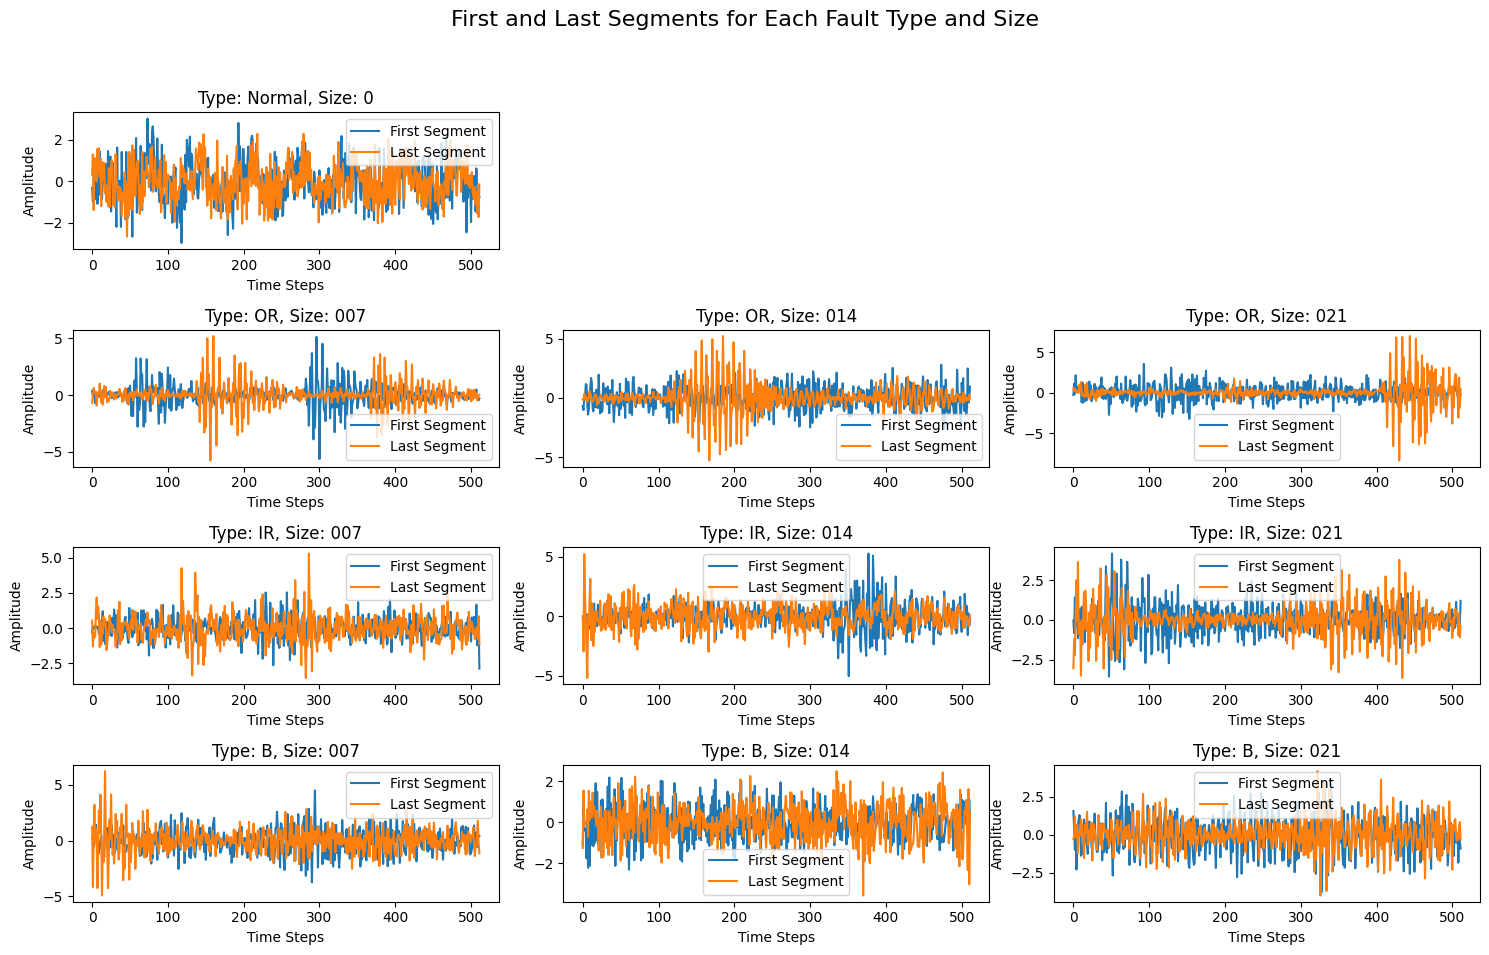

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# -----------------------------
# Functions
# -----------------------------
def count_val(y):
    df = pd.DataFrame(y)  # Create DataFrame from y
    groups = df.groupby(list(df.columns)).size().reset_index(name='count')
    print(groups)

def to_tensor(X, y):
    """
    Converts the input data (X and y) to PyTorch tensors.

    Parameters:
    - X (np.ndarray): Input feature data with shape [N, 3, L], where N is the number of samples,
                       3 is the number of channels (X, Y, Z), and L is the length of each segment.
    - y (np.ndarray): Target data (labels) that will be converted to a tensor.

    Returns:
    - X_tensor (torch.Tensor): Tensor representation of the input features with shape [N, 3, L].
    - y_tensor (torch.Tensor): Tensor representation of the target labels.
    """
    # Ensure X has shape [N, 3, L], corresponding to 3 channels (X, Y, Z) and segment length L
    if X.ndim == 2:  # If only 1 channel (e.g., [N, L]) is given, repeat across 3 channels
        X = np.repeat(X[:, np.newaxis, :], 3, axis=1)  # Repeat along the channel dimension to create 3 channels

    # Convert X to tensor with shape [N, 3, L]
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Ensure float32 type for model compatibility

    # Convert y to a proper numeric type (float32 if regression, or integer if classification)
    y = np.array(y, dtype=np.float32)  # Modify this if y needs to be integer for classification

    # Convert y to tensor
    y_tensor = torch.tensor(y, dtype=torch.float32)

    return X_tensor, y_tensor

# -----------------------------
# Normalize Signals
# -----------------------------
scaler = StandardScaler()

# Normalize each channel independently and preserve the shape [N, 3, L]
X_scaled = np.zeros_like(X, dtype=np.float32)  # Create an array to store scaled values

for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each channel (X, Y, Z)
        X_scaled[i, j, :] = scaler.fit_transform(X[i, j, :].reshape(-1, 1)).flatten()

# -----------------------------
# Check the new shape of X_scaled
# -----------------------------
print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")

# -----------------------------
# Padding
# -----------------------------
max_len = max(len(x) for x in X_scaled)
X_padded = np.array([np.pad(x, (0, max_len - len(x))) for x in X_scaled])

# -----------------------------
# Create Combined Labels for Stratification
# -----------------------------
combined_labels = [f"{int(t)}_{int(s)}" for t, s in zip(y[:, 1], y[:, 2])]
# combined_labels = y[:, 3]

# -----------------------------
# Train/Test Split (80/20)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, stratify=combined_labels, random_state=42
)

# -----------------------------
# Train/Validation Split (80/20 of Train)
# -----------------------------
combined_labels_train = [f"{int(t)}_{int(s)}" for t, s in zip(y_train[:, 1], y_train[:, 2])]
# combined_labels_train = y_train[:, 3]
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=combined_labels_train, random_state=42
)

# -----------------------------
# Convert to PyTorch Tensors
# -----------------------------
X_train_tensor, y_train_tensor = to_tensor(X_train_split, y_train_split)
X_val_tensor, y_val_tensor = to_tensor(X_val_split, y_val_split)
X_test_tensor, y_test_tensor = to_tensor(X_test, y_test)

# -----------------------------
# Debug Prints
# -----------------------------
print("Train:", X_train_tensor.shape, y_train_tensor.shape)
print("Val  :", X_val_tensor.shape, y_val_tensor.shape)
print("Test :", X_test_tensor.shape, y_test_tensor.shape)

# -----------------------------
# Confusion Matrix labels
# -----------------------------
fault_check_map = {'Normal': 0, 'Faulty': 1}                # y[:0]
fault_type_map = {'Normal': 0, 'OR': 1, 'IR': 2, 'B': 3}    # y[:1]
fault_size_cls_map = {                                      # y[:2]
    '0': 0,
    '007': 1, '014': 2, '021': 3
}
fault_type_size_map = {                                     # y[:3]
    'Normal_0': 0,
    'OR_007': 1, 'OR_014': 2, 'OR_021': 3,
    'IR_007': 4, 'IR_014': 5,  'IR_021': 6,
    'B_007': 7, 'B_014': 8,  'B_021': 9,
}
fault_size_reg_map = {                                      # y[:4] in mm
    '0': 0,
    '0.18mm': 0.1778, '0.36mm': 0.3556, '0.71mm': 0.7112
}

# -----------------------------
# Optional: Category Counts
# -----------------------------
col_nums = [0, 1, 2, 3]
col_labels = ['fault_check', 'fault_type', 'fault_size', 'fault_type_size']
train_counts = category_counts_for_set(X_train_split, y_train_split, col_nums, col_labels)
val_counts = category_counts_for_set(X_val_split, y_val_split, col_nums, col_labels)
test_counts = category_counts_for_set(X_test, y_test, col_nums, col_labels)

print("\nTrain Category Counts:\n", train_counts)
print("Val Category Counts:\n", val_counts)
print("Test Category Counts:\n", test_counts)

# -----------------------------
# Optional: Plot Segments
# -----------------------------
unique_fault_types = np.unique(y[:, 1])
fault_type_sizes = {0: [0], 1: [1, 2, 3], 2: [1, 2, 3], 3: [1, 2, 3]}

num_channels = X_padded.shape[1]

for ch_idx in range(num_channels):
    print(f"\n=== Plotting Channel: {ch_idx} ===")

    # Slice channel-specific data: (num_samples, segment_length)
    X_channel = X_padded[:, ch_idx, :]

    # Reduce the length for plotting
    reduced_X_channel = X_channel[:, :X_channel.shape[1] // 2]

    # Call your existing plot_segments function with the reduced data
    plot_segments(reduced_X_channel, y, unique_fault_types, fault_type_sizes, fault_type_map, fault_size_cls_map)


In [7]:
if environment == 'Colab':
    try:
        from google.colab import userdata
        api_key = userdata.get("wandb_api")
        wandb.login(key=api_key)
        anony = None
    except:
        anony = "must"
        print('Error setting secret in Colab')

elif environment == 'Kaggle':
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("wandb_api")
        wandb.login(key=api_key)
        anony = None
    except:
        anony = "must"
        print('Error setting secret in Kaggle')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sufian79 (sufian79-utm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
# wand settings - Shared project and entity
WANDB_ENTITY = "sufian79-utm"
WANDB_PROJECT = "PyTorch_Multi_IO_CWRU_All_Data"
WANDB_GROUP =  "Notebook_1"   # change for each notebook: Notebook_2, Notebook_3, etc.
WANDB_DATASET = "CWRU_All_Data"

# Universal parameters
ZIP_NAME = 'CWRU_All_Data-Base_1-3'
INPUT_DIM = seq_len
INPUT_CHANNELS = 2
NUM_TYPE_CLASSES = 4         # Fault type classification (e.g., ['ball', 'inner', 'outer'])
NUM_SIZE_CLASSES = 4         # Fault size classification (e.g., [0, 7, 14, 21, 28, 35, 48])
NUM_TYPE_SIZE_CLASSES = 10   # Combined fault type + size classes (e.g., ball_7, inner_14, ...)

# ============================================================
# ⚙️ MODEL & TRAINING CONSTANTS
# ============================================================
BATCH_SIZE = 128
NUM_WORKERS = 2
EPOCHS = 30
LEARNING_RATE = 1e-4
OPTIMIZER_CHOICE = 'Adam'   # Options: ['Adam', 'AdamW', 'SGD', 'RMSprop']
WEIGHT_DECAY = 1e-4          # L2 regularization factor
SCHEDULER_FACTOR = 0.3       # LR reduction factor on plateau
SCHEDULER_PATIENCE = 3       # Epochs to wait before reducing LR
SCHEDULER_MODE = 'min'       # Options: ['min', 'max']
MAX_GRAD_NORM = 1.0          # Max gradient norm for clipping
INIT_MODE='xavier'           # One of ['xavier', 'kaiming', 'orthogonal', 'normal'].
DROPOUT_RATE=0.2             # 0.2, 0.3
EARLY_PATIENCE=5

# -----------------------------
# DataLoaders sample call
# -----------------------------
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

# Enable cuDNN benchmark mode
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Example debug print to inspect fault size distribution in each dataset
for name, y_y in zip(['Train', 'Val', 'Test'], [y_train, y_val_split, y_test]):
    print(f"{name} set distribution:", dict(zip(*np.unique(y_y, return_counts=True))))


Train set distribution: {0: np.int64(800), 0.1778: np.int64(1440), 0.3556: np.int64(1440), 0.7112: np.int64(1440), 1: np.int64(7680), 2: np.int64(3360), 3: np.int64(3360), 4: np.int64(480), 5: np.int64(480), 6: np.int64(480), 7: np.int64(480), 8: np.int64(480), 9: np.int64(480)}
Val set distribution: {0: np.int64(160), 0.1778: np.int64(288), 0.3556: np.int64(288), 0.7112: np.int64(288), 1: np.int64(1536), 2: np.int64(672), 3: np.int64(672), 4: np.int64(96), 5: np.int64(96), 6: np.int64(96), 7: np.int64(96), 8: np.int64(96), 9: np.int64(96)}
Test set distribution: {0: np.int64(200), 0.1778: np.int64(360), 0.3556: np.int64(360), 0.7112: np.int64(360), 1: np.int64(1920), 2: np.int64(840), 3: np.int64(840), 4: np.int64(120), 5: np.int64(120), 6: np.int64(120), 7: np.int64(120), 8: np.int64(120), 9: np.int64(120)}


### MLP (Baseline)


✅ Epoch 1/30 Completed:
Train Loss: 1.5405, Val Loss: 1.2517
Train - Avg. Score: -0.4178, Type Acc: 0.3076, Size Acc: 0.2665, Type & Size Acc: 0.1062, R2 - Size: -1.8815
Validation - Avg. Score: 0.0328, Type Acc: 0.3449, Size Acc: 0.3605, Type $ Size Acc: 0.1373, R2 - Size: -0.4983

✅ Epoch 2/30 Completed:
Train Loss: 1.3333, Val Loss: 1.1566
Train - Avg. Score: -0.1282, Type Acc: 0.3442, Size Acc: 0.3473, Type & Size Acc: 0.1319, R2 - Size: -1.0203
Validation - Avg. Score: 0.1063, Type Acc: 0.3717, Size Acc: 0.4297, Type $ Size Acc: 0.1886, R2 - Size: -0.3686

✅ Epoch 3/30 Completed:
Train Loss: 1.2409, Val Loss: 1.0913
Train - Avg. Score: -0.0574, Type Acc: 0.3705, Size Acc: 0.3904, Type & Size Acc: 0.1672, R2 - Size: -0.8658
Validation - Avg. Score: 0.1778, Type Acc: 0.4208, Size Acc: 0.4754, Type $ Size Acc: 0.2511, R2 - Size: -0.2559

✅ Epoch 4/30 Completed:
Train Loss: 1.1809, Val Loss: 1.0373
Train - Avg. Score: -0.0049, Type Acc: 0.3897, Size Acc: 0.4112, Type & Size Acc: 0.20


📂 Model saved to /content/output/PyTorch/dict_models/MLP1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/MLP1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/MLP1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/MLP1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/MLP1D_pt/Confusion_Matrix_-_Fault_Type.png


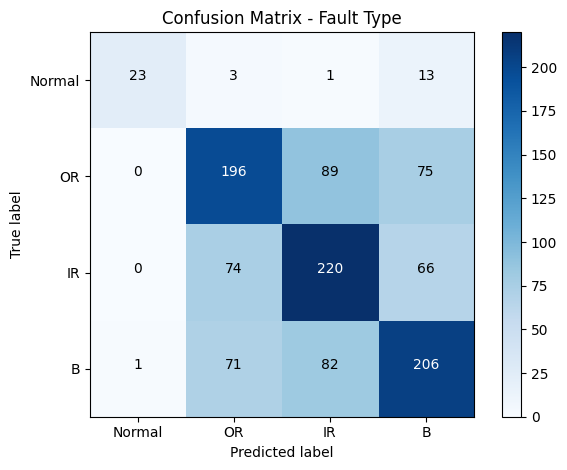

Plot saved to: /content/output/PyTorch/cf/MLP1D_pt/Confusion_Matrix_-_Fault_Size.png


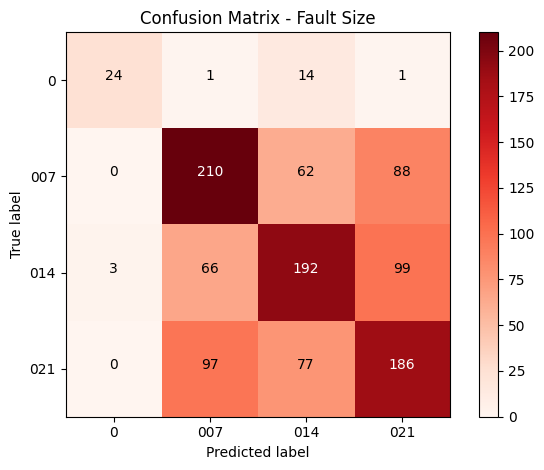

Plot saved to: /content/output/PyTorch/cf/MLP1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


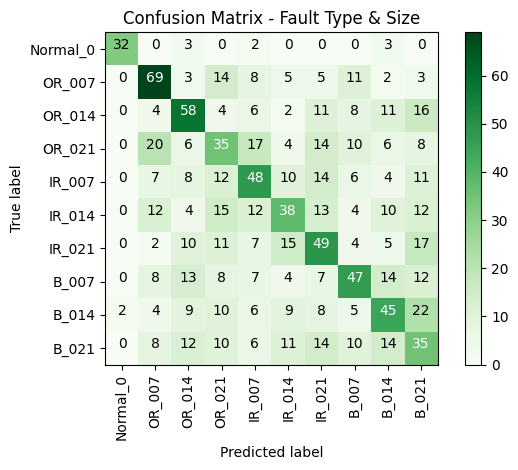


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.5759
  ➤ Fault Size Accuracy: 0.5464
  ➤ Fault Type Size Accuracy: 0.4071
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.5766
  ➤ F1 Score - Fault Size: 0.5475
  ➤ F1 Score - Fault Type & Size: 0.4078
  ➤ FLOPs: 0.56 MFLOPs
  ➤ Params: 0.56 M
  ➤ Model Size: 2.14 MB
Plot saved to: /content/output/PyTorch/cf/MLP1D_pt/Predicted_vs._True_Fault_Size.png


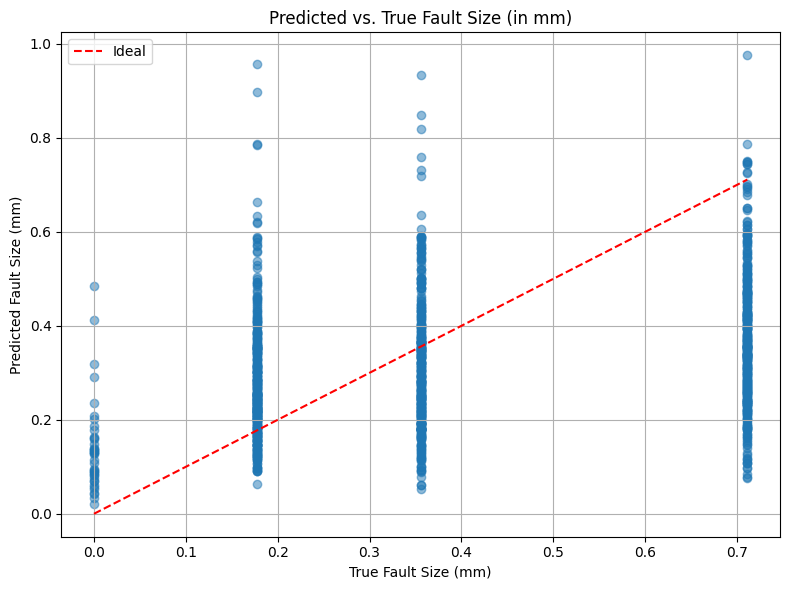


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0613
Root Mean Squared Error (RMSE): 0.2476
Mean Absolute Error (MAE): 0.1926
R2 Score: -0.1490
Mean Absolute Percentage Error (MAPE): 22447699533122.3086


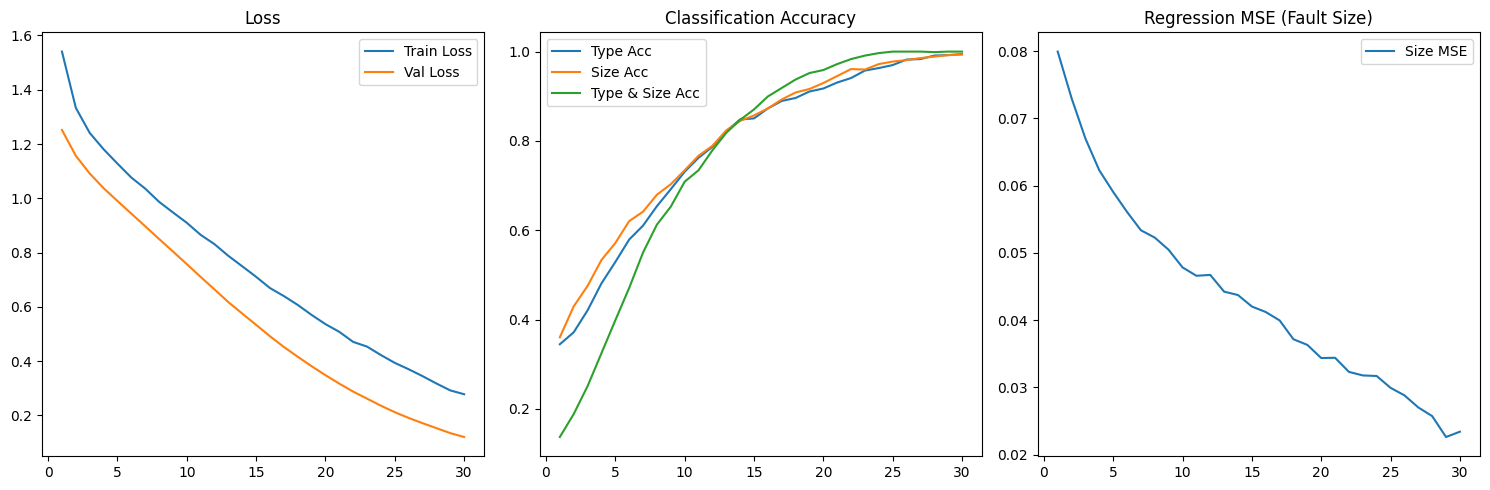

In [10]:
# ============================================================
# ⚙️ MLP
# ============================================================

mlp_model = bm.MLP1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                                     num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                                     init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                                    ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'MLP1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
mlp_history, mlp_metrics = train_evaluate_model_pt(
        model=mlp_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
# print(mlp_metrics)
plot_training_results(mlp_history)

## 3.1. Base Models

### 1. CNN


✅ Epoch 1/30 Completed:
Train Loss: 1.2808, Val Loss: 1.1499
Train - Avg. Score: -0.1138, Type Acc: 0.3355, Size Acc: 0.3232, Type & Size Acc: 0.1201, R2 - Size: -0.9386
Validation - Avg. Score: 0.1360, Type Acc: 0.4766, Size Acc: 0.4297, Type $ Size Acc: 0.2076, R2 - Size: -0.3583

✅ Epoch 2/30 Completed:
Train Loss: 1.1377, Val Loss: 1.0325
Train - Avg. Score: 0.0647, Type Acc: 0.4460, Size Acc: 0.3964, Type & Size Acc: 0.2051, R2 - Size: -0.5510
Validation - Avg. Score: 0.1874, Type Acc: 0.5379, Size Acc: 0.4676, Type $ Size Acc: 0.3516, R2 - Size: -0.3974

✅ Epoch 3/30 Completed:
Train Loss: 1.0464, Val Loss: 0.9172
Train - Avg. Score: 0.1202, Type Acc: 0.5147, Size Acc: 0.4583, Type & Size Acc: 0.3036, R2 - Size: -0.5515
Validation - Avg. Score: 0.2793, Type Acc: 0.6083, Size Acc: 0.6094, Type $ Size Acc: 0.4844, R2 - Size: -0.3650

✅ Epoch 4/30 Completed:
Train Loss: 0.9556, Val Loss: 0.8016
Train - Avg. Score: 0.1534, Type Acc: 0.5719, Size Acc: 0.5252, Type & Size Acc: 0.3699,


📂 Model saved to /content/output/PyTorch/dict_models/CNN1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/CNN1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/CNN1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/CNN1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/CNN1D_pt/Confusion_Matrix_-_Fault_Type.png


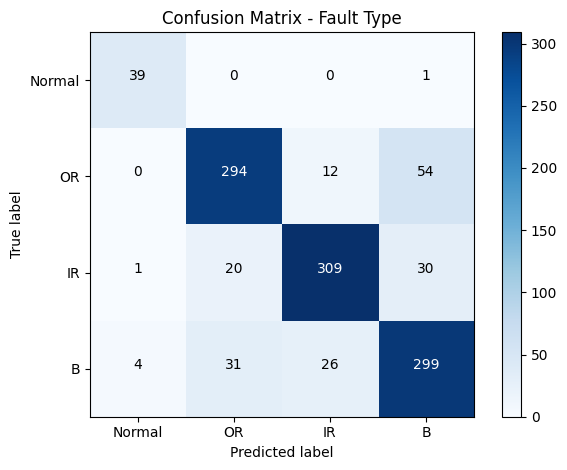

Plot saved to: /content/output/PyTorch/cf/CNN1D_pt/Confusion_Matrix_-_Fault_Size.png


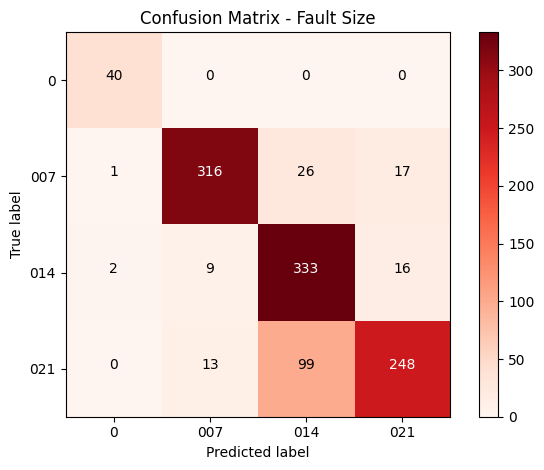

Plot saved to: /content/output/PyTorch/cf/CNN1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


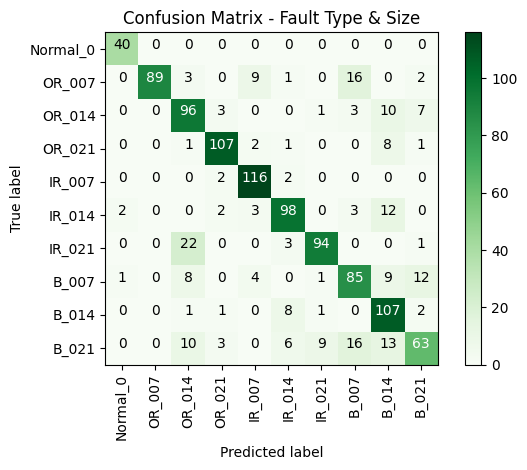


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.8402
  ➤ Fault Size Accuracy: 0.8366
  ➤ Fault Type Size Accuracy: 0.7991
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.8406
  ➤ F1 Score - Fault Size: 0.8359
  ➤ F1 Score - Fault Type & Size: 0.7977
  ➤ FLOPs: 14.06 MFLOPs
  ➤ Params: 4.26 M
  ➤ Model Size: 16.27 MB
Plot saved to: /content/output/PyTorch/cf/CNN1D_pt/Predicted_vs._True_Fault_Size.png


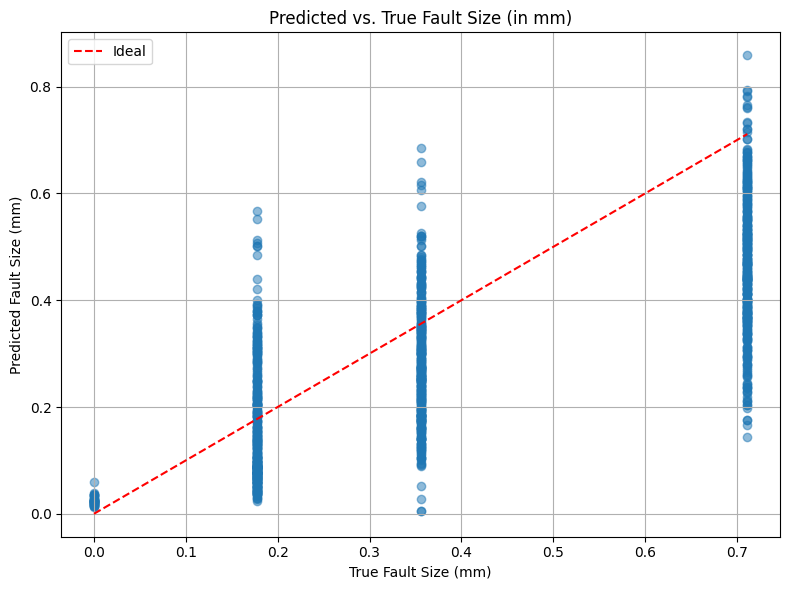


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0352
Root Mean Squared Error (RMSE): 0.1876
Mean Absolute Error (MAE): 0.1482
R2 Score: 0.3401
Mean Absolute Percentage Error (MAPE): 4041399157204.5010
{'model': 'CNN1D_pt', 'train_time': 30.479906797409058, 'inference_time': 0.3185589398656573, 'model_size': 16.273761749267578, 'total_flops': 14060032, 'total_params': 4261620, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.8401785714285714, 'fault_size_acc': 0.8366071428571429, 'fault_type_size_acc': 0.7991071428571429, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.8405667579385225, 'fault_size_f1': 0.8358785529627862, 'fault_type_size_f1': 0.7977281081876845, 'fault_size_mse': 0.0352050750798798, 'fault_size_rmse': np.float64(0.18763015503878847), 'fault_size_mae': 0.14822180722632247, 'fault_size_r2': 0.3400698329810671, 'fault_size_mape': 4041399157204.501}


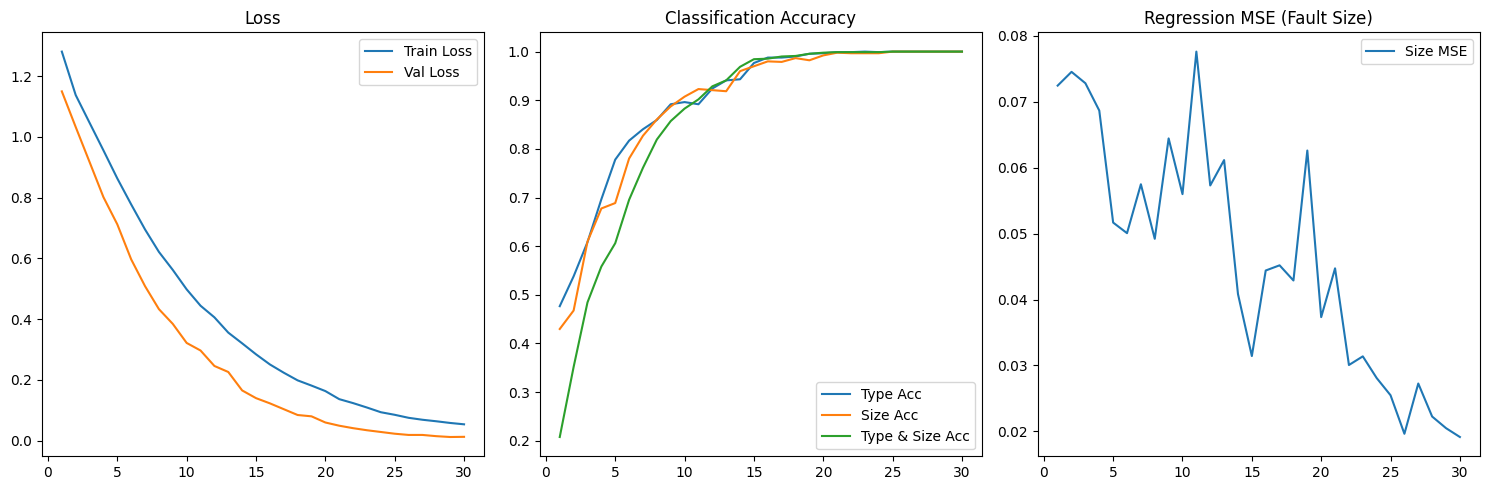

In [11]:
# ============================================================
# ⚙️ CNN
# ============================================================

cnn_model = bm.CNN1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                     num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                     init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                    ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'CNN1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
cnn_history, cnn_metrics = train_evaluate_model_pt(
        model=cnn_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(cnn_metrics)
plot_training_results(cnn_history)

### 2. ResNet


✅ Epoch 1/30 Completed:
Train Loss: 1.2289, Val Loss: 1.1663
Train - Avg. Score: 0.1222, Type Acc: 0.3598, Size Acc: 0.3279, Type & Size Acc: 0.1471, R2 - Size: -0.1981
Validation - Avg. Score: 0.2258, Type Acc: 0.4442, Size Acc: 0.3850, Type $ Size Acc: 0.2221, R2 - Size: -0.0221

✅ Epoch 2/30 Completed:
Train Loss: 1.1352, Val Loss: 1.0674
Train - Avg. Score: 0.1972, Type Acc: 0.4875, Size Acc: 0.3770, Type & Size Acc: 0.2279, R2 - Size: -0.1469
Validation - Avg. Score: 0.3267, Type Acc: 0.6596, Size Acc: 0.4955, Type $ Size Acc: 0.3638, R2 - Size: -0.0449

✅ Epoch 3/30 Completed:
Train Loss: 1.0575, Val Loss: 0.9684
Train - Avg. Score: 0.2424, Type Acc: 0.5469, Size Acc: 0.4261, Type & Size Acc: 0.3172, R2 - Size: -0.1578
Validation - Avg. Score: 0.3873, Type Acc: 0.6853, Size Acc: 0.5536, Type $ Size Acc: 0.4520, R2 - Size: 0.0131

✅ Epoch 4/30 Completed:
Train Loss: 0.9675, Val Loss: 0.8590
Train - Avg. Score: 0.2903, Type Acc: 0.6105, Size Acc: 0.4879, Type & Size Acc: 0.4194, R


📂 Model saved to /content/output/PyTorch/dict_models/ResNet1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/ResNet1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/ResNet1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/ResNet1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/ResNet1D_pt/Confusion_Matrix_-_Fault_Type.png


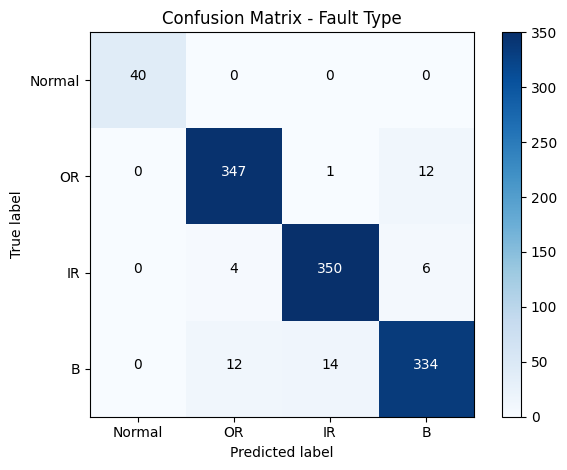

Plot saved to: /content/output/PyTorch/cf/ResNet1D_pt/Confusion_Matrix_-_Fault_Size.png


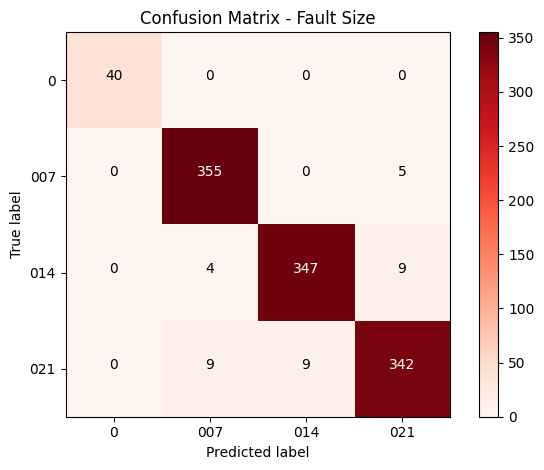

Plot saved to: /content/output/PyTorch/cf/ResNet1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


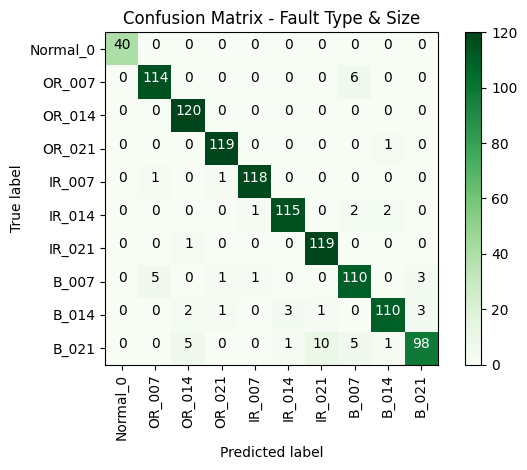


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.9563
  ➤ Fault Size Accuracy: 0.9679
  ➤ Fault Type Size Accuracy: 0.9491
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.9562
  ➤ F1 Score - Fault Size: 0.9678
  ➤ F1 Score - Fault Type & Size: 0.9485
  ➤ FLOPs: 35.52 MFLOPs
  ➤ Params: 0.18 M
  ➤ Model Size: 0.71 MB
Plot saved to: /content/output/PyTorch/cf/ResNet1D_pt/Predicted_vs._True_Fault_Size.png


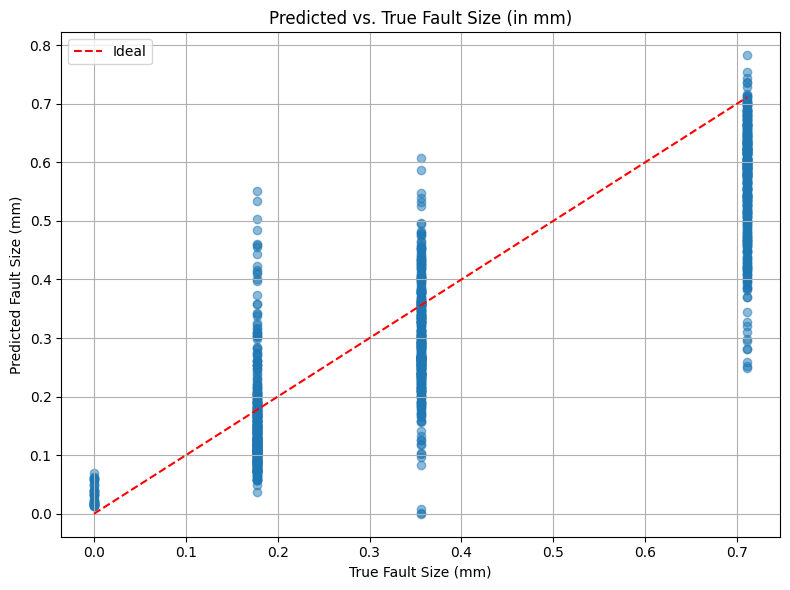


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0163
Root Mean Squared Error (RMSE): 0.1277
Mean Absolute Error (MAE): 0.0989
R2 Score: 0.6944
Mean Absolute Percentage Error (MAPE): 5437899882964.3848
{'model': 'ResNet1D_pt', 'train_time': 43.45300793647766, 'inference_time': 0.26935700859342304, 'model_size': 0.7082395553588867, 'total_flops': 35523072, 'total_params': 176244, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.95625, 'fault_size_acc': 0.9678571428571429, 'fault_type_size_acc': 0.9491071428571428, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.956159983803946, 'fault_size_f1': 0.9678107706339948, 'fault_type_size_f1': 0.9485082329115683, 'fault_size_mse': 0.0163019127173287, 'fault_size_rmse': np.float64(0.12767894390747717), 'fault_size_mae': 0.09892419426175496, 'fault_size_r2': 0.6944155364570372, 'fault_size_mape': 5437899882964.385}


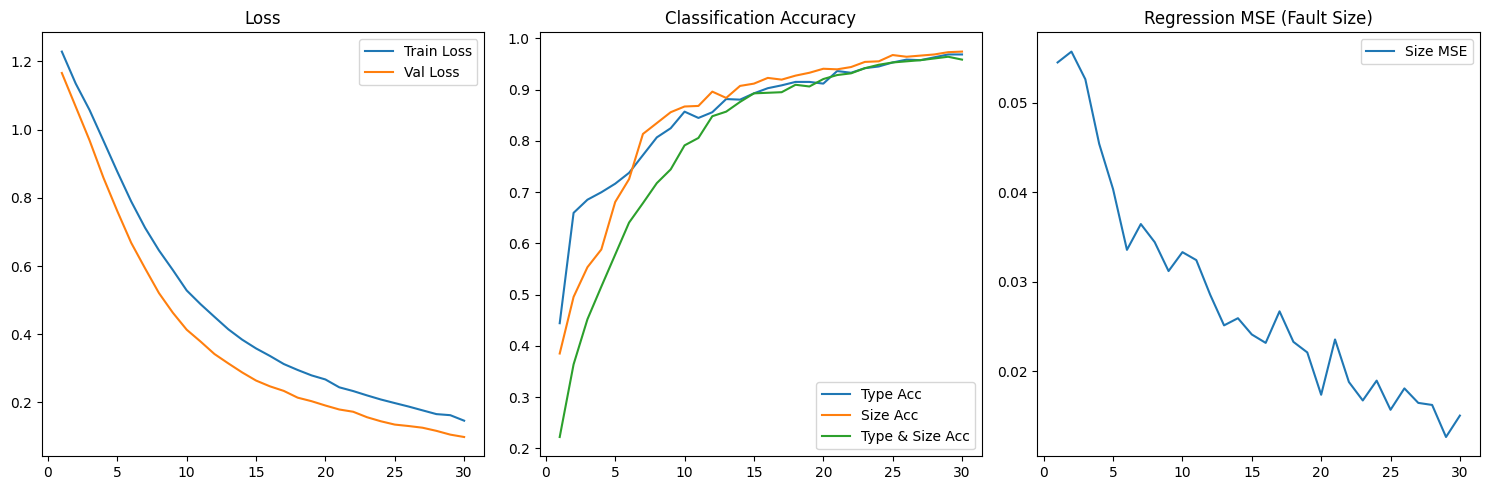

In [12]:
# ============================================================
# ⚙️ RESNET
# ============================================================

resnet_model = bm.ResNet1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                           num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                           init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                          ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'ResNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
resnet_history, resnet_metrics = train_evaluate_model_pt(
        model=resnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(resnet_metrics)
plot_training_results(resnet_history)

### 3. BiLSTM


✅ Epoch 1/30 Completed:
Train Loss: 1.2631, Val Loss: 1.2415
Train - Avg. Score: -0.0827, Type Acc: 0.3232, Size Acc: 0.3156, Type & Size Acc: 0.1000, R2 - Size: -0.8016
Validation - Avg. Score: 0.1191, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1071, R2 - Size: -0.1387

✅ Epoch 2/30 Completed:
Train Loss: 1.2301, Val Loss: 1.2111
Train - Avg. Score: 0.1433, Type Acc: 0.3232, Size Acc: 0.3295, Type & Size Acc: 0.1071, R2 - Size: -0.0647
Validation - Avg. Score: 0.1619, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1071, R2 - Size: 0.0040

✅ Epoch 3/30 Completed:
Train Loss: 1.2140, Val Loss: 1.1971
Train - Avg. Score: 0.1317, Type Acc: 0.3288, Size Acc: 0.3183, Type & Size Acc: 0.0998, R2 - Size: -0.0921
Validation - Avg. Score: 0.1652, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1071, R2 - Size: 0.0150

✅ Epoch 4/30 Completed:
Train Loss: 1.2088, Val Loss: 1.1933
Train - Avg. Score: 0.1192, Type Acc: 0.3315, Size Acc: 0.3118, Type & Size Acc: 0.1013, R


📂 Model saved to /content/output/PyTorch/dict_models/BiLSTM1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/BiLSTM1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/BiLSTM1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/BiLSTM1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/BiLSTM1D_pt/Confusion_Matrix_-_Fault_Type.png


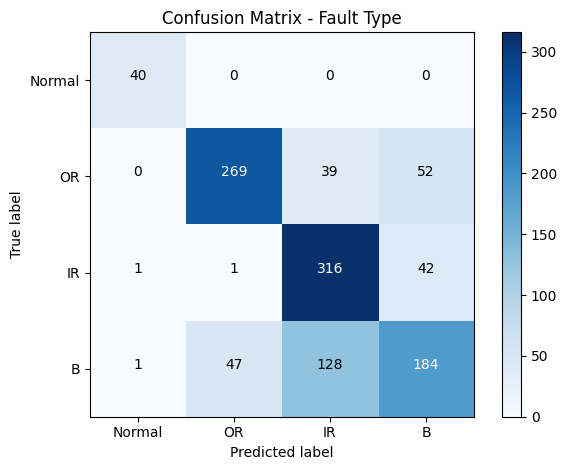

Plot saved to: /content/output/PyTorch/cf/BiLSTM1D_pt/Confusion_Matrix_-_Fault_Size.png


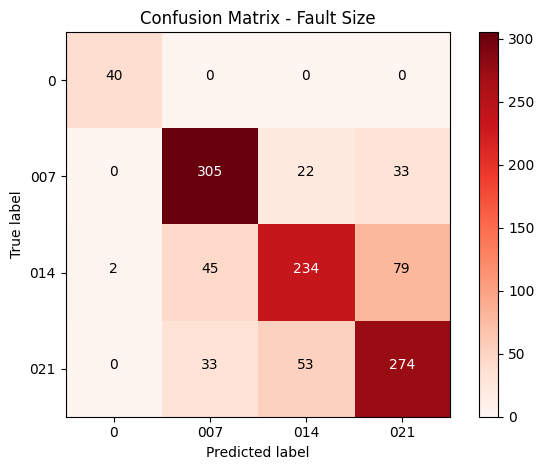

Plot saved to: /content/output/PyTorch/cf/BiLSTM1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


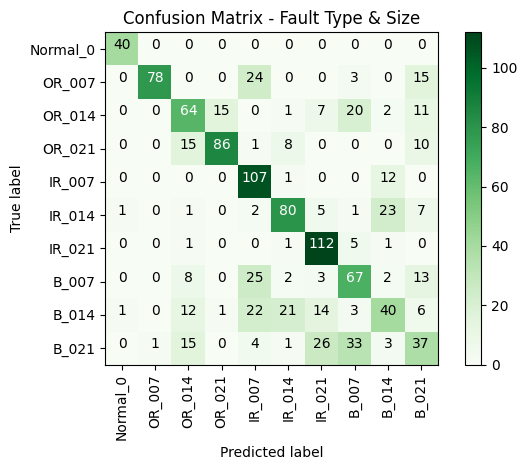


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.7223
  ➤ Fault Size Accuracy: 0.7616
  ➤ Fault Type Size Accuracy: 0.6348
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.7167
  ➤ F1 Score - Fault Size: 0.7597
  ➤ F1 Score - Fault Type & Size: 0.6271
  ➤ FLOPs: 0.99 MFLOPs
  ➤ Params: 0.61 M
  ➤ Model Size: 2.32 MB
Plot saved to: /content/output/PyTorch/cf/BiLSTM1D_pt/Predicted_vs._True_Fault_Size.png


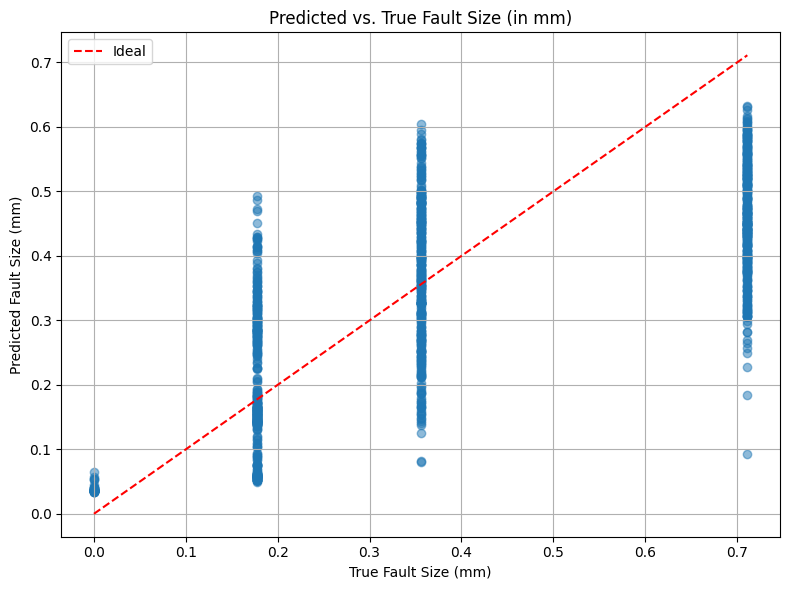


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0314
Root Mean Squared Error (RMSE): 0.1773
Mean Absolute Error (MAE): 0.1424
R2 Score: 0.4109
Mean Absolute Percentage Error (MAPE): 6281951362604.2480
{'model': 'BiLSTM1D_pt', 'train_time': 82.4632158279419, 'inference_time': 0.3102523939950126, 'model_size': 2.321221351623535, 'total_flops': 992512, 'total_params': 605348, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.7223214285714286, 'fault_size_acc': 0.7616071428571428, 'fault_type_size_acc': 0.6348214285714285, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.716653753198304, 'fault_size_f1': 0.7597070570039949, 'fault_type_size_f1': 0.627105317592758, 'fault_size_mse': 0.03142602307138308, 'fault_size_rmse': np.float64(0.1772738646032829), 'fault_size_mae': 0.14238665150811097, 'fault_size_r2': 0.41090934738294893, 'fault_size_mape': 6281951362604.248}


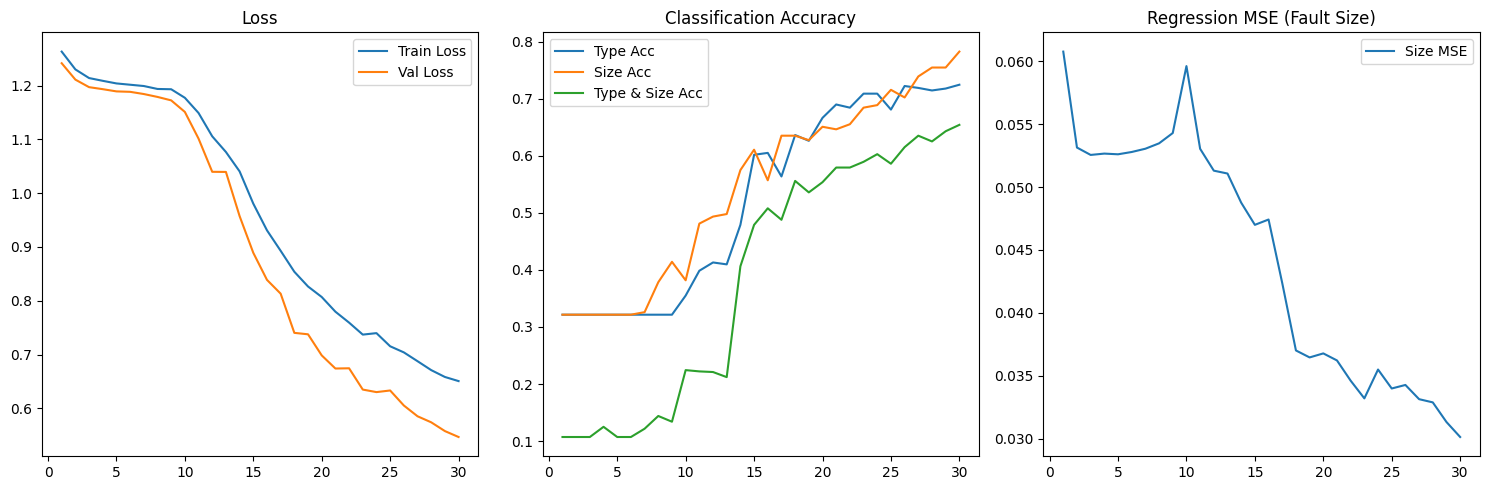

In [13]:
# ============================================================
# ⚙️ BILSTM HYPERPARAMETERS
# ============================================================

bilstm_model = bm.BiLSTM1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                           num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                           init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                          ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'BiLSTM1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
bilstm_history, bilstm_metrics = train_evaluate_model_pt(
        model=bilstm_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(bilstm_metrics)
plot_training_results(bilstm_history)

### 4. DenseNet


✅ Epoch 1/30 Completed:
Train Loss: 1.2474, Val Loss: 1.1475
Train - Avg. Score: 0.0306, Type Acc: 0.3554, Size Acc: 0.3449, Type & Size Acc: 0.1214, R2 - Size: -0.4861
Validation - Avg. Score: 0.2963, Type Acc: 0.5647, Size Acc: 0.4342, Type $ Size Acc: 0.3103, R2 - Size: 0.0115

✅ Epoch 2/30 Completed:
Train Loss: 1.1233, Val Loss: 1.0356
Train - Avg. Score: 0.1937, Type Acc: 0.4826, Size Acc: 0.4058, Type & Size Acc: 0.2366, R2 - Size: -0.1831
Validation - Avg. Score: 0.3531, Type Acc: 0.6440, Size Acc: 0.5536, Type $ Size Acc: 0.3359, R2 - Size: 0.0427

✅ Epoch 3/30 Completed:
Train Loss: 1.0377, Val Loss: 0.9254
Train - Avg. Score: 0.2490, Type Acc: 0.5520, Size Acc: 0.4554, Type & Size Acc: 0.3317, R2 - Size: -0.1732
Validation - Avg. Score: 0.4250, Type Acc: 0.6808, Size Acc: 0.5312, Type $ Size Acc: 0.5324, R2 - Size: 0.0762

✅ Epoch 4/30 Completed:
Train Loss: 0.9435, Val Loss: 0.8096
Train - Avg. Score: 0.3055, Type Acc: 0.6118, Size Acc: 0.5071, Type & Size Acc: 0.4297, R2 


📂 Model saved to /content/output/PyTorch/dict_models/DenseNet1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/DenseNet1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/DenseNet1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/DenseNet1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/DenseNet1D_pt/Confusion_Matrix_-_Fault_Type.png


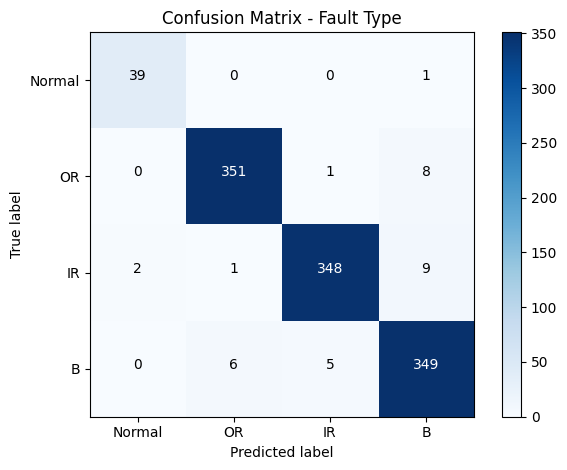

Plot saved to: /content/output/PyTorch/cf/DenseNet1D_pt/Confusion_Matrix_-_Fault_Size.png


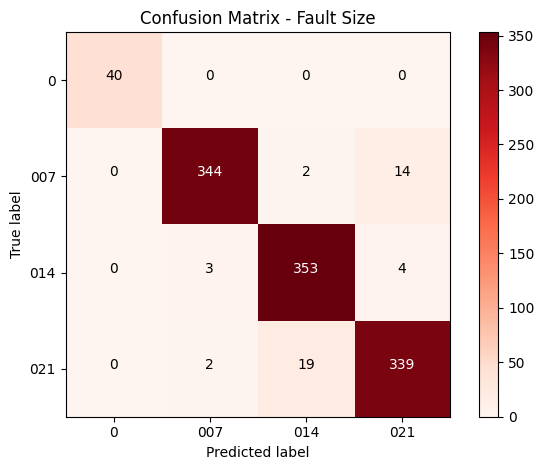

Plot saved to: /content/output/PyTorch/cf/DenseNet1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


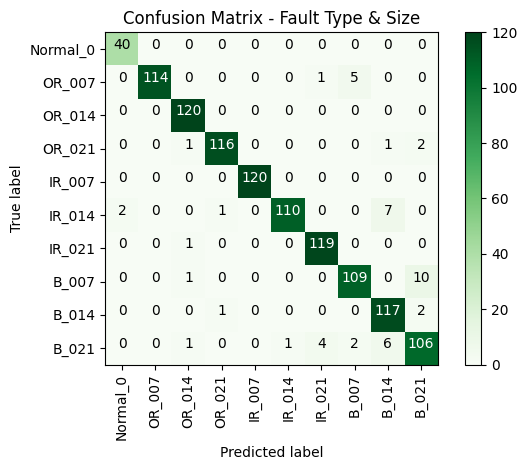


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.9705
  ➤ Fault Size Accuracy: 0.9607
  ➤ Fault Type Size Accuracy: 0.9563
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.9706
  ➤ F1 Score - Fault Size: 0.9607
  ➤ F1 Score - Fault Type & Size: 0.9563
  ➤ FLOPs: 131.12 MFLOPs
  ➤ Params: 0.43 M
  ➤ Model Size: 1.73 MB
Plot saved to: /content/output/PyTorch/cf/DenseNet1D_pt/Predicted_vs._True_Fault_Size.png


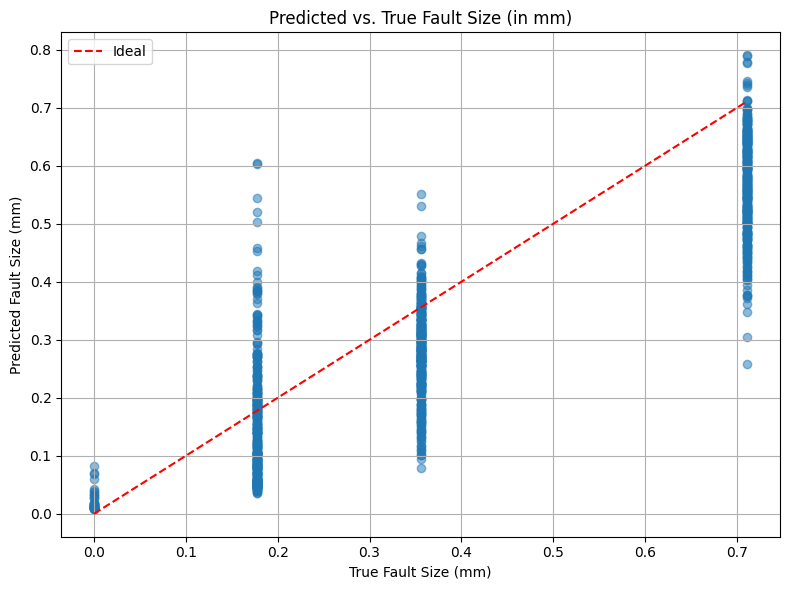


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0165
Root Mean Squared Error (RMSE): 0.1284
Mean Absolute Error (MAE): 0.1034
R2 Score: 0.6909
Mean Absolute Percentage Error (MAPE): 3660058858993.6689
{'model': 'DenseNet1D_pt', 'train_time': 139.58542895317078, 'inference_time': 0.6607172744614738, 'model_size': 1.7252445220947266, 'total_flops': 131123712, 'total_params': 434004, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.9705357142857143, 'fault_size_acc': 0.9607142857142857, 'fault_type_size_acc': 0.95625, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.9705894812494874, 'fault_size_f1': 0.9607344058159714, 'fault_type_size_f1': 0.9562588447937971, 'fault_size_mse': 0.016487942133953278, 'fault_size_rmse': np.float64(0.12840538202876575), 'fault_size_mae': 0.10335203026396422, 'fault_size_r2': 0.690928356733519, 'fault_size_mape': 3660058858993.669}


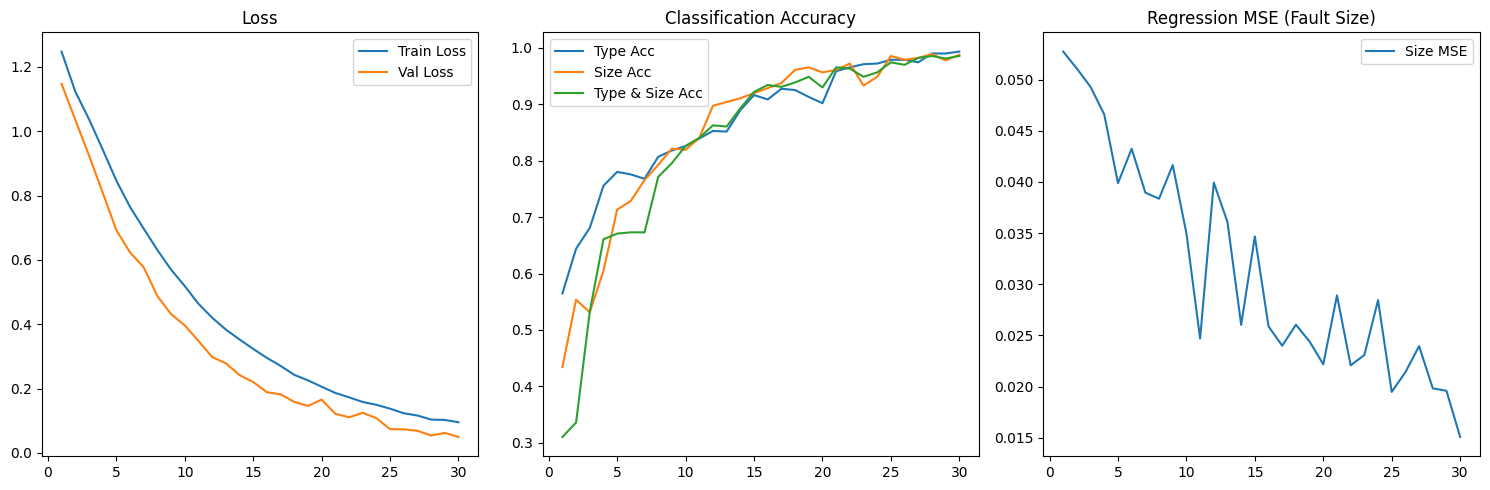

In [14]:
# ============================================================
# ⚙️ DENSENET
# ============================================================

densenet_model = bm.DenseNet1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                                ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'DenseNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
densenet_history, densenet_metrics = train_evaluate_model_pt(
        model=densenet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(densenet_metrics)
plot_training_results(densenet_history)

### 5. TinyVGG


✅ Epoch 1/30 Completed:
Train Loss: 1.2189, Val Loss: 1.1728
Train - Avg. Score: 0.0995, Type Acc: 0.3161, Size Acc: 0.3214, Type & Size Acc: 0.1150, R2 - Size: -0.2084
Validation - Avg. Score: 0.2084, Type Acc: 0.3817, Size Acc: 0.3605, Type $ Size Acc: 0.1629, R2 - Size: 0.0370

✅ Epoch 2/30 Completed:
Train Loss: 1.1810, Val Loss: 1.1464
Train - Avg. Score: 0.1701, Type Acc: 0.3629, Size Acc: 0.3576, Type & Size Acc: 0.1482, R2 - Size: -0.0615
Validation - Avg. Score: 0.2444, Type Acc: 0.4397, Size Acc: 0.3862, Type $ Size Acc: 0.2254, R2 - Size: 0.0385

✅ Epoch 3/30 Completed:
Train Loss: 1.1520, Val Loss: 1.1044
Train - Avg. Score: 0.2013, Type Acc: 0.4121, Size Acc: 0.3819, Type & Size Acc: 0.1812, R2 - Size: -0.0397
Validation - Avg. Score: 0.3249, Type Acc: 0.5100, Size Acc: 0.4565, Type $ Size Acc: 0.3214, R2 - Size: 0.1173

✅ Epoch 4/30 Completed:
Train Loss: 1.1127, Val Loss: 1.0533
Train - Avg. Score: 0.2413, Type Acc: 0.4551, Size Acc: 0.4230, Type & Size Acc: 0.2259, R2 


📂 Model saved to /content/output/PyTorch/dict_models/TinyVGG1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/TinyVGG1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/TinyVGG1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/TinyVGG1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/TinyVGG1D_pt/Confusion_Matrix_-_Fault_Type.png


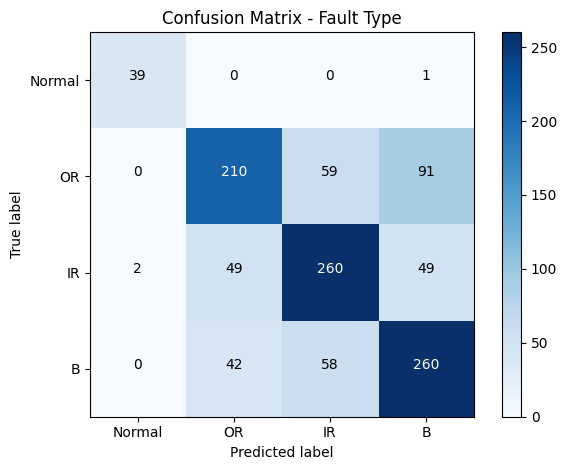

Plot saved to: /content/output/PyTorch/cf/TinyVGG1D_pt/Confusion_Matrix_-_Fault_Size.png


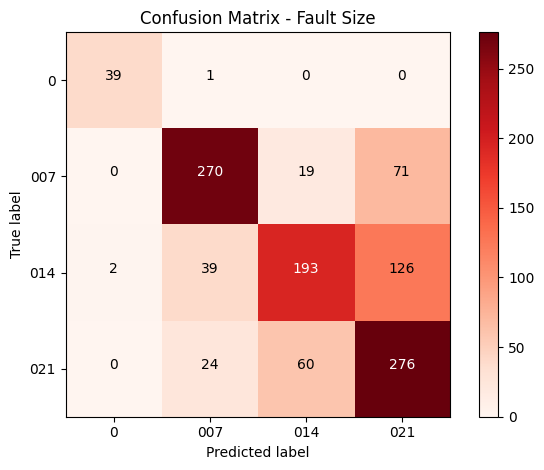

Plot saved to: /content/output/PyTorch/cf/TinyVGG1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


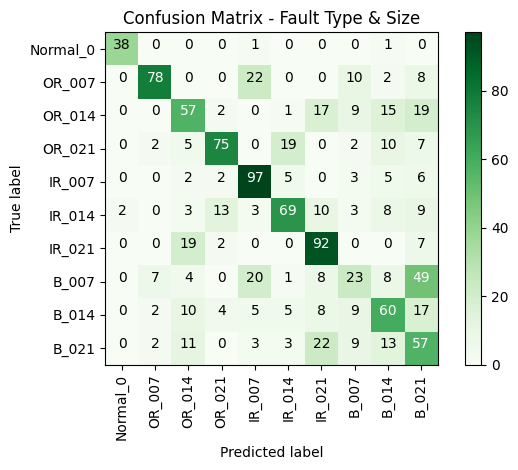


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.6866
  ➤ Fault Size Accuracy: 0.6946
  ➤ Fault Type Size Accuracy: 0.5768
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.6851
  ➤ F1 Score - Fault Size: 0.6938
  ➤ F1 Score - Fault Type & Size: 0.5741
  ➤ FLOPs: 7.57 MFLOPs
  ➤ Params: 4.24 M
  ➤ Model Size: 16.17 MB
Plot saved to: /content/output/PyTorch/cf/TinyVGG1D_pt/Predicted_vs._True_Fault_Size.png


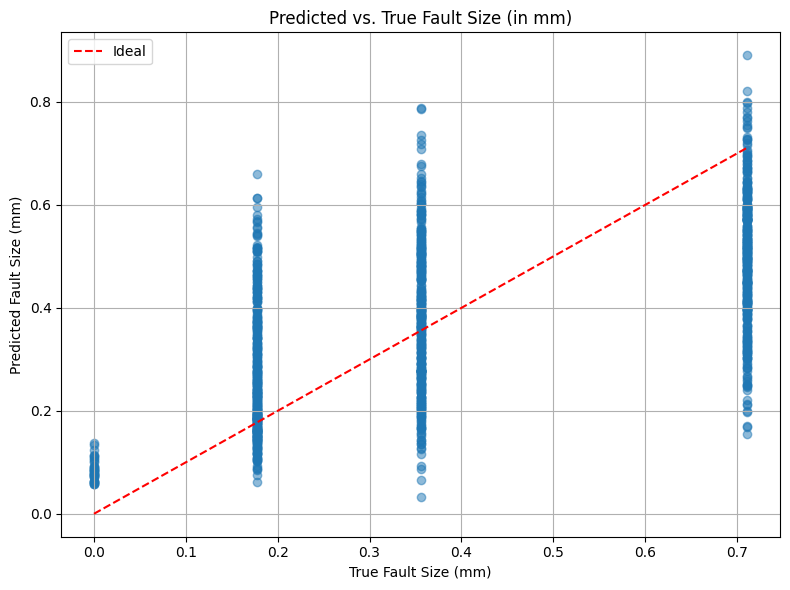


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0359
Root Mean Squared Error (RMSE): 0.1894
Mean Absolute Error (MAE): 0.1503
R2 Score: 0.3277
Mean Absolute Percentage Error (MAPE): 13685021744450.2500
{'model': 'TinyVGG1D_pt', 'train_time': 29.656155347824097, 'inference_time': 0.17894336155482699, 'model_size': 16.16956901550293, 'total_flops': 7571968, 'total_params': 4236468, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.6866071428571429, 'fault_size_acc': 0.6946428571428571, 'fault_type_size_acc': 0.5767857142857142, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.6850514952121909, 'fault_size_f1': 0.6938094944506799, 'fault_type_size_f1': 0.5741104004373624, 'fault_size_mse': 0.03586290125828583, 'fault_size_rmse': np.float64(0.18937502807467999), 'fault_size_mae': 0.15025448018152798, 'fault_size_r2': 0.32773867507840926, 'fault_size_mape': 13685021744450.25}


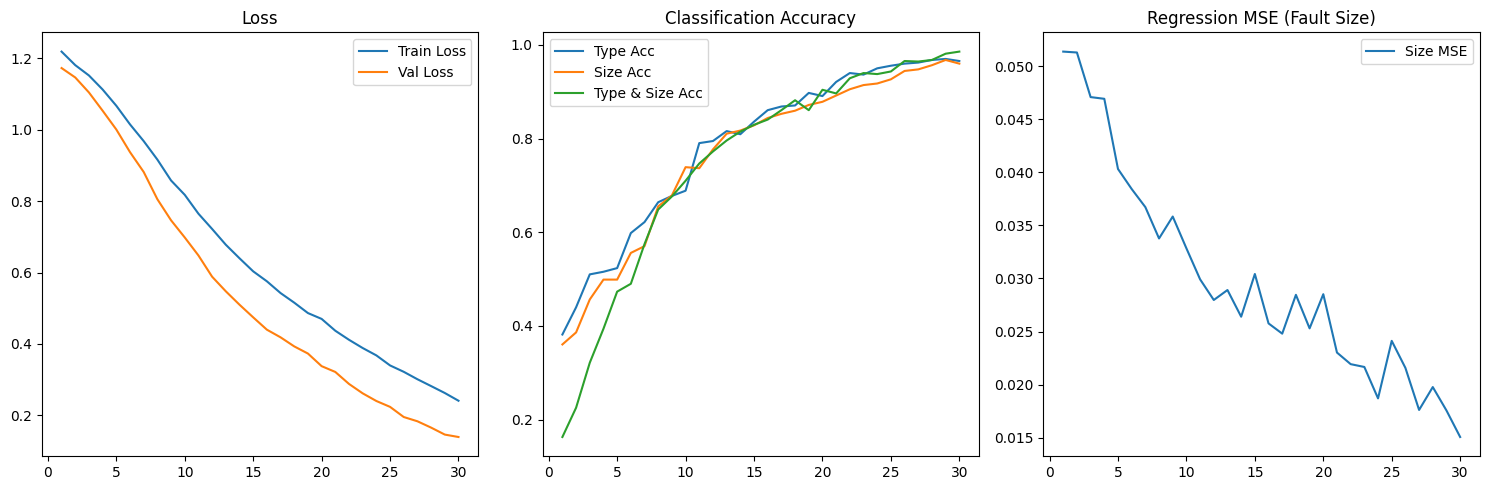

In [15]:
# ============================================================
# ⚙️ TINYVGG
# ============================================================

tinyvgg_model = bm.TinyVGG1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                             ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'TinyVGG1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
tinyvgg_history, tinyvgg_metrics = train_evaluate_model_pt(
        model=tinyvgg_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(tinyvgg_metrics)
plot_training_results(tinyvgg_history)

### 6. Xception


✅ Epoch 1/30 Completed:
Train Loss: 1.2816, Val Loss: 1.2724
Train - Avg. Score: -0.2651, Type Acc: 0.3225, Size Acc: 0.3141, Type & Size Acc: 0.1094, R2 - Size: -1.4173
Validation - Avg. Score: -0.1723, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1071, R2 - Size: -1.1101

✅ Epoch 2/30 Completed:
Train Loss: 1.2538, Val Loss: 1.2281
Train - Avg. Score: -0.0186, Type Acc: 0.3221, Size Acc: 0.3214, Type & Size Acc: 0.1049, R2 - Size: -0.5959
Validation - Avg. Score: 0.1434, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1161, R2 - Size: -0.0667

✅ Epoch 3/30 Completed:
Train Loss: 1.2098, Val Loss: 1.1944
Train - Avg. Score: 0.1380, Type Acc: 0.3248, Size Acc: 0.3241, Type & Size Acc: 0.1069, R2 - Size: -0.0795
Validation - Avg. Score: 0.1274, Type Acc: 0.3214, Size Acc: 0.3214, Type $ Size Acc: 0.1071, R2 - Size: -0.1111

✅ Epoch 4/30 Completed:
Train Loss: 1.1898, Val Loss: 1.1844
Train - Avg. Score: 0.1444, Type Acc: 0.3221, Size Acc: 0.3268, Type & Size Acc: 0.103


📂 Model saved to /content/output/PyTorch/dict_models/Xception1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/Xception1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/Xception1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/Xception1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/Xception1D_pt/Confusion_Matrix_-_Fault_Type.png


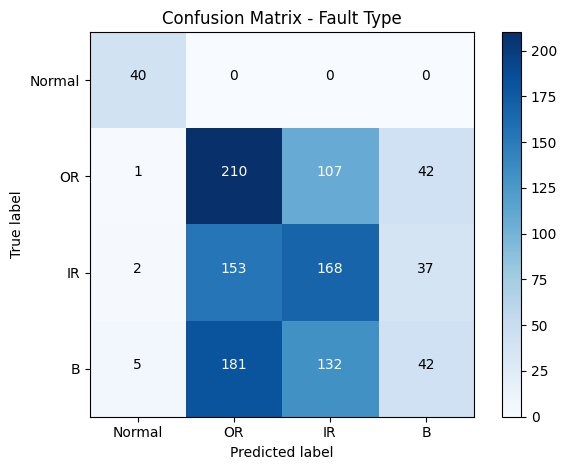

Plot saved to: /content/output/PyTorch/cf/Xception1D_pt/Confusion_Matrix_-_Fault_Size.png


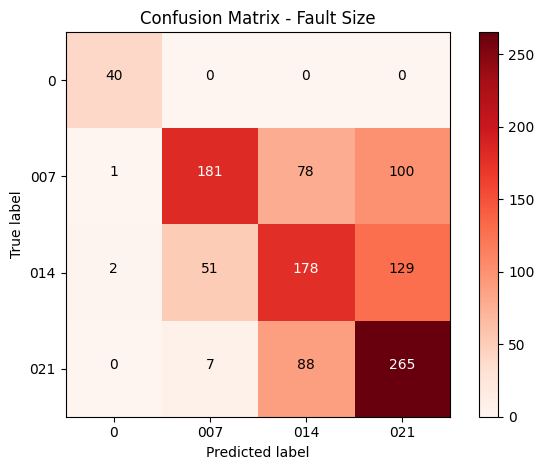

Plot saved to: /content/output/PyTorch/cf/Xception1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


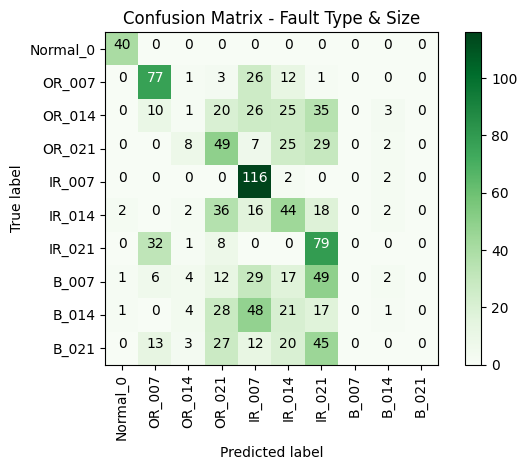


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.4107
  ➤ Fault Size Accuracy: 0.5929
  ➤ Fault Type Size Accuracy: 0.3634
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.3787
  ➤ F1 Score - Fault Size: 0.5907
  ➤ F1 Score - Fault Type & Size: 0.2739
  ➤ FLOPs: 14.24 MFLOPs
  ➤ Params: 0.32 M
  ➤ Model Size: 1.22 MB
Plot saved to: /content/output/PyTorch/cf/Xception1D_pt/Predicted_vs._True_Fault_Size.png


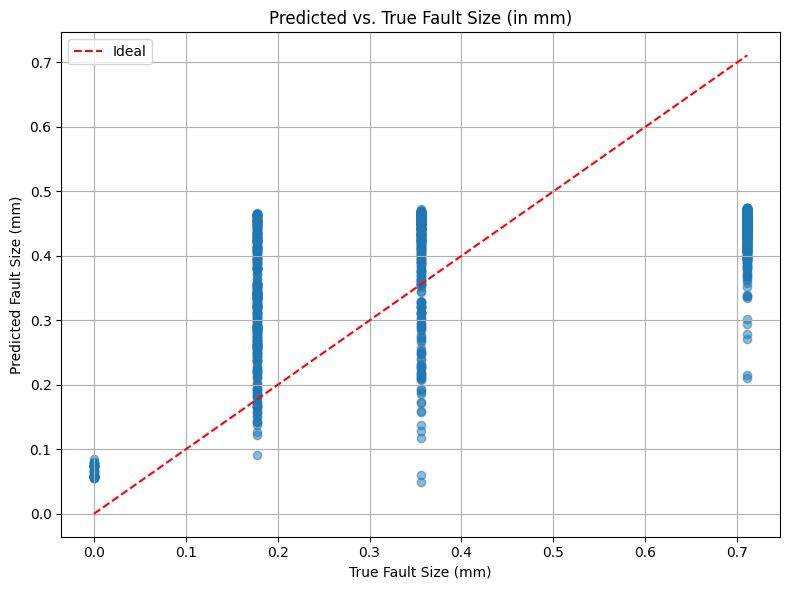


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0387
Root Mean Squared Error (RMSE): 0.1967
Mean Absolute Error (MAE): 0.1710
R2 Score: 0.2749
Mean Absolute Percentage Error (MAPE): 10688774514747.0098
{'model': 'Xception1D_pt', 'train_time': 33.03018498420715, 'inference_time': 0.3258422017097473, 'model_size': 1.2202720642089844, 'total_flops': 14242816, 'total_params': 316596, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.4107142857142857, 'fault_size_acc': 0.5928571428571429, 'fault_type_size_acc': 0.36339285714285713, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.37874521598460403, 'fault_size_f1': 0.5906977495540756, 'fault_type_size_f1': 0.2739171664974882, 'fault_size_mse': 0.038680168971494296, 'fault_size_rmse': np.float64(0.1966727458787676), 'fault_size_mae': 0.17099918435394232, 'fault_size_r2': 0.2749281087524972, 'fault_size_mape': 10688774514747.01}


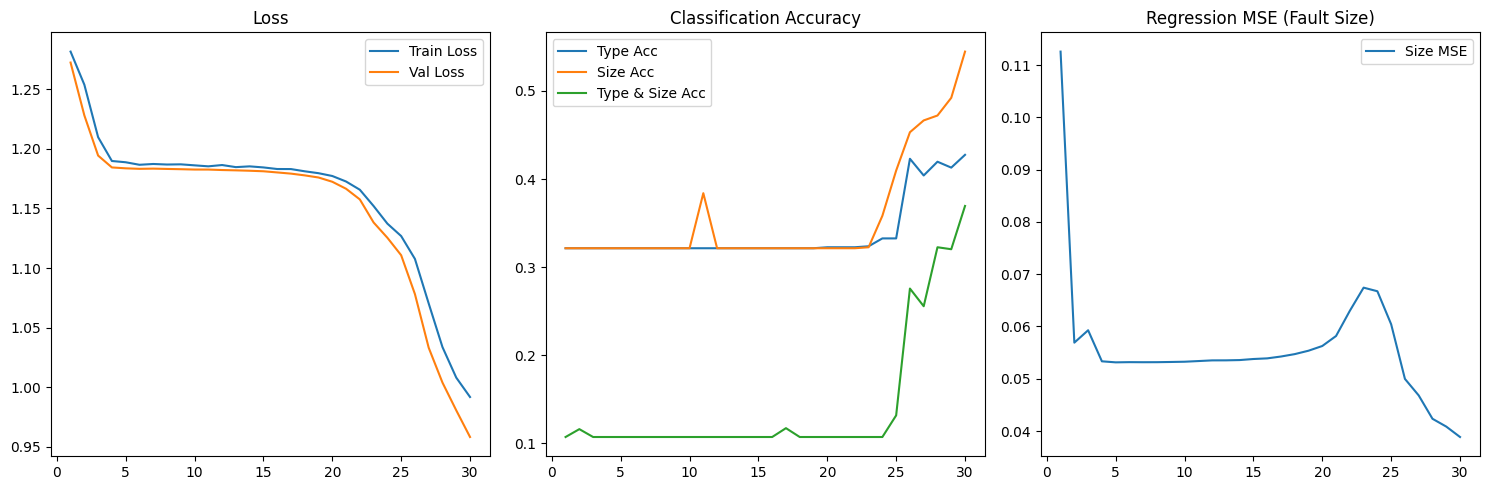

In [16]:
# ============================================================
# ⚙️ XCEPTION
# ============================================================

xception_model = bm.Xception1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                            ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'Xception1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
xception_history, xception_metrics = train_evaluate_model_pt(
        model=xception_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(xception_metrics)
plot_training_results(xception_history)

### 7. MobileNet


✅ Epoch 1/30 Completed:
Train Loss: 1.2095, Val Loss: 1.1767
Train - Avg. Score: 0.1207, Type Acc: 0.3210, Size Acc: 0.3192, Type & Size Acc: 0.1123, R2 - Size: -0.1367
Validation - Avg. Score: 0.2002, Type Acc: 0.3504, Size Acc: 0.3694, Type $ Size Acc: 0.1574, R2 - Size: 0.0302

✅ Epoch 2/30 Completed:
Train Loss: 1.1770, Val Loss: 1.1569
Train - Avg. Score: 0.1852, Type Acc: 0.3625, Size Acc: 0.3665, Type & Size Acc: 0.1560, R2 - Size: -0.0248
Validation - Avg. Score: 0.2611, Type Acc: 0.4286, Size Acc: 0.5078, Type $ Size Acc: 0.2076, R2 - Size: 0.0384

✅ Epoch 3/30 Completed:
Train Loss: 1.1535, Val Loss: 1.1174
Train - Avg. Score: 0.2126, Type Acc: 0.4114, Size Acc: 0.3859, Type & Size Acc: 0.2009, R2 - Size: -0.0239
Validation - Avg. Score: 0.3092, Type Acc: 0.4967, Size Acc: 0.5078, Type $ Size Acc: 0.3125, R2 - Size: 0.0486

✅ Epoch 4/30 Completed:
Train Loss: 1.1091, Val Loss: 1.0636
Train - Avg. Score: 0.2408, Type Acc: 0.4518, Size Acc: 0.4219, Type & Size Acc: 0.2415, R2 


📂 Model saved to /content/output/PyTorch/dict_models/MobileNet1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/MobileNet1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/MobileNet1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/MobileNet1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/MobileNet1D_pt/Confusion_Matrix_-_Fault_Type.png


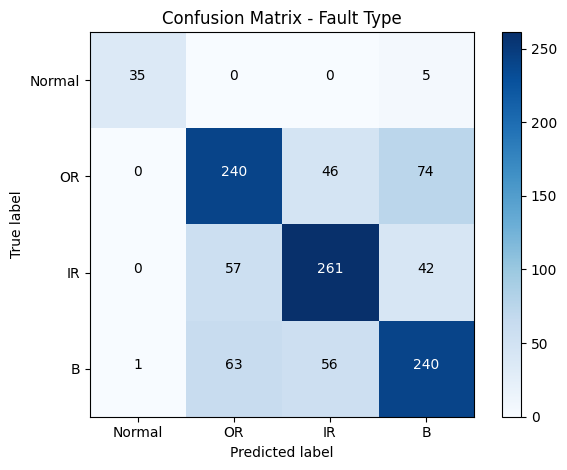

Plot saved to: /content/output/PyTorch/cf/MobileNet1D_pt/Confusion_Matrix_-_Fault_Size.png


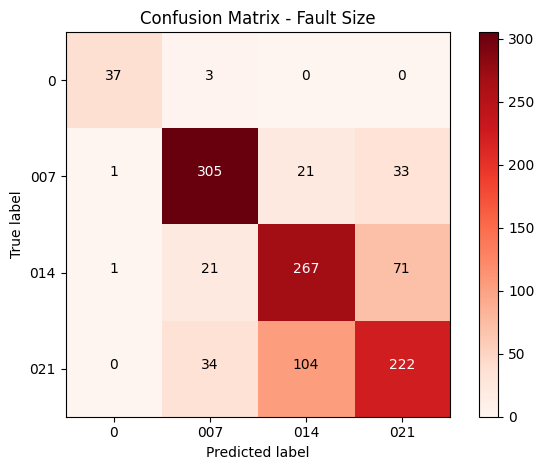

Plot saved to: /content/output/PyTorch/cf/MobileNet1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


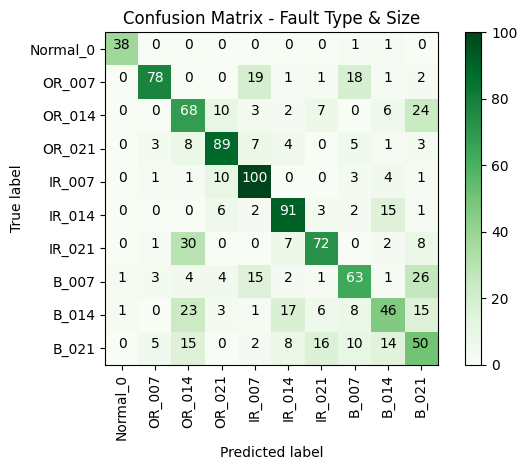


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.6929
  ➤ Fault Size Accuracy: 0.7420
  ➤ Fault Type Size Accuracy: 0.6205
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.6932
  ➤ F1 Score - Fault Size: 0.7409
  ➤ F1 Score - Fault Type & Size: 0.6197
  ➤ FLOPs: 9.72 MFLOPs
  ➤ Params: 8.53 M
  ➤ Model Size: 32.54 MB
Plot saved to: /content/output/PyTorch/cf/MobileNet1D_pt/Predicted_vs._True_Fault_Size.png


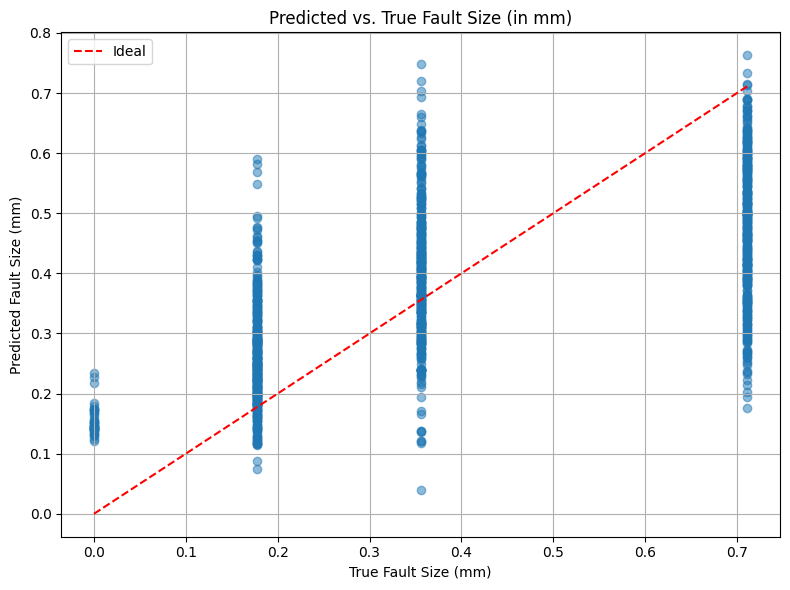


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0335
Root Mean Squared Error (RMSE): 0.1831
Mean Absolute Error (MAE): 0.1440
R2 Score: 0.3714
Mean Absolute Percentage Error (MAPE): 25061523193856.3711
{'model': 'MobileNet1D_pt', 'train_time': 30.122848749160767, 'inference_time': 0.19283145666122437, 'model_size': 32.54162788391113, 'total_flops': 9720832, 'total_params': 8528052, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.6928571428571428, 'fault_size_acc': 0.7419642857142857, 'fault_type_size_acc': 0.6205357142857143, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.6932377202667929, 'fault_size_f1': 0.7409321496327144, 'fault_type_size_f1': 0.6196978274708789, 'fault_size_mse': 0.03353233449405121, 'fault_size_rmse': np.float64(0.1831183619794891), 'fault_size_mae': 0.14403662969956973, 'fault_size_r2': 0.37142587956470585, 'fault_size_mape': 25061523193856.37}


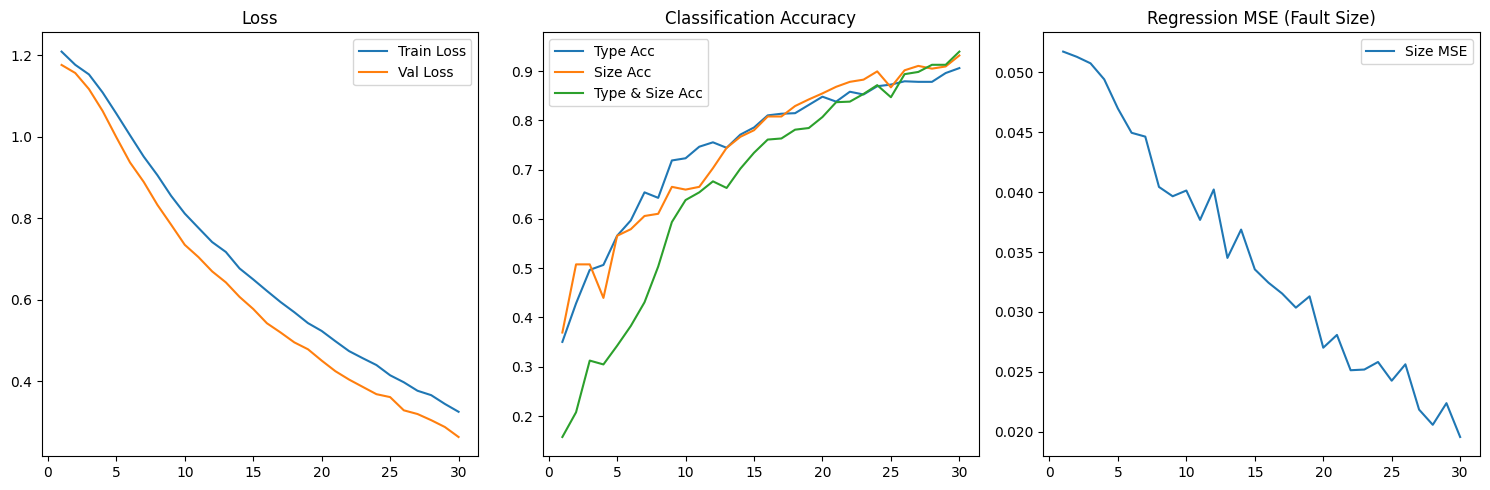

In [17]:
# ============================================================
# ⚙️ MOBILENET
# ============================================================

mobilenet_model = bm.MobileNet1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                                ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'MobileNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
mobilenet_history, mobilenet_metrics = train_evaluate_model_pt(
        model=mobilenet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(mobilenet_metrics)
plot_training_results(mobilenet_history)

### 8. EfficientNet


✅ Epoch 1/30 Completed:
Train Loss: 1.2062, Val Loss: 1.1793
Train - Avg. Score: 0.1291, Type Acc: 0.3315, Size Acc: 0.3203, Type & Size Acc: 0.1071, R2 - Size: -0.1114
Validation - Avg. Score: 0.2253, Type Acc: 0.4096, Size Acc: 0.3337, Type $ Size Acc: 0.2042, R2 - Size: 0.0514

✅ Epoch 2/30 Completed:
Train Loss: 1.1868, Val Loss: 1.1655
Train - Avg. Score: 0.1726, Type Acc: 0.3408, Size Acc: 0.3469, Type & Size Acc: 0.1290, R2 - Size: -0.0121
Validation - Avg. Score: 0.2463, Type Acc: 0.3683, Size Acc: 0.4051, Type $ Size Acc: 0.2478, R2 - Size: 0.0576

✅ Epoch 3/30 Completed:
Train Loss: 1.1692, Val Loss: 1.1413
Train - Avg. Score: 0.2024, Type Acc: 0.3821, Size Acc: 0.3739, Type & Size Acc: 0.1674, R2 - Size: 0.0031
Validation - Avg. Score: 0.3061, Type Acc: 0.4487, Size Acc: 0.5212, Type $ Size Acc: 0.2868, R2 - Size: 0.0868

✅ Epoch 4/30 Completed:
Train Loss: 1.1427, Val Loss: 1.1035
Train - Avg. Score: 0.2458, Type Acc: 0.4364, Size Acc: 0.4154, Type & Size Acc: 0.2208, R2 -


📂 Model saved to /content/output/PyTorch/dict_models/EfficientNet1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/EfficientNet1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/EfficientNet1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/EfficientNet1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/EfficientNet1D_pt/Confusion_Matrix_-_Fault_Type.png


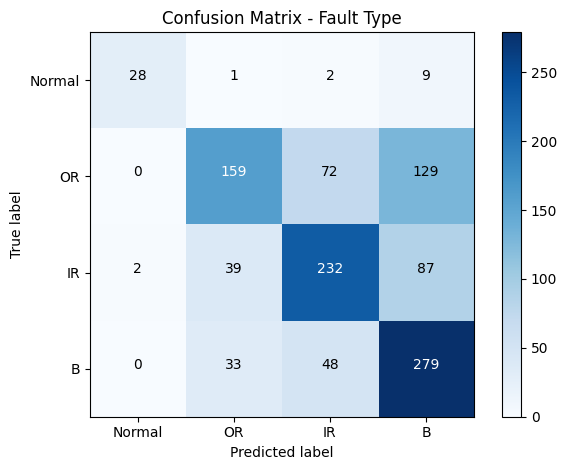

Plot saved to: /content/output/PyTorch/cf/EfficientNet1D_pt/Confusion_Matrix_-_Fault_Size.png


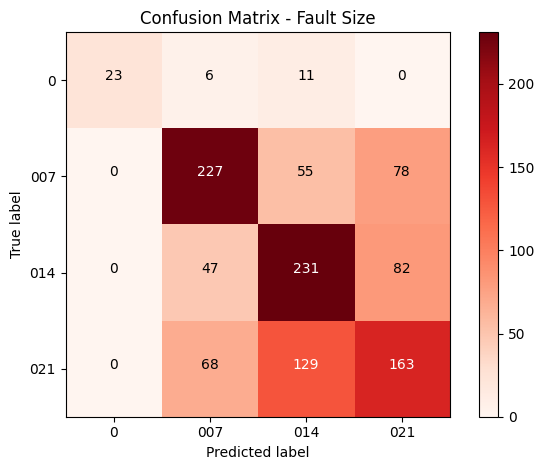

Plot saved to: /content/output/PyTorch/cf/EfficientNet1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


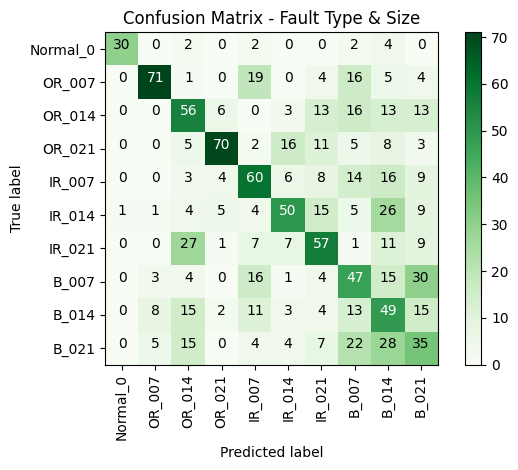


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.6232
  ➤ Fault Size Accuracy: 0.5750
  ➤ Fault Type Size Accuracy: 0.4688
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.6177
  ➤ F1 Score - Fault Size: 0.5745
  ➤ F1 Score - Fault Type & Size: 0.4814
  ➤ FLOPs: 19.31 MFLOPs
  ➤ Params: 16.92 M
  ➤ Model Size: 64.54 MB
Plot saved to: /content/output/PyTorch/cf/EfficientNet1D_pt/Predicted_vs._True_Fault_Size.png


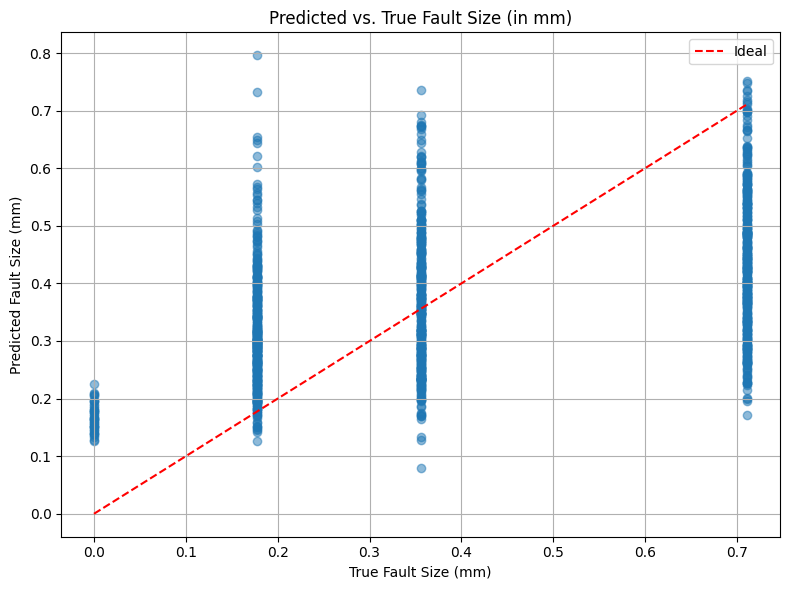


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0454
Root Mean Squared Error (RMSE): 0.2131
Mean Absolute Error (MAE): 0.1731
R2 Score: 0.1490
Mean Absolute Percentage Error (MAPE): 27106308619352.2422
{'model': 'EfficientNet1D_pt', 'train_time': 36.334503412246704, 'inference_time': 0.19274204969406128, 'model_size': 64.54169654846191, 'total_flops': 19305472, 'total_params': 16916660, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.6232142857142857, 'fault_size_acc': 0.575, 'fault_type_size_acc': 0.46875, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.6177035341163493, 'fault_size_f1': 0.5745419833238885, 'fault_type_size_f1': 0.4813696574290492, 'fault_size_mse': 0.04539930080156146, 'fault_size_rmse': np.float64(0.21307111676987442), 'fault_size_mae': 0.17311368556027965, 'fault_size_r2': 0.14897587655934286, 'fault_size_mape': 27106308619352.242}


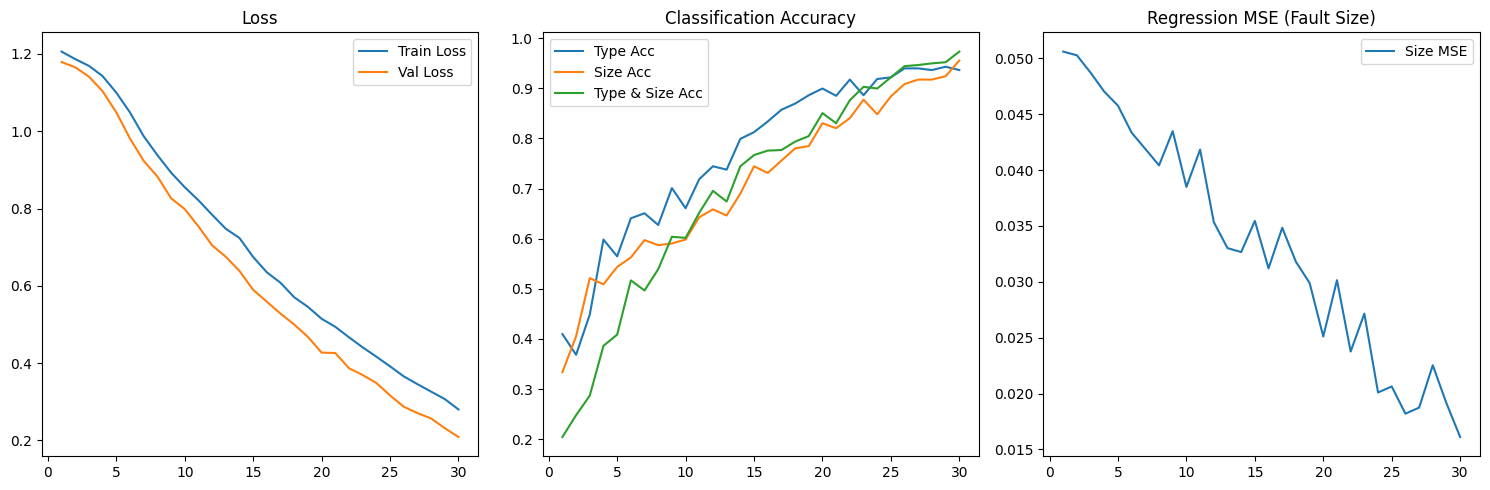

In [18]:
# ============================================================
# ⚙️ EFFICIENTNET
# ============================================================

efficientnet_model = bm.EfficientNet1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                                ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'EfficientNet1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
efficientnet_history, efficientnet_metrics = train_evaluate_model_pt(
        model=efficientnet_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(efficientnet_metrics)
plot_training_results(efficientnet_history)

### 9. DeepCNN


✅ Epoch 1/30 Completed:
Train Loss: 1.2172, Val Loss: 1.1853
Train - Avg. Score: 0.1211, Type Acc: 0.3263, Size Acc: 0.3228, Type & Size Acc: 0.0980, R2 - Size: -0.1270
Validation - Avg. Score: 0.1996, Type Acc: 0.4241, Size Acc: 0.3348, Type $ Size Acc: 0.1417, R2 - Size: 0.0177

✅ Epoch 2/30 Completed:
Train Loss: 1.1899, Val Loss: 1.1580
Train - Avg. Score: 0.1558, Type Acc: 0.3585, Size Acc: 0.3531, Type & Size Acc: 0.1252, R2 - Size: -0.0804
Validation - Avg. Score: 0.2282, Type Acc: 0.4453, Size Acc: 0.4208, Type $ Size Acc: 0.1395, R2 - Size: 0.0439

✅ Epoch 3/30 Completed:
Train Loss: 1.1530, Val Loss: 1.0931
Train - Avg. Score: 0.1997, Type Acc: 0.4234, Size Acc: 0.3721, Type & Size Acc: 0.1737, R2 - Size: -0.0384
Validation - Avg. Score: 0.3234, Type Acc: 0.5357, Size Acc: 0.5625, Type $ Size Acc: 0.2199, R2 - Size: 0.1261

✅ Epoch 4/30 Completed:
Train Loss: 1.0967, Val Loss: 1.0210
Train - Avg. Score: 0.2522, Type Acc: 0.4775, Size Acc: 0.4188, Type & Size Acc: 0.2536, R2 


📂 Model saved to /content/output/PyTorch/dict_models/DeepCNN1D_pt.pth
📂 Model saved to /content/output/PyTorch/full_models/DeepCNN1D_pt.pt



📄 Training/Validation history saved to /content/output/PyTorch/metrics/DeepCNN1D_pt_train_val_history.csv
📄 Test results saved to /content/output/PyTorch/metrics/DeepCNN1D_pt_test_results.csv
Plot saved to: /content/output/PyTorch/cf/DeepCNN1D_pt/Confusion_Matrix_-_Fault_Type.png


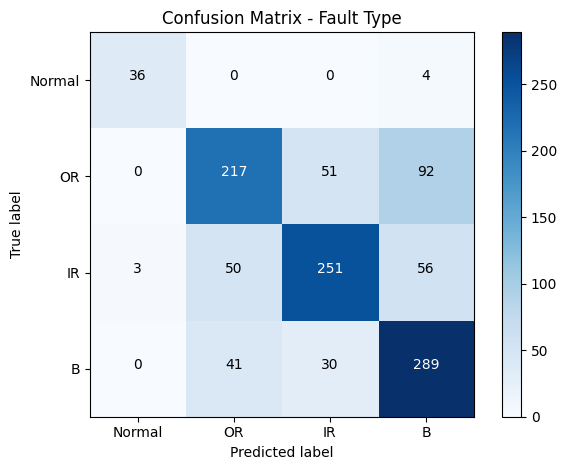

Plot saved to: /content/output/PyTorch/cf/DeepCNN1D_pt/Confusion_Matrix_-_Fault_Size.png


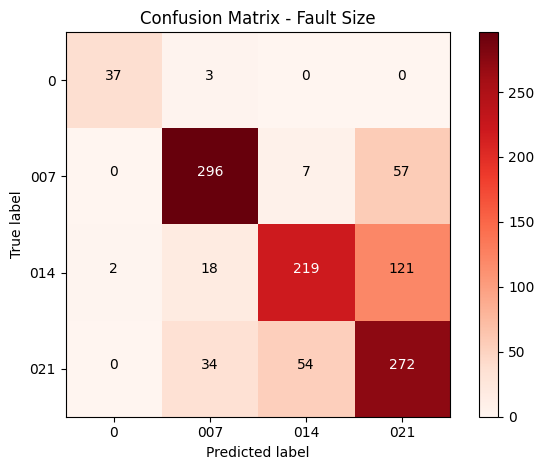

Plot saved to: /content/output/PyTorch/cf/DeepCNN1D_pt/Confusion_Matrix_-_Fault_Type__Size.png


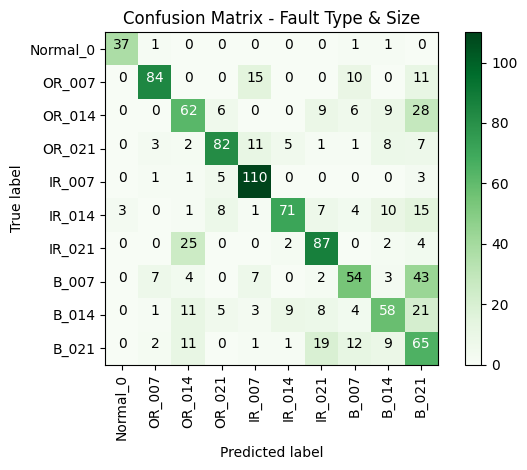


📈 Classification Metrics:
  ➤ Fault Check Accuracy: 0.9643
  ➤ Fault Type Accuracy: 0.7080
  ➤ Fault Size Accuracy: 0.7357
  ➤ Fault Type Size Accuracy: 0.6339
  ➤ F1 Score - Fault Check: 0.9818
  ➤ F1 Score - Fault Type: 0.7065
  ➤ F1 Score - Fault Size: 0.7369
  ➤ F1 Score - Fault Type & Size: 0.6388
  ➤ FLOPs: 52.66 MFLOPs
  ➤ Params: 8.50 M
  ➤ Model Size: 32.45 MB
Plot saved to: /content/output/PyTorch/cf/DeepCNN1D_pt/Predicted_vs._True_Fault_Size.png


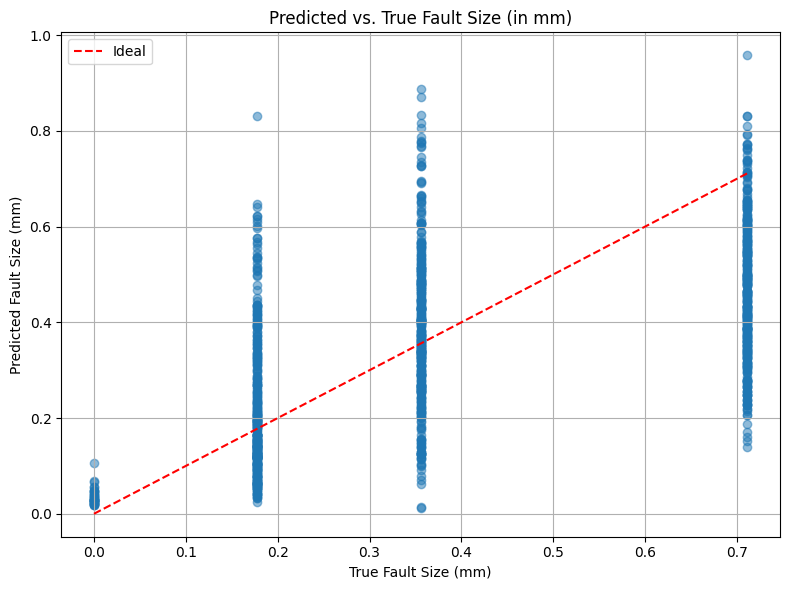


📊 Regression Metrics for Fault Size:
Mean Squared Error (MSE): 0.0430
Root Mean Squared Error (RMSE): 0.2073
Mean Absolute Error (MAE): 0.1602
R2 Score: 0.1944
Mean Absolute Percentage Error (MAPE): 5808082521761.3467
{'model': 'DeepCNN1D_pt', 'train_time': 43.99460697174072, 'inference_time': 0.27924563203539166, 'model_size': 32.45393943786621, 'total_flops': 52660736, 'total_params': 8504756, 'fault_check_acc': 0.9642857142857143, 'fault_type_acc': 0.7080357142857143, 'fault_size_acc': 0.7357142857142858, 'fault_type_size_acc': 0.6339285714285714, 'fault_check_f1': 0.9818181818181818, 'fault_type_f1': 0.7064993411021715, 'fault_size_f1': 0.736935685402853, 'fault_type_size_f1': 0.6388353515665629, 'fault_size_mse': 0.042978282411793634, 'fault_size_rmse': np.float64(0.20731204116450552), 'fault_size_mae': 0.1601597149665135, 'fault_size_r2': 0.19435862511733415, 'fault_size_mape': 5808082521761.347}


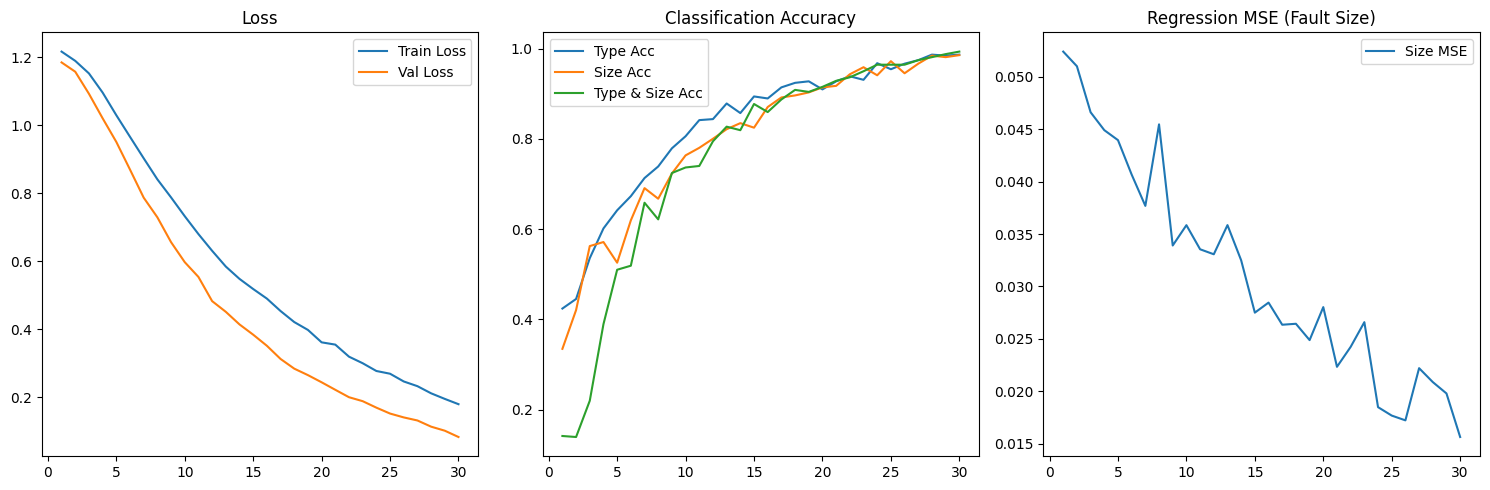

In [19]:
# ============================================================
# ⚙️ DEEPCNN
# ============================================================

deepcnn_model = bm.DeepCNN1D_pt(input_channels=INPUT_CHANNELS, input_size=INPUT_DIM, num_type_classes=NUM_TYPE_CLASSES,
                               num_size_classes=NUM_SIZE_CLASSES, num_type_size_classes=NUM_TYPE_SIZE_CLASSES,
                               init_mode=INIT_MODE, dropout_rate=DROPOUT_RATE
                            ).to(device)
train_loader, val_loader, test_loader = generate_dataloaders_pt(
    'DeepCNN1D_pt', X_train, y_train, X_val_split, y_val_split, X_test, y_test, INPUT_CHANNELS, BATCH_SIZE, NUM_WORKERS
)
deepcnn_history, deepcnn_metrics = train_evaluate_model_pt(
        model=deepcnn_model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        epochs=EPOCHS,
        lr=LEARNING_RATE,
        optimizer_choice=OPTIMIZER_CHOICE,
        weight_decay=WEIGHT_DECAY,
        scheduler_factor=SCHEDULER_FACTOR,
        scheduler_patience=SCHEDULER_PATIENCE,
        scheduler_mode=SCHEDULER_MODE,
        max_grad_norm=MAX_GRAD_NORM,
        early_patience=EARLY_PATIENCE,
    )
print(deepcnn_metrics)
plot_training_results(deepcnn_history)

## **Part 5: Summary of Results**

### **Summary**

In [20]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Category10, Category20
from bokeh.layouts import layout
from bokeh.transform import dodge
from itertools import cycle
import copy

def plot_training_time_bar(pt_histories):
    model_names = []
    train_times = []

    for model_name, history in pt_histories.items():
        if 'train_time' in history:
            # print(f"{model_name} has train_time:", history['train_time'])  # Debug print
            model_names.append(model_name)
            train_times.append(history['train_time'][0] if isinstance(history['train_time'], list) else history['train_time'])
        else:
            print(f"{model_name} has no train_time.")  # Debug print

    if not model_names:
        print("No models have valid 'train_time'.")
        return

    # Sorting and plotting (safe now)
    sorted_data = sorted(zip(train_times, model_names), reverse=True)
    train_times, model_names = zip(*sorted_data)

    from itertools import cycle
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.models import ColumnDataSource
    from bokeh.palettes import Category20

    colors = cycle(Category20[20])
    color_list = [next(colors) for _ in model_names]

    source = ColumnDataSource(data=dict(
        models=model_names,
        times=train_times,
        color=color_list
    ))

    p = figure(
        y_range=list(model_names),
        x_axis_label='Training Time (s)',
        title='Training Time per Model',
        width=800,
        height=30 * len(model_names) + 100,
        tools="pan,box_zoom,reset,save"
    )

    p.hbar(
        y='models', right='times', height=0.6,
        source=source, color='color'
    )

    p.ygrid.grid_line_color = None
    p.x_range.start = 0

    output_notebook()
    show(p)


def plot_final_metrics_bar(pt_histories, metric_names):
    """
    Plots the final (last epoch) values of specified metrics for multiple models.

    Args:
        pt_histories (dict): Dictionary of model histories.
        metric_names (list): List of metric names to plot (e.g., ['val_type_acc', 'val_size_r2']).
    """
    model_names = []
    metric_values = {metric: [] for metric in metric_names}  # Store values for each metric

    for model_name, history in pt_histories.items():
        model_names.append(model_name)
        for metric in metric_names:
            if metric in history and history[metric]:  # Check if metric exists and has values
                metric_values[metric].append(history[metric][-1])  # Get the last value
            else:
                metric_values[metric].append(0)  # Handle missing metric or empty list

    # Create ColumnDataSource with model names, metric values, and colors
    data = {'models': model_names}
    data.update(metric_values)  # Add metric values to the data dictionary
    data['color'] = Category20[len(model_names)]
    source = ColumnDataSource(data=data)

    # Create figure
    p = figure(
        y_range=model_names,
        x_axis_label='Metric Value',
        title=f'Final Values of {", ".join(metric_names)}',
        width=800,
        height=30 * len(model_names) + 100,
        tools="pan,box_zoom,reset,save"
    )

    # Plot bars for each metric
    for i, metric in enumerate(metric_names):
        p.hbar(
            y='models', right=metric, height=0.6,
            source=source, color='color', legend_label=metric
        )
        p.legend.location = "top_right"

    p.ygrid.grid_line_color = None
    p.x_range.start = 0

    output_notebook()
    show(p)

def plot_model_history(history_list, model_names):
    p = figure(title='Model Loss Comparison', x_axis_label='Epoch', y_axis_label='Loss', width=800, height=400)
    legend_items = []  # Store legend items
    colors = Category10[10]  # Get 10 colors from Category10 palette

    for i, history in enumerate(history_list):
        # ❌ Remove or comment out these lines:
        # if 'train_time' in history:
        #    history['train_time'] = [history['train_time']]

        # Ensure all columns have the same length (e.g., using epoch length)
        epoch_len = len(history['epoch'])  # Or any other key with epoch length
        for key in history:
            if len(history[key]) == 1 and key != 'epoch':  # Assuming single values need to be extended
                history[key] = history[key] * epoch_len
            # Special case: 'epoch' should remain sequential values
            if key == 'epoch':
                history[key] = list(range(1, epoch_len + 1))


        # Create ColumnDataSource
        source = ColumnDataSource(data=history)

        # Plot train loss
        train_line = p.line(x='epoch', y='train_loss', source=source, color=colors[i % len(colors)], line_width=2)  # Use color from palette
        legend_items.append((f"{model_names[i]} - Train Loss", [train_line]))

        # Plot validation loss
        val_line = p.line(x='epoch', y='val_loss', source=source, color=colors[i % len(colors)], line_width=2, line_dash='dashed')  # Use color from palette
        legend_items.append((f"{model_names[i]} - Validation Loss", [val_line]))

    # Add legend
    legend = Legend(items=legend_items, location='top_right')
    p.add_layout(legend, 'right')
    p.legend.click_policy = "hide"  # Allow clicking on legend to hide/show lines

    output_notebook()
    show(p)

def plot_model_metric(history_list, model_names, metric_name):
    """
    Plots a specified metric for multiple models using Bokeh.

    Args:
        history_list (list): List of history dictionaries for each model.
        model_names (list): List of model names.
        metric_name (str): The name of the metric to plot (e.g., 'train_loss', 'val_size_r2', 'val_type_acc').
    """

    # Determine title and y-axis label based on metric name
    if metric_name == 'train_loss' or metric_name == 'val_loss':
        title = 'Model Loss Comparison'
        y_label = 'Loss'
    elif metric_name == 'val_size_r2':
        title = 'Model R² Comparison'
        y_label = 'R²'
    elif metric_name == 'val_type_acc':
        title = 'Model Accuracy Comparison'
        y_label = 'Accuracy'
    else:
        title = f'Model {metric_name} Comparison'
        y_label = metric_name

    p = figure(title=title, x_axis_label='Epoch', y_axis_label=y_label, width=800, height=400)
    legend_items = []
    colors = Category10[10]

    for i, history in enumerate(history_list):
        # Ensure all columns have the same length
        epoch_len = len(history['epoch'])  # You might need to adjust this based on your history data structure
        for key in history:
            if len(history[key]) == 1 and key != 'epoch':
                history[key] = history[key] * epoch_len
            if key == 'epoch':
                history[key] = list(range(1, epoch_len + 1))

        source = ColumnDataSource(data=history)

        # Plot the specified metric
        line = p.line(x='epoch', y=metric_name, source=source, color=colors[i % len(colors)], line_width=2)
        legend_items.append((f"{model_names[i]} - {metric_name}", [line]))

    legend = Legend(items=legend_items, location='top_right')
    p.add_layout(legend, 'right')
    p.legend.click_policy = "hide"

    output_notebook()
    show(p)

pt_histories = {
    # Base models
    "CNN1D": cnn_history,
    "ResNet1D": resnet_history,
    "BiLSTM1D": bilstm_history,
    "DenseNet1D": densenet_history,
    "TinyVGG1D": tinyvgg_history,
    "Xception1D": xception_history,
    "MobileNet1D": mobilenet_history,
    "EfficientNet1D": efficientnet_history,
    "DeepCNN1D": deepcnn_history,

}

# To correctly iterate through a dictionary and get both keys and values,
# you should use pt_histories.items():

history_list = []
model_names = []

for key, history in pt_histories.items():
    # Create a deep copy so original dict is untouched
    history_copy = copy.deepcopy(history)

    # Add epoch key
    history_copy['epoch'] = list(range(1, len(history_copy['train_loss']) + 1))

    # Remove 'train_time' if it exists
    history_copy.pop('train_time', None)

    history_list.append(history_copy)
    model_names.append(key)

**Train vs Validation Loss**

In [21]:
plot_model_history(history_list, model_names)

**Training Time**

In [22]:
plot_training_time_bar(pt_histories)

**Validation Metrics (Classification)**

In [23]:
plot_final_metrics_bar(pt_histories, ['val_check_acc'])
plot_final_metrics_bar(pt_histories, ['val_type_acc'])
plot_final_metrics_bar(pt_histories, ['val_size_acc'])
plot_final_metrics_bar(pt_histories, ['val_type_size_acc'])

**Validation Metrics (Regression)**

In [24]:
plot_final_metrics_bar(pt_histories, ['val_size_mse'])
plot_final_metrics_bar(pt_histories, ['val_size_mae'])
plot_final_metrics_bar(pt_histories, ['val_size_r2'])
plot_final_metrics_bar(pt_histories, ['val_size_mape'])

**Training Metrics (Classification)**

In [25]:
plot_model_metric(history_list, model_names, 'val_check_acc') # Plot validation type accuracy
plot_model_metric(history_list, model_names, 'val_type_acc') # Plot validation type accuracy
plot_model_metric(history_list, model_names, 'val_size_acc')  # Plot validation Size Accuracy
plot_model_metric(history_list, model_names, 'val_type_size_acc')  # Plot validation Size Accuracy

**Training Metrics (Regression)**

In [26]:
plot_model_metric(history_list, model_names, 'val_size_mse')  # Plot validation MSE
plot_model_metric(history_list, model_names, 'val_size_mae')  # Plot validation MAE
plot_model_metric(history_list, model_names, 'val_size_r2')  # Plot validation R²
plot_model_metric(history_list, model_names, 'val_size_mape')  # Plot validation MAPE

### **Testing Comparison**

In [27]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Legend
from bokeh.palettes import Category10, Category20
from bokeh.transform import dodge

def plot_test_metrics_bar(_metrics, metric_names):
    """
    Plots the test metrics (e.g., fault_check_acc, fault_type_acc, fault_size_r2)
    for all models in a grouped bar chart using Bokeh.

    Args:
        _metrics (dict): Dictionary containing model names as keys and a dictionary of test metrics as values.
        metric_names (list): List of metric names to plot (e.g., ['fault_check_acc', 'fault_type_acc', 'fault_size_r2']).
    """
    model_names = list(_metrics.keys())
    num_metrics = len(metric_names)

    # Fallback color palette depending on number of metrics
    colors = Category20[num_metrics] if num_metrics > 10 else Category10[10]

    # Collect metrics for each model
    data = {'models': model_names}
    for metric in metric_names:
        data[metric] = [model_metrics.get(metric, 0) for model_metrics in _metrics.values()]  # Fallback to 0 if missing

    # Prepare source for grouped bar chart
    source = ColumnDataSource(data=data)

    p = figure(
        x_range=model_names,
        y_axis_label='Metric Value',
        title='Test Metrics per Model',
        width=1000,
        height=500,
        tools="pan,box_zoom,reset,save"
    )

    # Add bars for each metric with dodge
    bar_width = 0.2
    for i, metric in enumerate(metric_names):
        p.vbar(
            x=dodge('models', -0.3 + i * bar_width, range=p.x_range),
            top=metric,
            width=bar_width,
            source=source,
            color=colors[i % len(colors)],
            legend_label=metric
        )

    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    p.xaxis.major_label_orientation = 1  # Vertical label rotation
    p.legend.location = "top_left"
    p.legend.click_policy = "hide"

    output_notebook()
    show(p)

pt_metrics = {
    # Base models
    "CNN1D": cnn_metrics,                     #
    "ResNet1D": resnet_metrics,               #
    "BiLSTM1D": bilstm_metrics,               #
    "DenseNet1D": densenet_metrics,           #
    "TinyVGG1D": tinyvgg_metrics,             #
    "Xception1D": xception_metrics,           #
    "MobileNet1D": mobilenet_metrics,         #
    "EfficientNet1D": efficientnet_metrics,   #
    "DeepCNN1D": deepcnn_metrics,             #

}

In [28]:
plot_test_metrics_bar(pt_metrics, ['fault_type_acc', 'fault_size_acc', 'fault_type_size_acc', 'fault_size_r2'])
plot_test_metrics_bar(pt_metrics, ['fault_size_mse', 'fault_size_rmse', 'fault_size_mae'])
plot_test_metrics_bar(pt_metrics, ['fault_size_mape'])

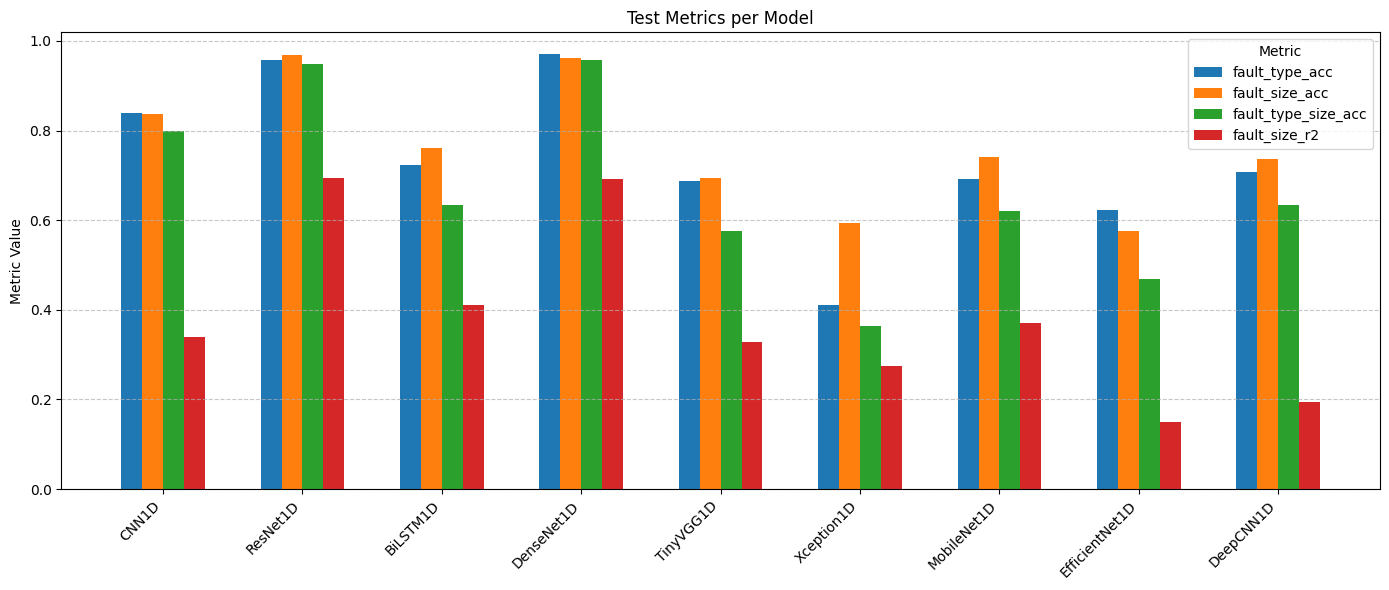

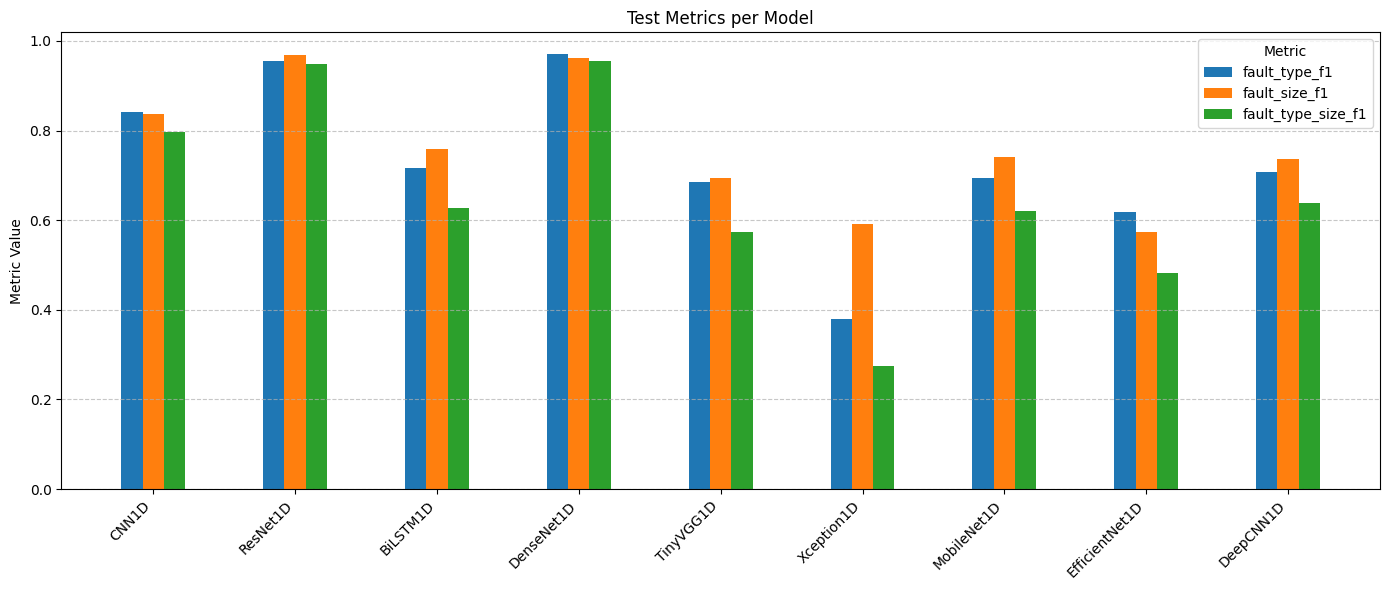

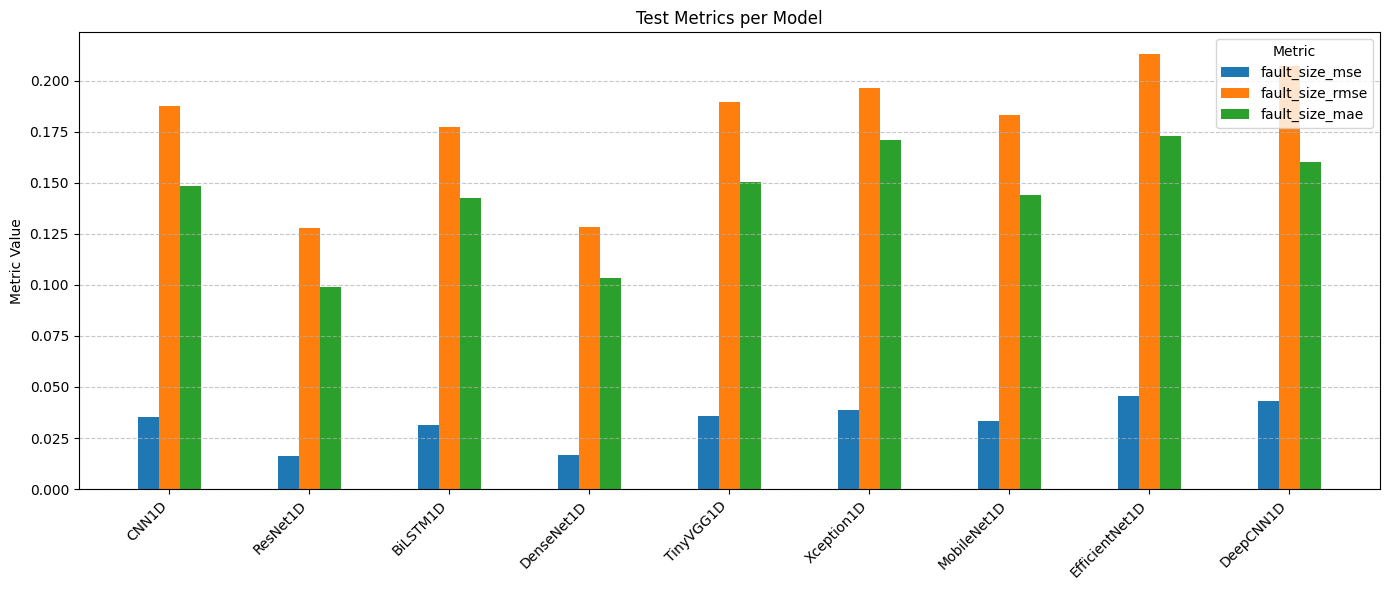

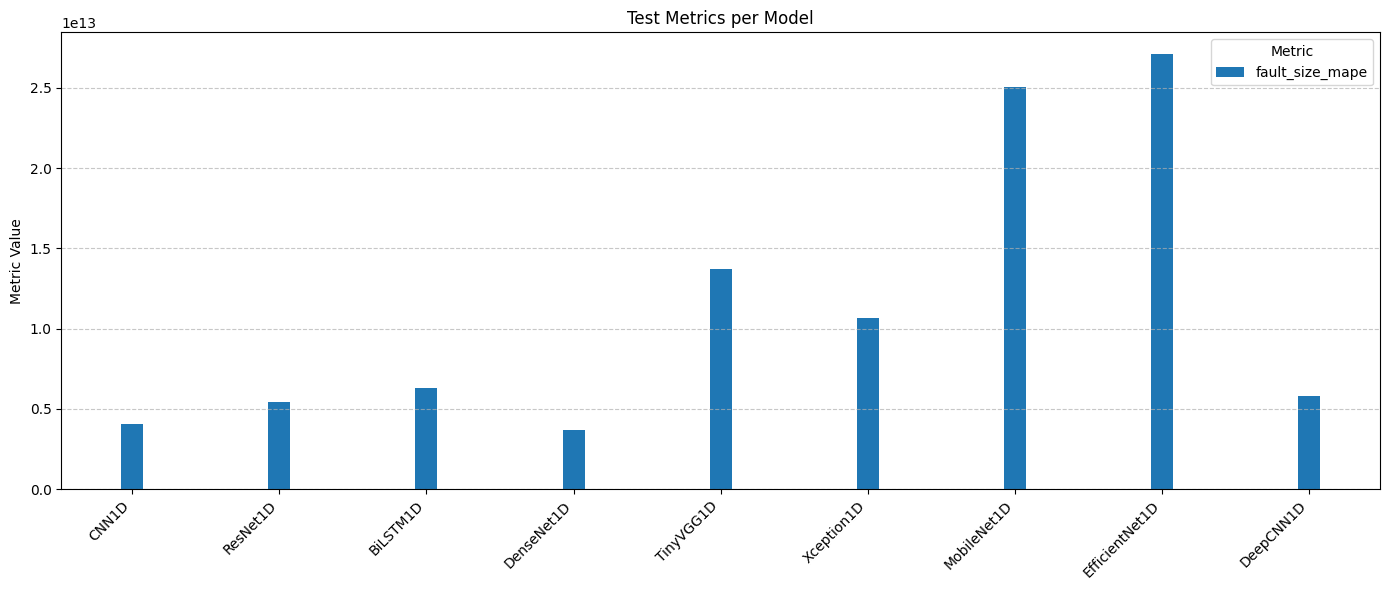

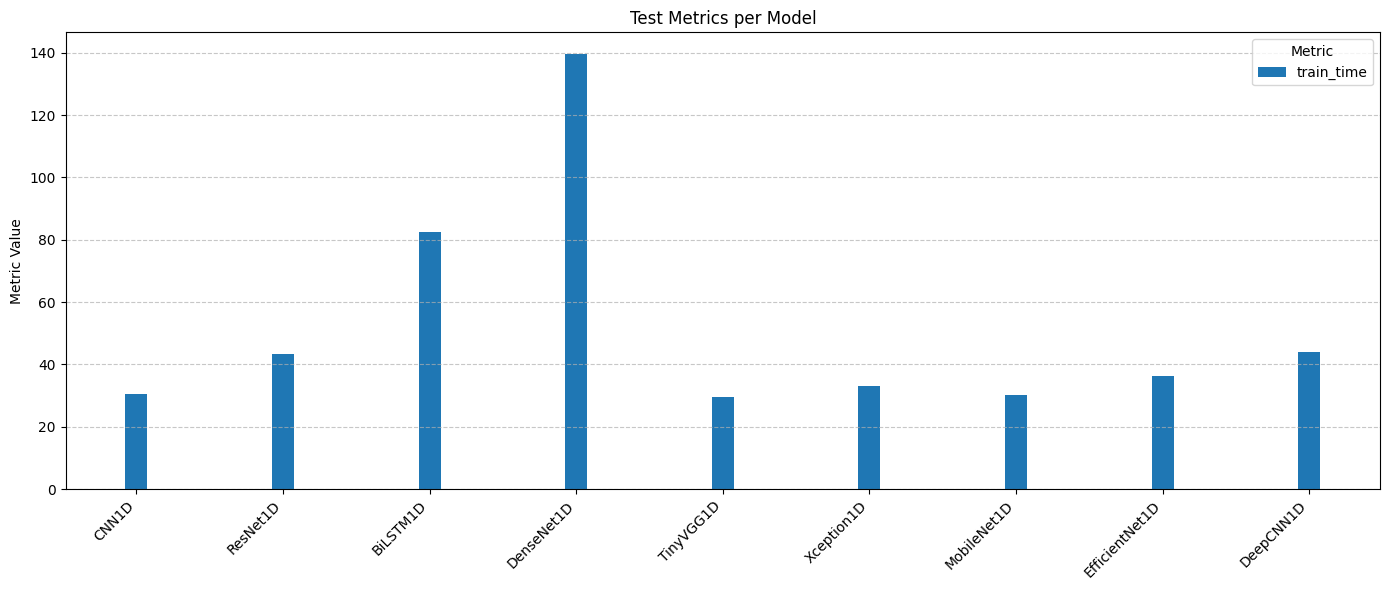

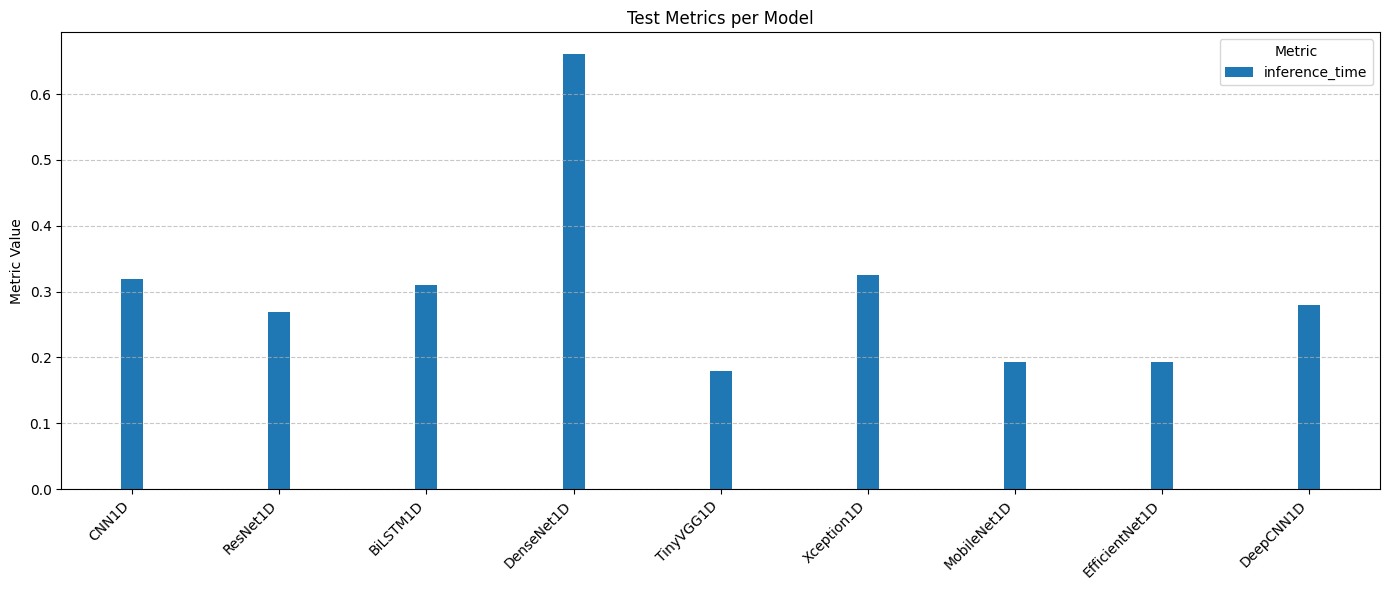

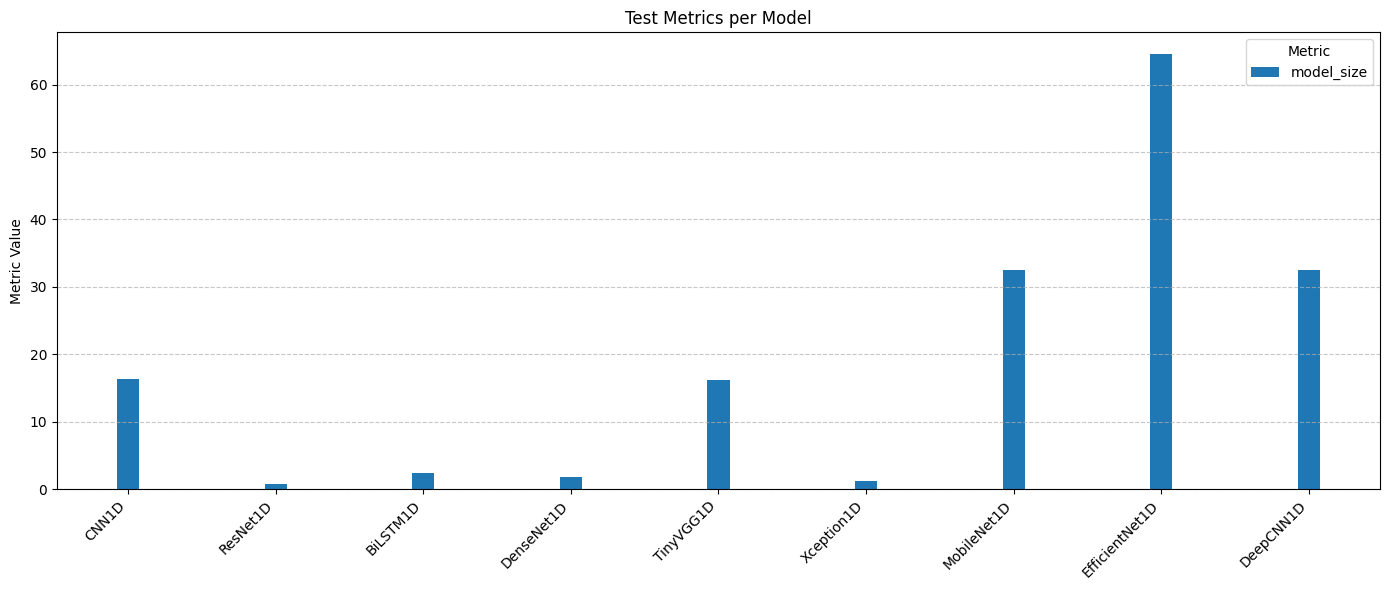

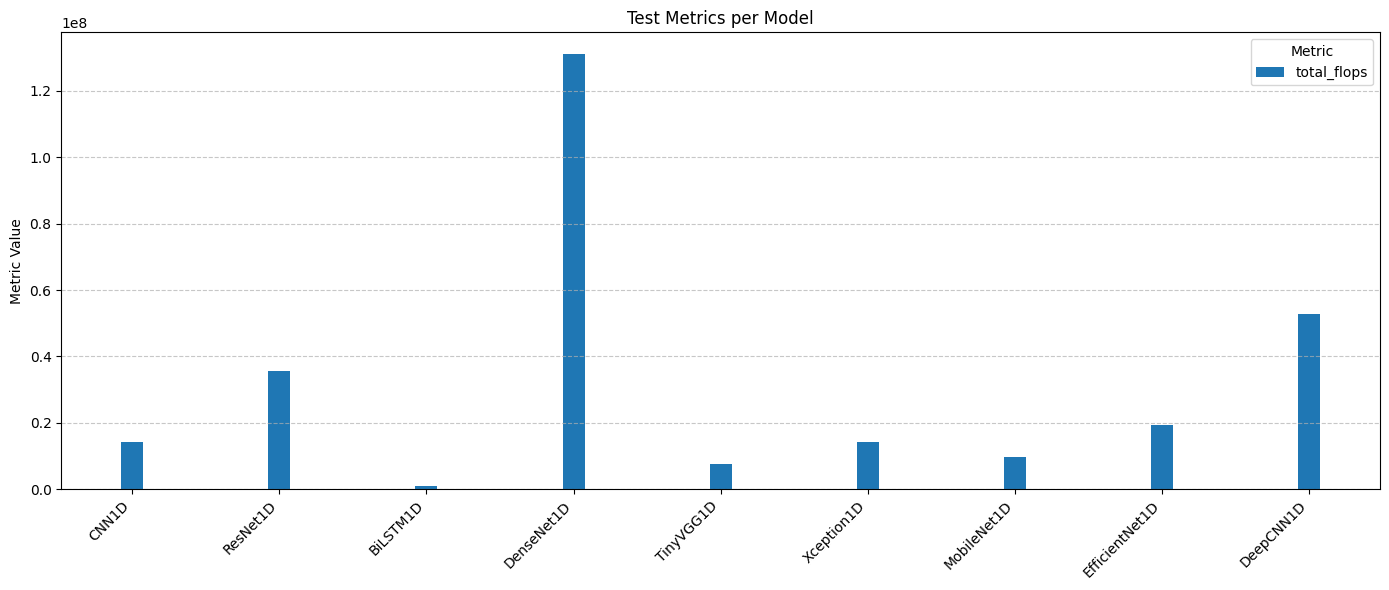

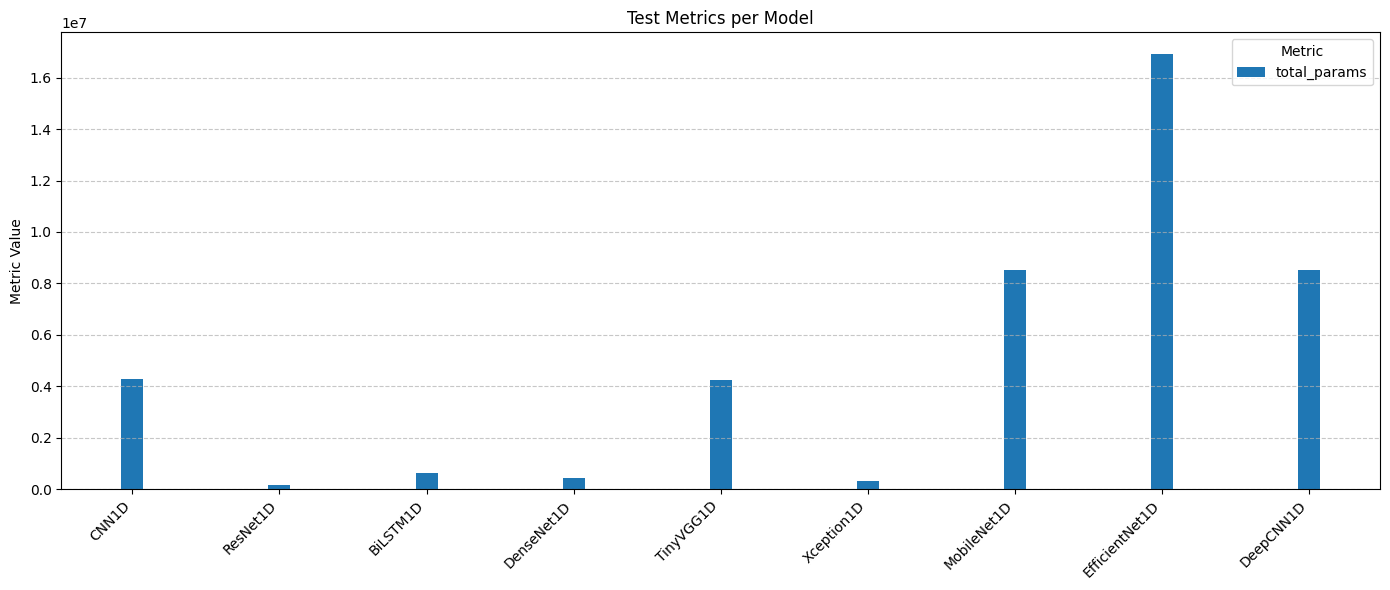

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_static_test_metrics_bar(_metrics, metric_names):
    """
    Plots test metrics as a grouped static bar chart using Matplotlib.

    Args:
        _metrics (dict): Model names as keys, and their metric dicts as values.
        metric_names (list): List of metric names to display on the chart.
    """
    model_names = list(_metrics.keys())
    num_models = len(model_names)
    num_metrics = len(metric_names)

    bar_width = 0.15
    x = np.arange(num_models)

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, metric in enumerate(metric_names):
        values = [model_metrics.get(metric, 0) for model_metrics in _metrics.values()]
        ax.bar(x + i * bar_width, values, width=bar_width, label=metric)

    ax.set_xticks(x + bar_width * (num_metrics - 1) / 2)
    ax.set_xticklabels(model_names, rotation=45, ha='right')

    ax.set_ylabel('Metric Value')
    ax.set_title('Test Metrics per Model')
    ax.legend(title='Metric')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_static_test_metrics_bar(pt_metrics, ['fault_type_acc', 'fault_size_acc', 'fault_type_size_acc', 'fault_size_r2'])
plot_static_test_metrics_bar(pt_metrics, ['fault_type_f1', 'fault_size_f1', 'fault_type_size_f1'])
plot_static_test_metrics_bar(pt_metrics, ['fault_size_mse', 'fault_size_rmse', 'fault_size_mae'])
plot_static_test_metrics_bar(pt_metrics, ['fault_size_mape'])
plot_static_test_metrics_bar(pt_metrics, ['train_time'])
plot_static_test_metrics_bar(pt_metrics, ['inference_time'])
plot_static_test_metrics_bar(pt_metrics, ['model_size'])
plot_static_test_metrics_bar(pt_metrics, ['total_flops'])
plot_static_test_metrics_bar(pt_metrics, ['total_params'])


## **Download**

In [30]:
import shutil

# Define source and destination
source_folder = os.path.join(save_dir, "PyTorch")
output_zip = os.path.join(save_dir, f"{ZIP_NAME}.zip")

try:
    if not os.path.exists(source_folder):
        raise FileNotFoundError(f"Source folder does not exist: {source_folder}")

    # Zip the folder
    shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=source_folder)
    print(f"✅ Zipping complete! You can now download '{os.path.basename(output_zip)}' from the side panel. Click Refresh if required.")
except Exception as e:
    print(f"❌ Error during zipping: {e}")


✅ Zipping complete! You can now download 'CWRU_All_Data-Base_1-3.zip' from the side panel. Click Refresh if required.
